# **A04조 식중독 발생 예측 모델링 코드 모음**

# **Ⅰ. 패키지 관리**

In [1]:
# 데이터 처리 및 전처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler

# 통계분석 및 진단
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터 분할 및 모델 선택
from pycaret.classification import setup, compare_models, pull, get_config
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict

# 모델링 및 알고리즘
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, log_evaluation, early_stopping

# 모델 성능평가
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, roc_curve, auc

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.font_manager as fm
from pandas.plotting import scatter_matrix

# 파일 입출력 및 시스템 설정
import os
import joblib
import warnings
warnings.filterwarnings('ignore')


# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' if 'Malgun Gothic' in [f.name for f in fm.fontManager.ttflist] else 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False 

In [2]:
import os
os.chdir('D:/Bootcamp/4th_project/process/12. code_combined/data')

# **Ⅱ. Master Table 제작**

## **1. 지역별 Master Table**

### 1. 식중독 지역별 현황

In [3]:
mfds_region_df = pd.read_csv('OpenAPI_식중독 지역별 현황.csv')
data = []

# 지역 정의
areas = ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']

# 발생 지역 순서 반복문
for year in range(2023, 2001, -1):
    for area in areas:
        for month in range(12, 0, -1):
            data.append([year, month, area])

master_format_ed_df = pd.DataFrame(data, columns=["OCCRNC_YEAR", "OCCRNC_MM", "OCCRNC_REGN"])

In [4]:
# Master_format 에 Year, Month, Region 기준으로 병합
merged_df1 = pd.merge(
    master_format_ed_df,
    mfds_region_df[['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_AREA','OCCRNC_CNT','PATNT_CNT']],
    left_on=['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_REGN'],
    right_on=['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_AREA'],
    how='left'
)

# 'OCCRNC_AREA' 컬럼 삭제
merged_df1 = merged_df1.drop(columns=['OCCRNC_AREA'])

# 'OCCRNC_CNT', 'PATNT_CNT' 에서 결측치 (식중독 미발생 케이스) 0으로 치환
merged_df1 = merged_df1.fillna(0)

# 식중독 발생 유무를 나타내는 'OCCRNC_IND' (Occurrence Indicator) 컬럼 추가 (발생했을 경우 1, 미발생의 경우 0)
merged_df1['OCCRNC_IND'] = merged_df1['OCCRNC_CNT'].apply(lambda x: 0 if x == 0 else 1)

### 2. Golden Holiday 병합

In [5]:
merged_df2 = merged_df1.copy()
hol_df = pd.read_csv('Regional_golden_holidays_2002_2023.csv')
# hol_df 에서 년/월 기준으로 그룹화 및 'HOL_DUR' 값 합 계산
hol_grouped = hol_df.groupby(['HOL_YEAR', "HOL_MM"]).agg({'HOL_DUR': 'sum'})

# Holiday 관련 컬럼 추가
# HOL_IND : 황금연휴의 유무를 나타내는 컬럼 (Holiday Indicator) 추가
# HOL_DUR : 황금연휴의 기간을 나타내는 컬럼 (Holiday Duration) 추가
merged_df2['HOL_IND'] = 0
merged_df2['HOL_DUR'] = 0

# HOL_IND : 특정 년/월에 황금연휴가 존재할 경우 1, 없을 경우 0 으로 표기
# HOL_DUR : 특정 년/월에 존재하는 모든 황금연휴의 총 일수
for idx, row in merged_df2.iterrows():
    year = row['OCCRNC_YEAR']
    month = row['OCCRNC_MM']
    if (year, month) in hol_grouped.index:
        merged_df2.at[idx, 'HOL_IND'] = 1
        merged_df2.at[idx, 'HOL_DUR'] = hol_grouped.loc[(year, month), 'HOL_DUR']

### 3. CPI 병합

In [6]:
merged_df3 = merged_df2.copy()
CPI_df = pd.read_csv('Regional_CPI_2002_2022.csv')

# merged_df3와 CPI_df를 'OCCRNC_YEAR'와 'CPI_YEAR', 'OCCRNC_MM'와 'CPI_MM', 'OCCRNC_REGN'과 'CPI_REGN' 기준으로 병합
merged_df3 = pd.merge(
    merged_df3,
    CPI_df,
    left_on=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_REGN'],
    right_on=['CPI_YEAR', 'CPI_MM', 'CPI_REGN'],
    how='left'
)

# 필요 없는 'CPI_YEAR', 'CPI_MM', 'CPI_REGN' 컬럼 제거
merged_df3 = merged_df3.drop(columns=['CPI_YEAR', 'CPI_MM', 'CPI_REGN'])

### 4. 기후 병합

In [7]:
merged_df4 = merged_df3.copy()
weather_df = pd.read_csv('Regional_weather_2002_2024.csv')

# merged_df4 와 weather_df를 'OCCRNC_YEAR'와 'WTHR_YEAR', 'OCCRNC_MM'와 'WTHR_MM', 'OCCRNC_REGN'과 'WTHR_REGN' 기준으로 병합
merged_df4 = pd.merge(
    merged_df4,
    weather_df,
    left_on=['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_REGN'],
    right_on=['WTHR_YEAR','WTHR_MM','WTHR_REGN'],
    how='left'
)

# 필요 없는 'WTHR_YEAR','WTHR_MM','WTHR_REGN' 컬럼 제거
merged_df4 = merged_df4.drop(columns=['WTHR_YEAR','WTHR_MM','WTHR_REGN'])

### 5. 축제 병합

In [8]:
fest_df = pd.read_csv('Regional_festival_2002_2022.csv')
merged_df5 = merged_df4.copy()

# merged_df5 와 fest_df를 'OCCRNC_YEAR'와 'FST_YEAR', 'OCCRNC_MM'와 'FST_MM', 'OCCRNC_REGN'과 'FST_REGN' 기준으로 병합
merged_df5 = pd.merge(
    merged_df5,
    fest_df,
    left_on=['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_REGN'],
    right_on=['FST_YEAR','FST_MM','FST_REGN'],
    how='left'
)

# 필요 없는 'FST_YEAR','FST_MM','FST_REGN' 컬럼 제거
merged_df5 = merged_df5.drop(columns=['FST_YEAR','FST_MM','FST_REGN'])

### 6. 인구 및 집단급식소 인허가수 병합

In [9]:
pop_df = pd.read_csv('Regional_population_2002_2024.csv')
merged_df6 = merged_df5.copy()

merged_df6 = pd.merge(
    merged_df6,
    pop_df,
    left_on=['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_REGN'],
    right_on=['POP_YEAR','POP_MM','POP_REGN'],
    how='left'
)

merged_df6 = merged_df6.drop(columns=['POP_YEAR','POP_MM','POP_REGN'])

In [10]:
# 지역별 마스터 테이블
region_master_df = merged_df6.copy()
region_master_df.head(5)

OCCRNC_YEAR  OCCRNC_MM OCCRNC_REGN  OCCRNC_CNT  PATNT_CNT  OCCRNC_IND  \
0         2023         12          강원         0.0        0.0           0   
1         2023         11          강원         3.0       12.0           1   
2         2023         10          강원         5.0       36.0           1   
3         2023          9          강원         4.0      152.0           1   
4         2023          8          강원         3.0       24.0           1   

   HOL_IND  HOL_DUR  CPI_VALUE  WTHR_AVG_TEMP  ...  POP_MID_CNT  POP_HIGH_CNT  \
0        1        6        NaN            0.0  ...          NaN           NaN   
1        0        0        NaN            6.3  ...          NaN           NaN   
2        1        3        NaN           13.2  ...          NaN           NaN   
3        1        6        NaN           21.0  ...          NaN           NaN   
4        1        4        NaN           25.0  ...          NaN           NaN   

   POP_60P_CNT  POP_STU_PER_SCH  POP_ELM_RATIO  POP_MID_RATIO  POP_HIGH_RATIO  \
0          NaN              NaN            NaN            NaN             NaN   
1          NaN              NaN            NaN            NaN             NaN   
2          NaN              NaN            NaN            NaN             NaN   
3          NaN              NaN            NaN            NaN             NaN   
4          NaN              NaN            NaN            NaN             NaN   

   POP_60P_RATIO  POP_DENS  GMS_LIC_CNT  
0            NaN       NaN          NaN  
1            NaN       NaN          NaN  
2            NaN       NaN          NaN  
3            NaN       NaN          NaN  
4            NaN       NaN          NaN  

[5 rows x 37 columns]

## **2. 원인물질별 Master Table**

### 1. 식중독 원인물질별 현황

In [11]:
data = []

# 물질 정의
causes = [
    '노로바이러스','바실러스세레우스','병원성대장균','살모넬라',
    '원충','장염비브리오','캠필로박터제주니','클로스트리디움퍼프린젠스','황색포도상구균'
    ]

# 원인물질 순서 반복문
for year in range(2022, 2001, -1):
    for cause in causes:
        for month in range(12, 0, -1):
            data.append([year, month, cause])

master_format_df = pd.DataFrame(data, columns=["OCCRNC_YEAR", "OCCRNC_MM", "OCCRNC_VIRS"])

In [12]:
mfds_cause_df = pd.read_csv('OpenAPI_식중독 원인물질별 현황.csv')

# Master_format 에 Year, Month, Cause 기준으로 병합
cause_merged_df1 = pd.merge(
    master_format_df,
    mfds_cause_df[['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_VIRS','OCCRNC_CNT','PATNT_CNT']],
    left_on=['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_VIRS'],
    right_on=['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_VIRS'],
    how='left'
)

# 'OCCRNC_CNT', 'PATNT_CNT' 에서 결측치 (식중독 미발생 케이스) 0으로 치환
cause_merged_df1 = cause_merged_df1.fillna(0)

# 식중독 발생 유무를 나타내는 'OCCRNC_IND' (Occurrence Indicator) 컬럼 추가 (발생했을 경우 1, 미발생의 경우 0)
cause_merged_df1['OCCRNC_IND'] = cause_merged_df1['OCCRNC_CNT'].apply(lambda x: 0 if x == 0 else 1)

### 2. Golden Holiday 병합

In [13]:
hol_df = pd.read_csv('National_holiday_2002_2022.csv')
merged_df2 = cause_merged_df1.copy()

# merged_df3와 hol_df를 'OCCRNC_YEAR'와 'HOL_YEAR', 'OCCRNC_MM'와 'HOL_MM' 기준으로 병합
merged_df2 = pd.merge(
    merged_df2,
    hol_df,
    left_on=['OCCRNC_YEAR', 'OCCRNC_MM'],
    right_on=['HOL_YEAR', 'HOL_MM'],
    how='left'
)

# 필요 없는 'HOL_YEAR', 'HOL_MM' 컬럼 제거
merged_df2 = merged_df2.drop(columns=['HOL_YEAR', 'HOL_MM'])

### 3. CPI 병합

In [14]:
CPI_df = pd.read_csv('National_CPI_2002_2022.csv')
merged_df3 = merged_df2.copy()

# merged_df3와 CPI_df를 'OCCRNC_YEAR'와 'CPI_YEAR', 'OCCRNC_MM'와 'CPI_MM', 'OCCRNC_REGN'과 'CPI_REGN' 기준으로 병합
merged_df3 = pd.merge(
    merged_df3,
    CPI_df,
    left_on=['OCCRNC_YEAR', 'OCCRNC_MM'],
    right_on=['CPI_YEAR', 'CPI_MM'],
    how='left'
)

# 필요 없는 'CPI_YEAR', 'CPI_MM' 컬럼 제거
merged_df3 = merged_df3.drop(columns=['CPI_YEAR', 'CPI_MM'])

### 4. 기후병합

In [15]:
weather_df = pd.read_csv('National_weather_2002_2022.csv')
merged_df4 = merged_df3.copy()

# merged_df4 와 weather_df를 'OCCRNC_YEAR'와 'WTHR_YEAR', 'OCCRNC_MM'와 'WTHR_MM', 'OCCRNC_REGN'과 'WTHR_REGN' 기준으로 병합
merged_df4 = pd.merge(
    merged_df4,
    weather_df,
    left_on=['OCCRNC_YEAR','OCCRNC_MM'],
    right_on=['WTHR_YEAR','WTHR_MM'],
    how='left'
)

# 필요 없는 'WTHR_YEAR','WTHR_MM' 컬럼 제거
merged_df4 = merged_df4.drop(columns=['WTHR_YEAR','WTHR_MM'])

### 5. 축제 병합

In [16]:
fest_df = pd.read_csv('National_festival_2002_2022.csv')
merged_df5 = merged_df4.copy()

# merged_df5 와 fest_df를 'OCCRNC_YEAR'와 'FST_YEAR', 'OCCRNC_MM'와 'FST_MM', 'OCCRNC_REGN'과 'FST_REGN' 기준으로 병합
merged_df5 = pd.merge(
    merged_df5,
    fest_df,
    left_on=['OCCRNC_YEAR','OCCRNC_MM'],
    right_on=['FST_YEAR','FST_MM'],
    how='left'
)

# 필요 없는 'FST_YEAR','FST_MM' 컬럼 제거
merged_df5 = merged_df5.drop(columns=['FST_YEAR','FST_MM'])

### 6. 인구 및 집단급식소 인허가수 병합

In [ ]:
pop_df = pd.read_csv('National_population_2002_2022.csv')
merged_df6 = merged_df5.copy()
merged_df6 = pd.merge(
    merged_df6,
    pop_df,
    left_on=['OCCRNC_YEAR','OCCRNC_MM'],
    right_on=['POP_YEAR','POP_MM'],
    how='left'
)

merged_df6 = merged_df6.drop(columns=['POP_YEAR','POP_MM'])

In [ ]:
# 원인물질별 마스터 테이블
cause_master_df = merged_df6.copy()
cause_master_df.head(5)

In [ ]:
# 마스터 테이블 저장
region_master_df.to_csv('Foodborne_Region_MasterTable.csv',index=False)
cause_master_df.to_csv('Foodborne_Cause_MasterTable4.csv',index=False)

# **Ⅲ. Master Table 전처리**

## 1. CPI 결측치 보완

In [18]:
region_df = pd.read_csv('Foodborne_Region_MasterTable.csv')
cause_df = pd.read_csv('Foodborne_Cause_MasterTable4.csv')

In [19]:
df = pd.read_csv('Regional_CPI_2002_2022.csv')
df.head()

CPI_YEAR  CPI_MM CPI_REGN  CPI_VALUE
0      2002       1       서울     65.403
1      2002       2       서울     65.650
2      2002       3       서울     66.083
3      2002       4       서울     66.454
4      2002       5       서울     66.764

In [20]:
# 세종과 비교할 도시: 서울, 경기, 충북, 충남, 세종, 대전
regions = ['서울', '경기', '충북', '충남', '세종', '대전']
filtered_data = {region: df[(df['CPI_REGN'] == region) & 
                            (df['CPI_YEAR'].isin([2020, 2021, 2022, 2023, 2024])) & 
                            (df['CPI_MM'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]))]
                 for region in regions}

integrated = filtered_data['서울'][['CPI_YEAR', 'CPI_MM', 'CPI_VALUE']]
for region in regions[1:]:
    integrated = pd.merge(integrated, filtered_data[region][['CPI_YEAR', 'CPI_MM', 'CPI_VALUE']], on=['CPI_YEAR', 'CPI_MM'], how='inner', suffixes=('', f'_{region}'))
    
# 컬럼명 변경
integrated.columns= ['CPI_YEAR', 'CPI_MM', 'CPI_VALUE_서울', 'CPI_VALUE_경기', 'CPI_VALUE_충북', 'CPI_VALUE_충남', 'CPI_VALUE_세종', 'CPI_VALUE_대전']

columns = ['CPI_VALUE_서울', 'CPI_VALUE_경기', 'CPI_VALUE_충북', 'CPI_VALUE_충남', 'CPI_VALUE_대전']
correlations = {col: integrated['CPI_VALUE_세종'].corr(integrated[col]) for col in columns}

# 상관관계 출력
for col, corr_value in correlations.items():
    print(f'SJ_{col[-2:]}:', corr_value)

SJ_서울: 0.9962033313867575
SJ_경기: 0.998564116085313
SJ_충북: 0.999182355632971
SJ_충남: 0.998229094349759
SJ_대전: 0.9990835741139044


- CPI 보완 방법  
  
2020년부터 2024년 9월까지의 서울, 경기, 충북, 충남, 대전의 cpi를 세종시와 상관계수를 비교한 결과 아주 근소한 차이로 경기의 CPI와 상관관계가 가장 높았음.  
  
그러나 과거의 결측치를 채워야 하는 관점에서 본다면, 세종이 충북에 포함되어 있었기 때문에 충북의 CPI로 세종의 CPI를 예측하는 것이 합리적이라고 생각함.  
  
세종의 2020~2024 cpi를 종속변수, 충북의 2020~2024 cpi를 독립변수로 선형회귀 후, weight와 상수항을 구해서 2012~2019의 충북의 cpi에 넣어서 연산하여 세종의 cpi를 예측

In [21]:
y = filtered_data['세종']['CPI_VALUE'].values.reshape(-1, 1)
x = filtered_data['충북']['CPI_VALUE'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(x, y)

weight = model.coef_[0]
bias = model.intercept_

print(f"기울기: {weight}")
print(f"상수항 : {bias}")

y_pred = model.predict(x)
print(f"predicted y values: {y_pred}")

regions = ['충북']
filtered_data2 = {region: df[(df['CPI_REGN'] == region) & 
                            (df['CPI_YEAR'].isin([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])) & 
                            (df['CPI_MM'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]))]['CPI_VALUE'] 
                 for region in regions}

x2 = filtered_data2['충북'].values.reshape(-1, 1)
y_pred_2012_2019 = model.predict(x2)

# 예측된 세종시의 2012~2019 CPI CSV파일로 저장후 엑셀에서 통합.
predicted_data = pd.DataFrame(y_pred_2012_2019, columns=['Predicted_Sejong_CPI_2012_2019'])
predicted_data.head(3)

기울기: [0.95972186]
상수항 : [4.08726437]
predicted y values: [[100.33777014]
 [100.38575623]
 [100.1650202 ]
 [ 99.56999265]
 [ 99.48361768]
 [ 99.73314536]
 [ 99.71395093]
 [100.19381186]
 [100.75045054]
 [100.03065914]
 [100.06904802]
 [100.27058961]
 [101.22071425]
 [101.66218631]
 [102.02688062]
 [102.14204724]
 [102.23801943]
 [102.29560274]
 [102.45875546]
 [102.82344977]
 [103.20733851]
 [103.41847732]
 [104.05189375]
 [104.19585203]
 [104.87725456]
 [105.58744874]
 [106.5471706 ]
 [107.35333697]
 [108.13071168]
 [108.9656697 ]
 [109.50311394]
 [109.28237791]
 [109.64707222]
 [109.81022494]
 [109.54150282]
 [109.59908613]]


Predicted_Sejong_CPI_2012_2019
0                       92.656156
1                       93.041005
2                       93.191681

## 2. 기본 통계 및 이상치 탐지

In [22]:
df1 = pd.read_csv('Foodborne_Region_MasterTable.csv')
df2 = pd.read_csv('Foodborne_Cause_MasterTable4.csv')

### 1. 지역별 데이터 분포 및 이상치 시각화

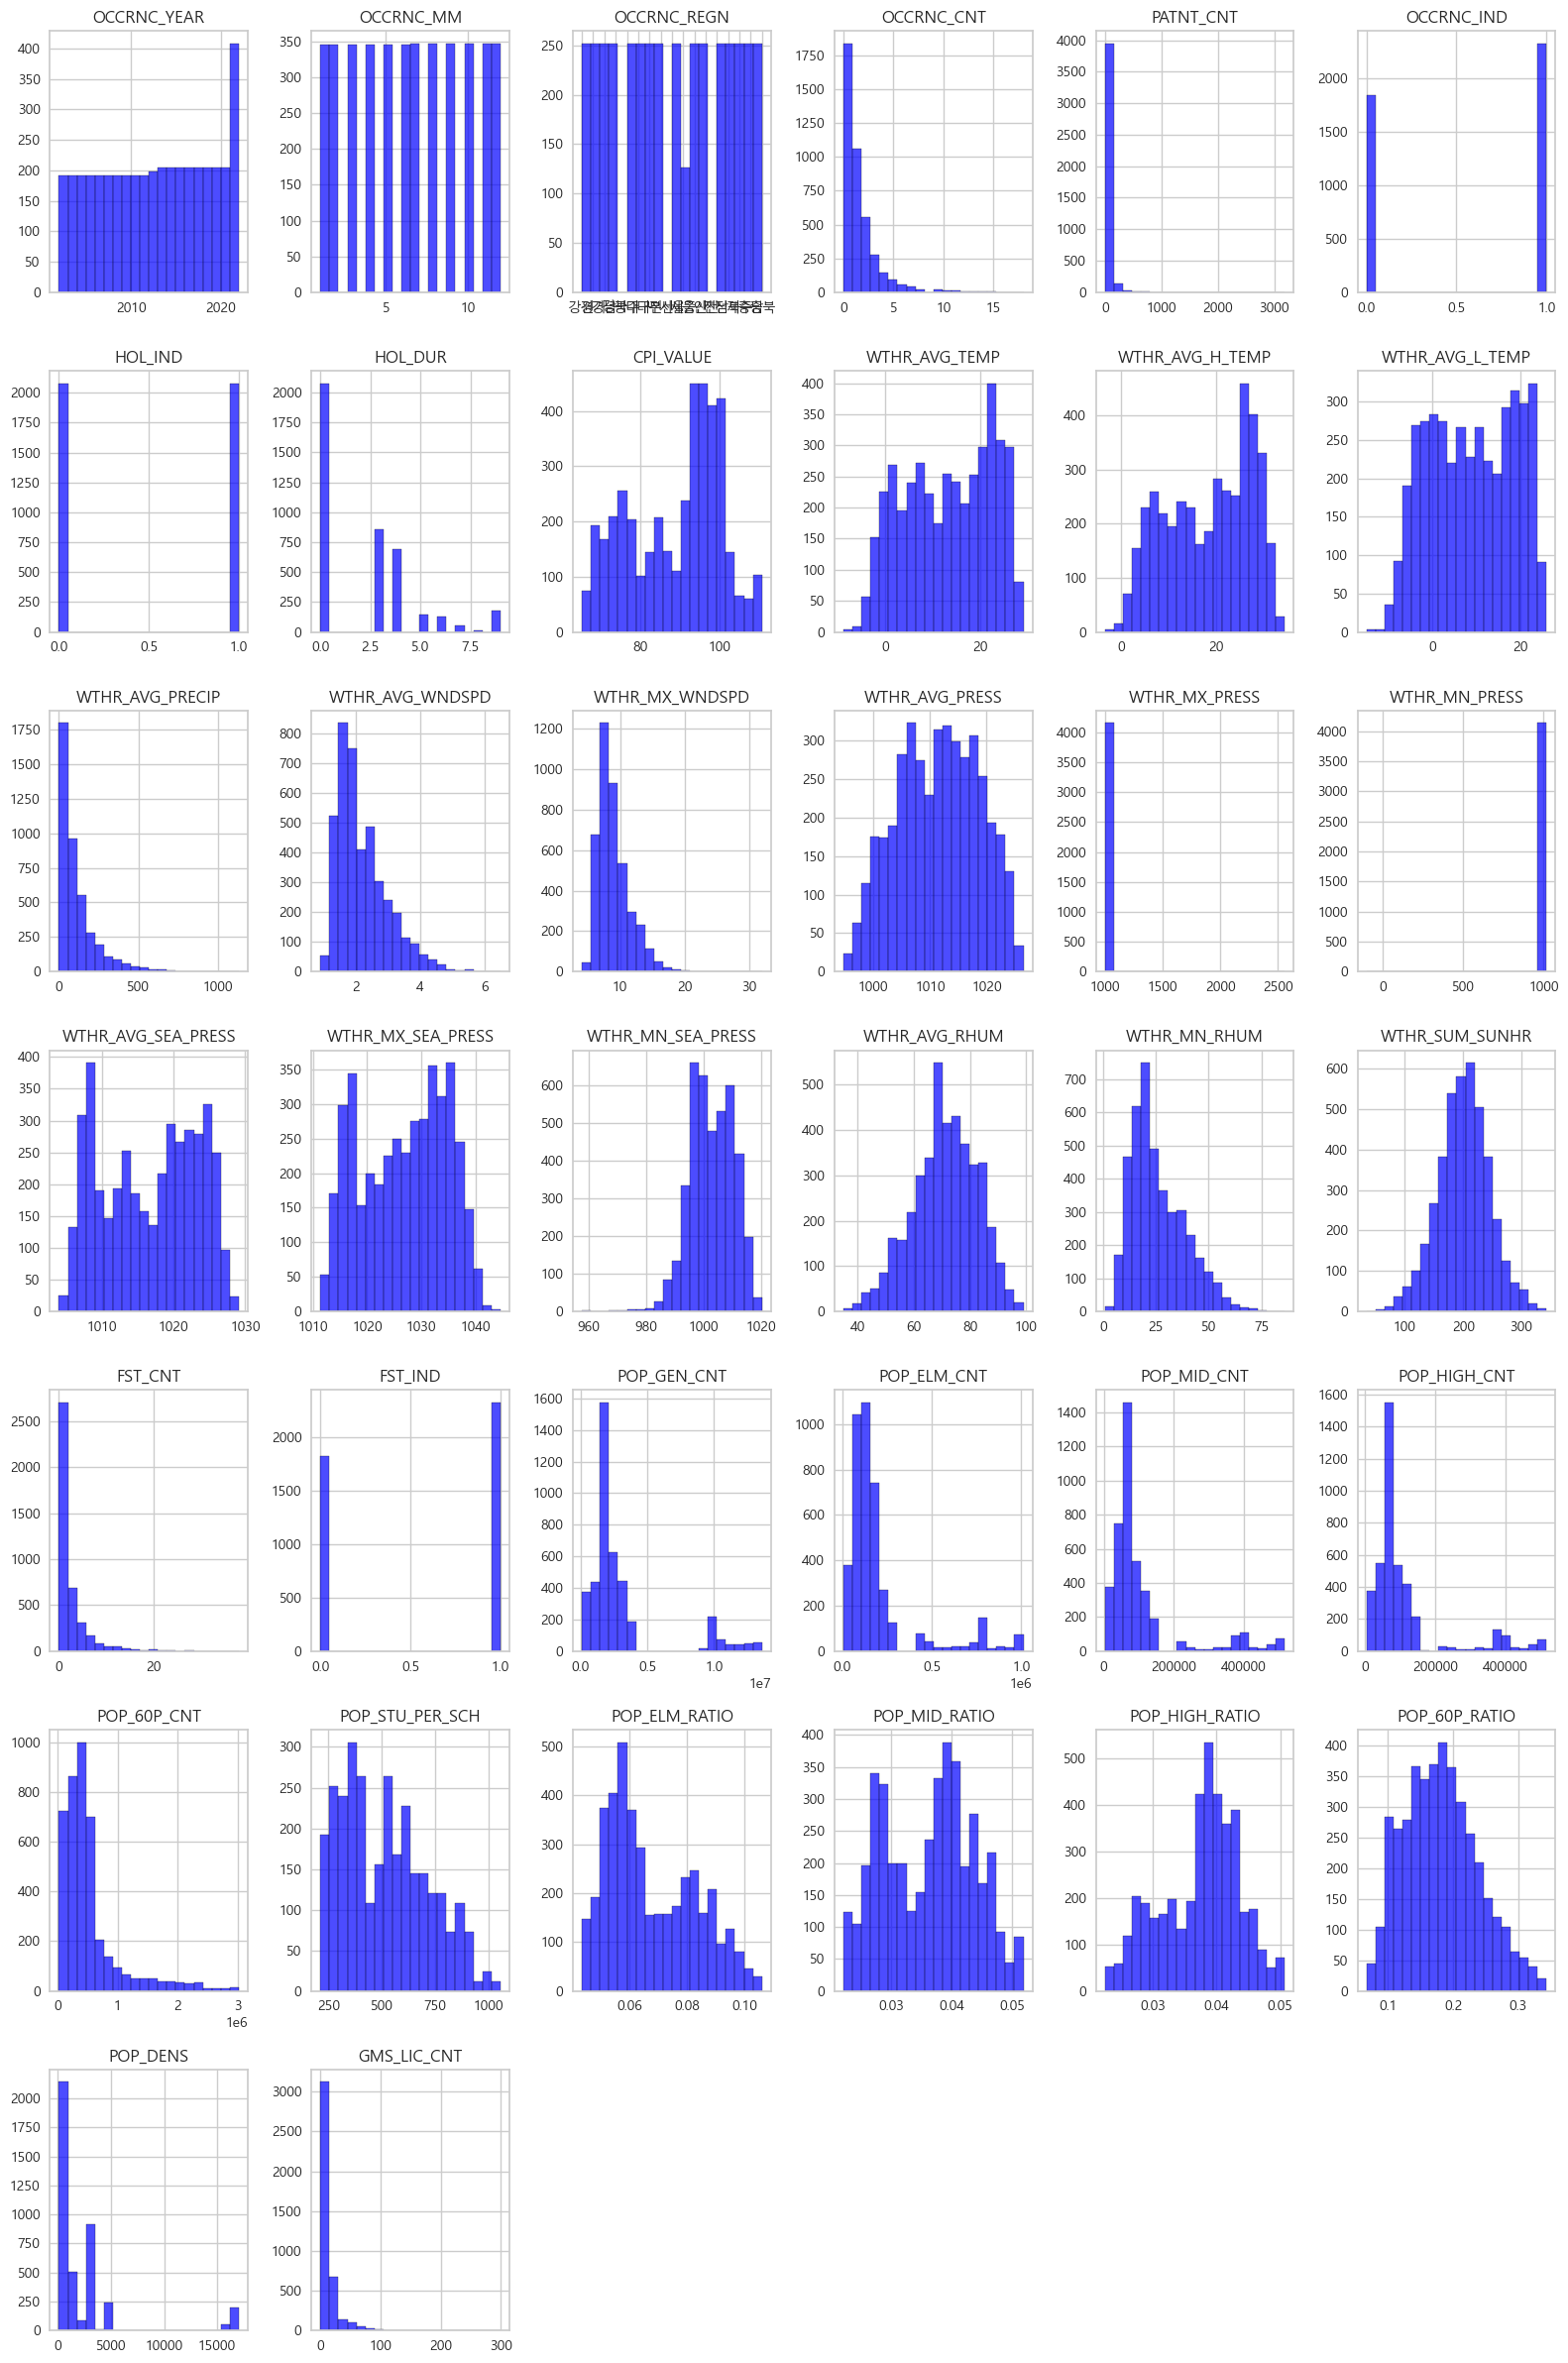

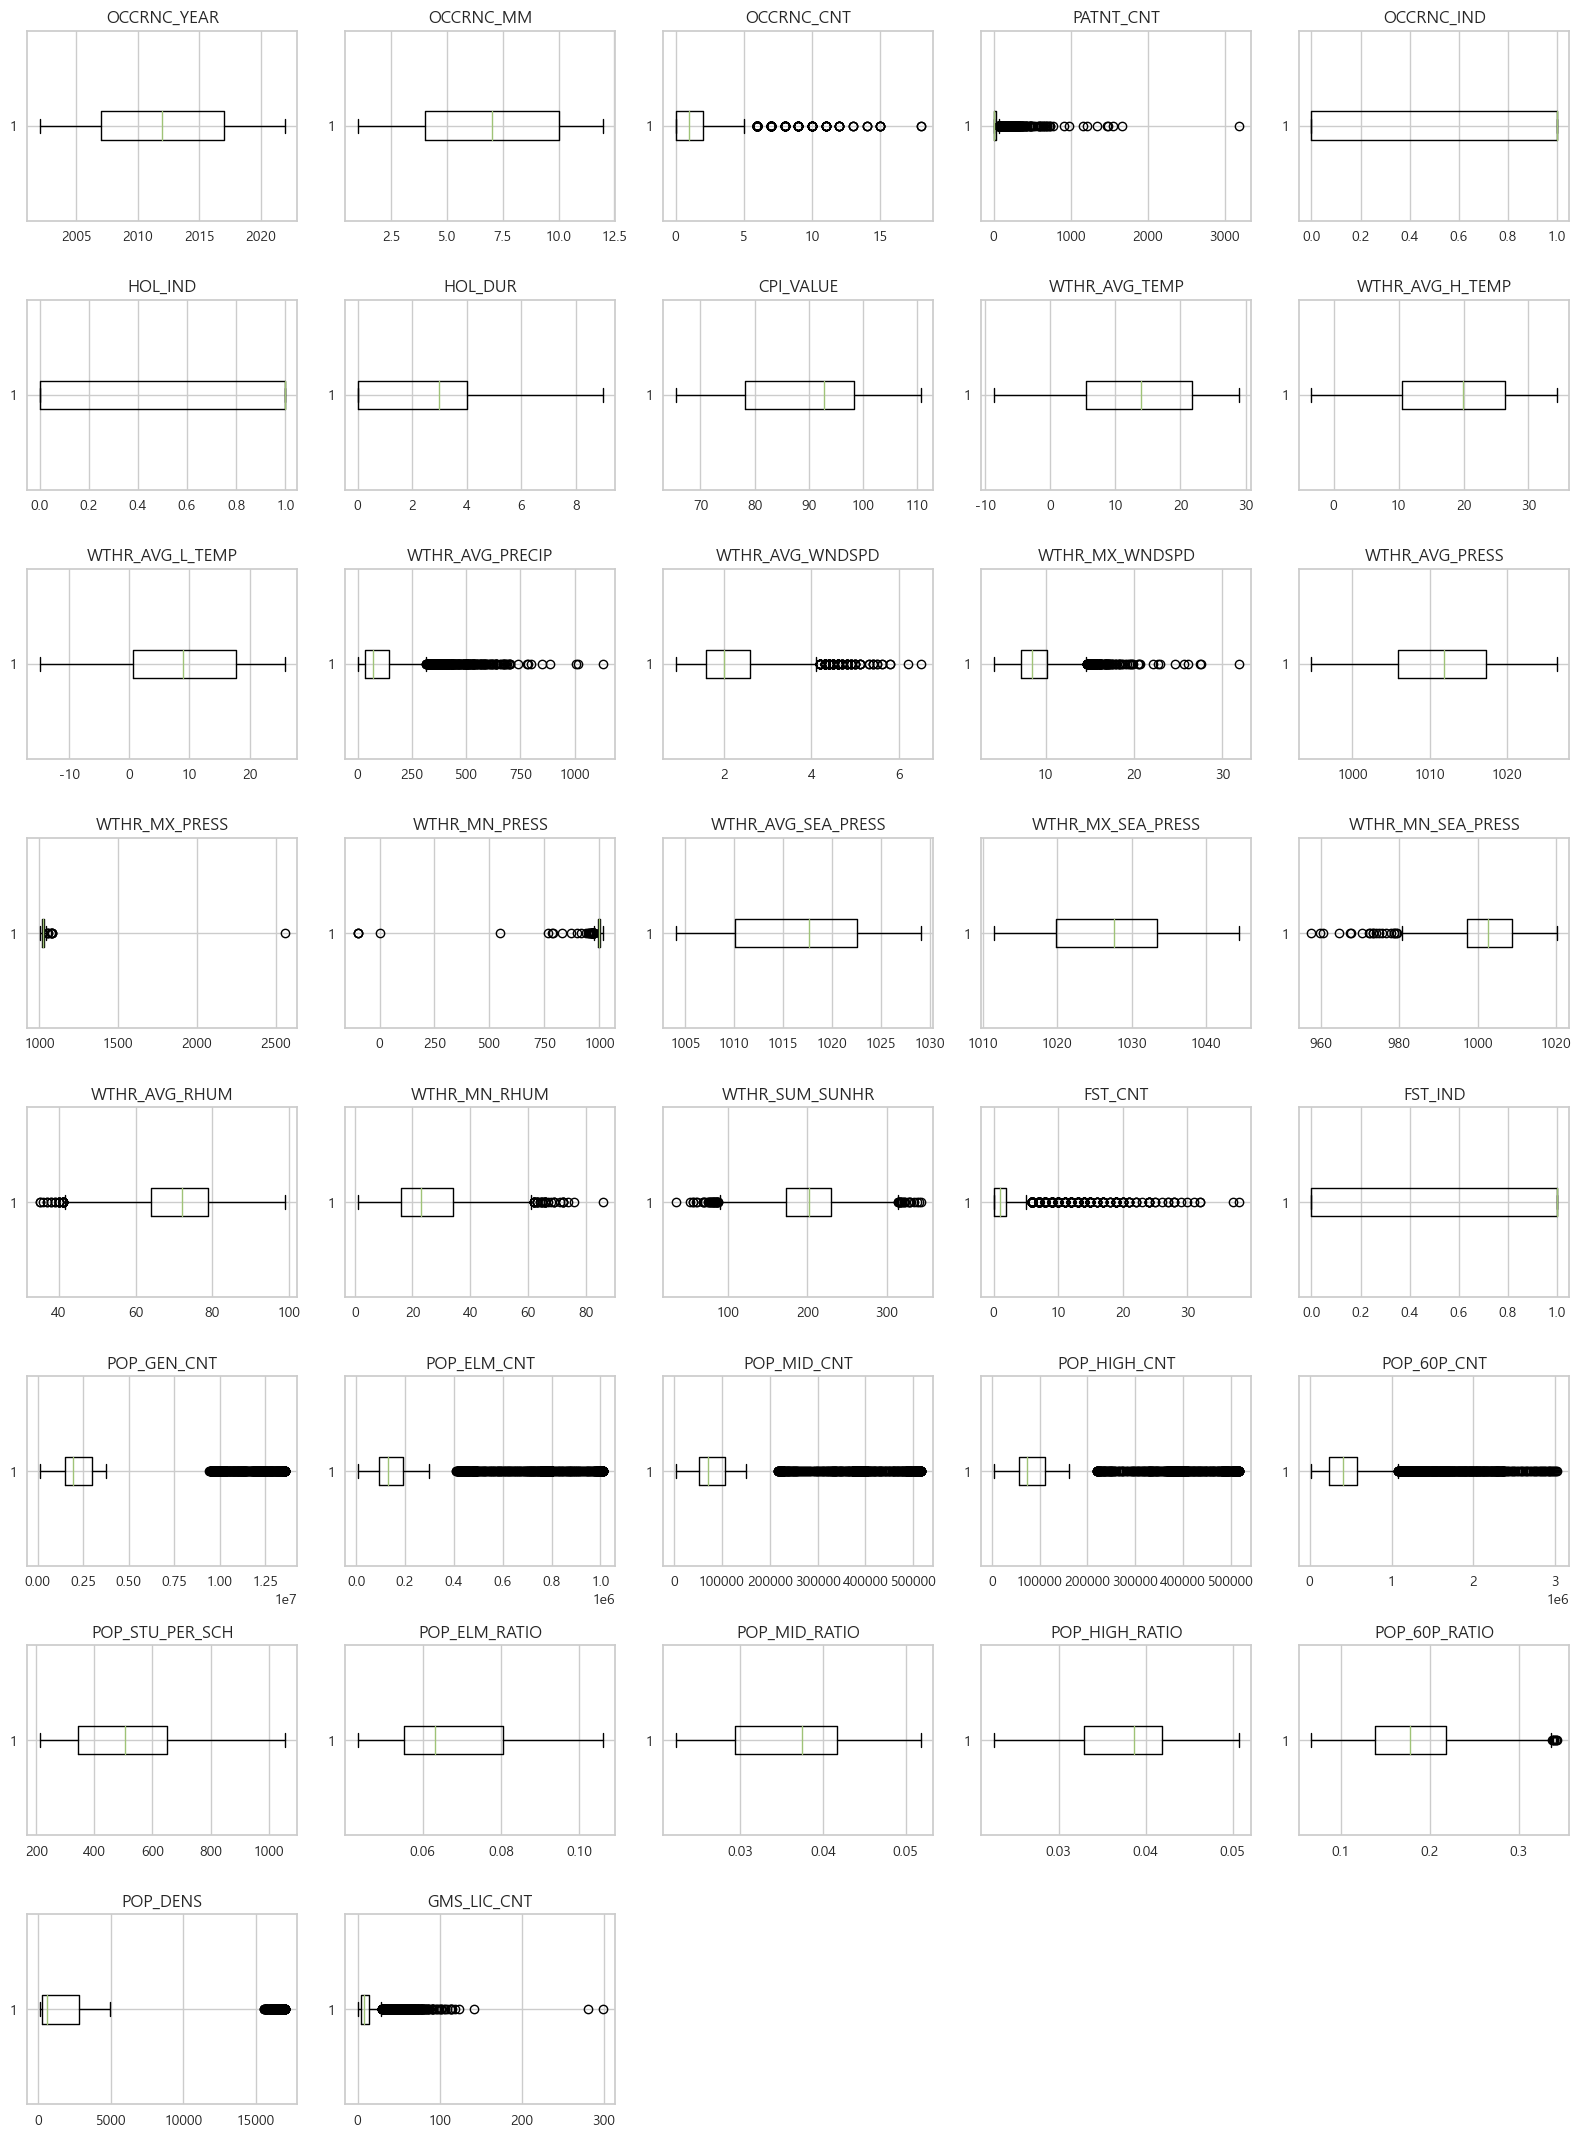

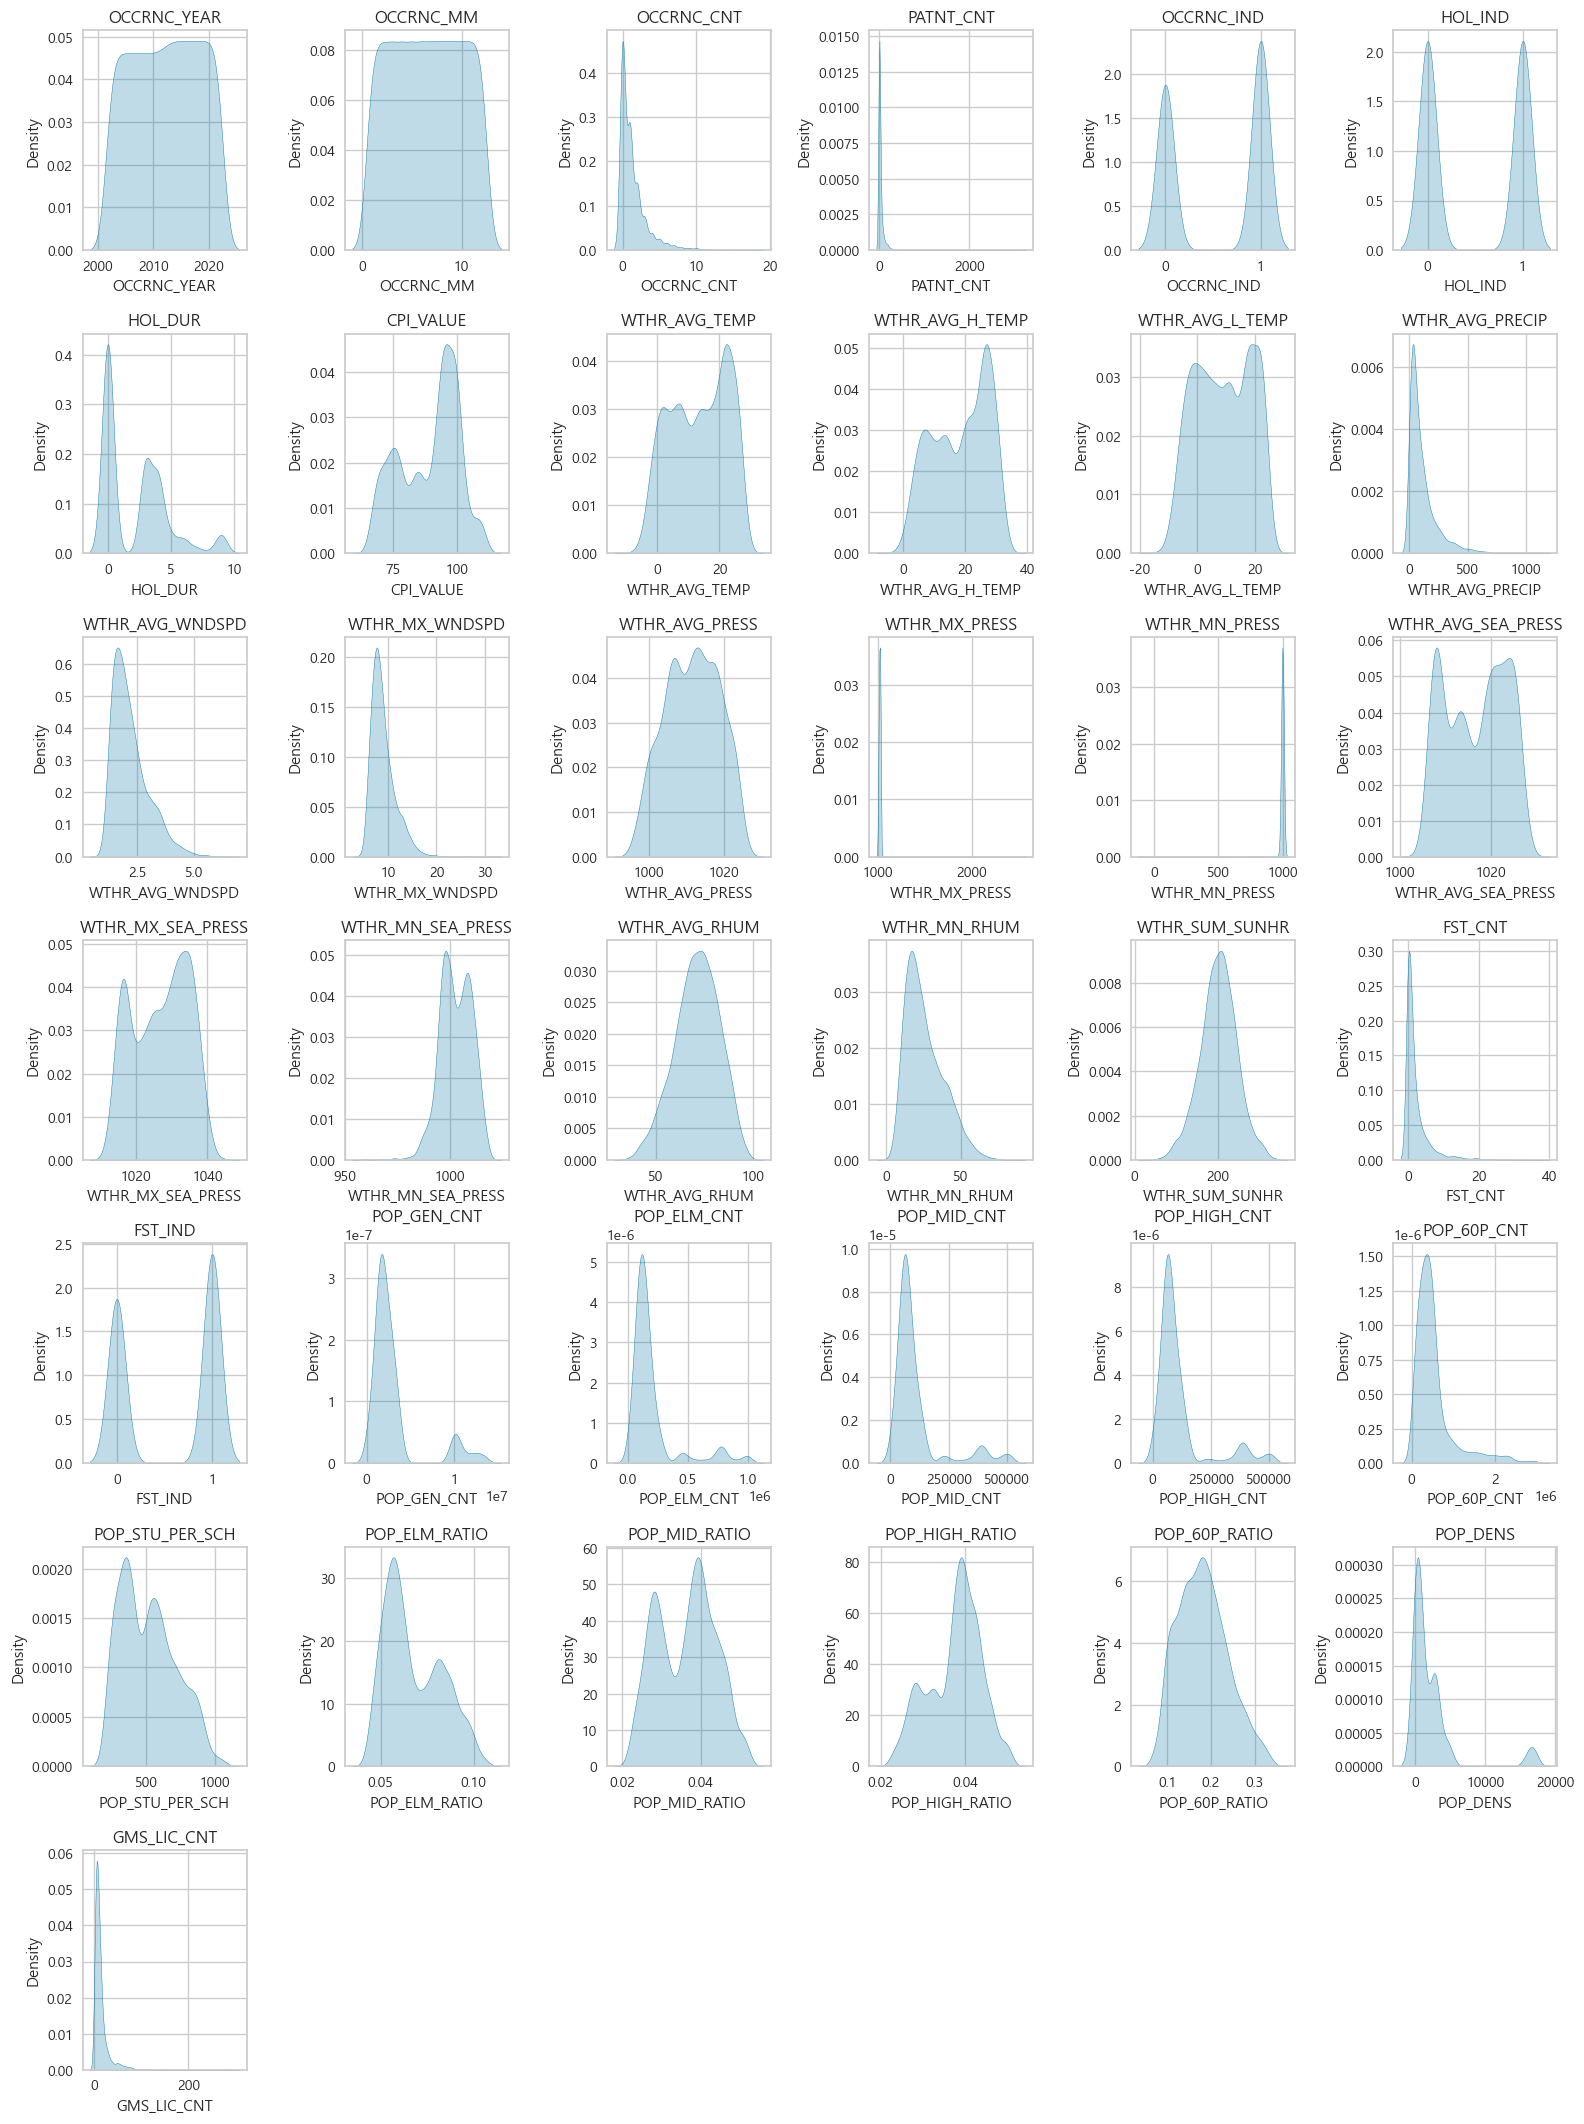

In [23]:
import matplotlib.pyplot as plt

# 변수별 분포 확인을 위한 히스토그램
plt.figure(figsize=(16, 24))
for i, col in enumerate(df1.columns, 1):
    plt.subplot(7, 6, i)
    plt.hist(df1[col].dropna(), bins=20, color='blue', edgecolor='black', alpha=0.7)
    plt.title(col)
plt.tight_layout()
plt.show()

# 박스플롯을 통한 이상치 시각화
plt.figure(figsize=(16, 24))
numeric_columns = df1.select_dtypes(include=[np.number]).columns  # 수치형 컬럼 선택
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(9, 5, i)
    plt.boxplot(df1[col].dropna(), vert=False)
    plt.title(col)
plt.tight_layout()
plt.show()

# 타겟 변수를 포함한 전체 변수의 밀도그래프
plt.figure(figsize=(16, 24))
for idx, col in enumerate(numeric_columns):
    if col in df1.columns:  # 컬럼이 존재하는지 확인
        plt.subplot(8, 6, idx + 1)
        ax = sns.kdeplot(df1[col], shade=True)
        plt.title(f'{col}')
plt.tight_layout()
plt.show()

### 2. 원인물질별 데이터 분포 및 이상치 시각화

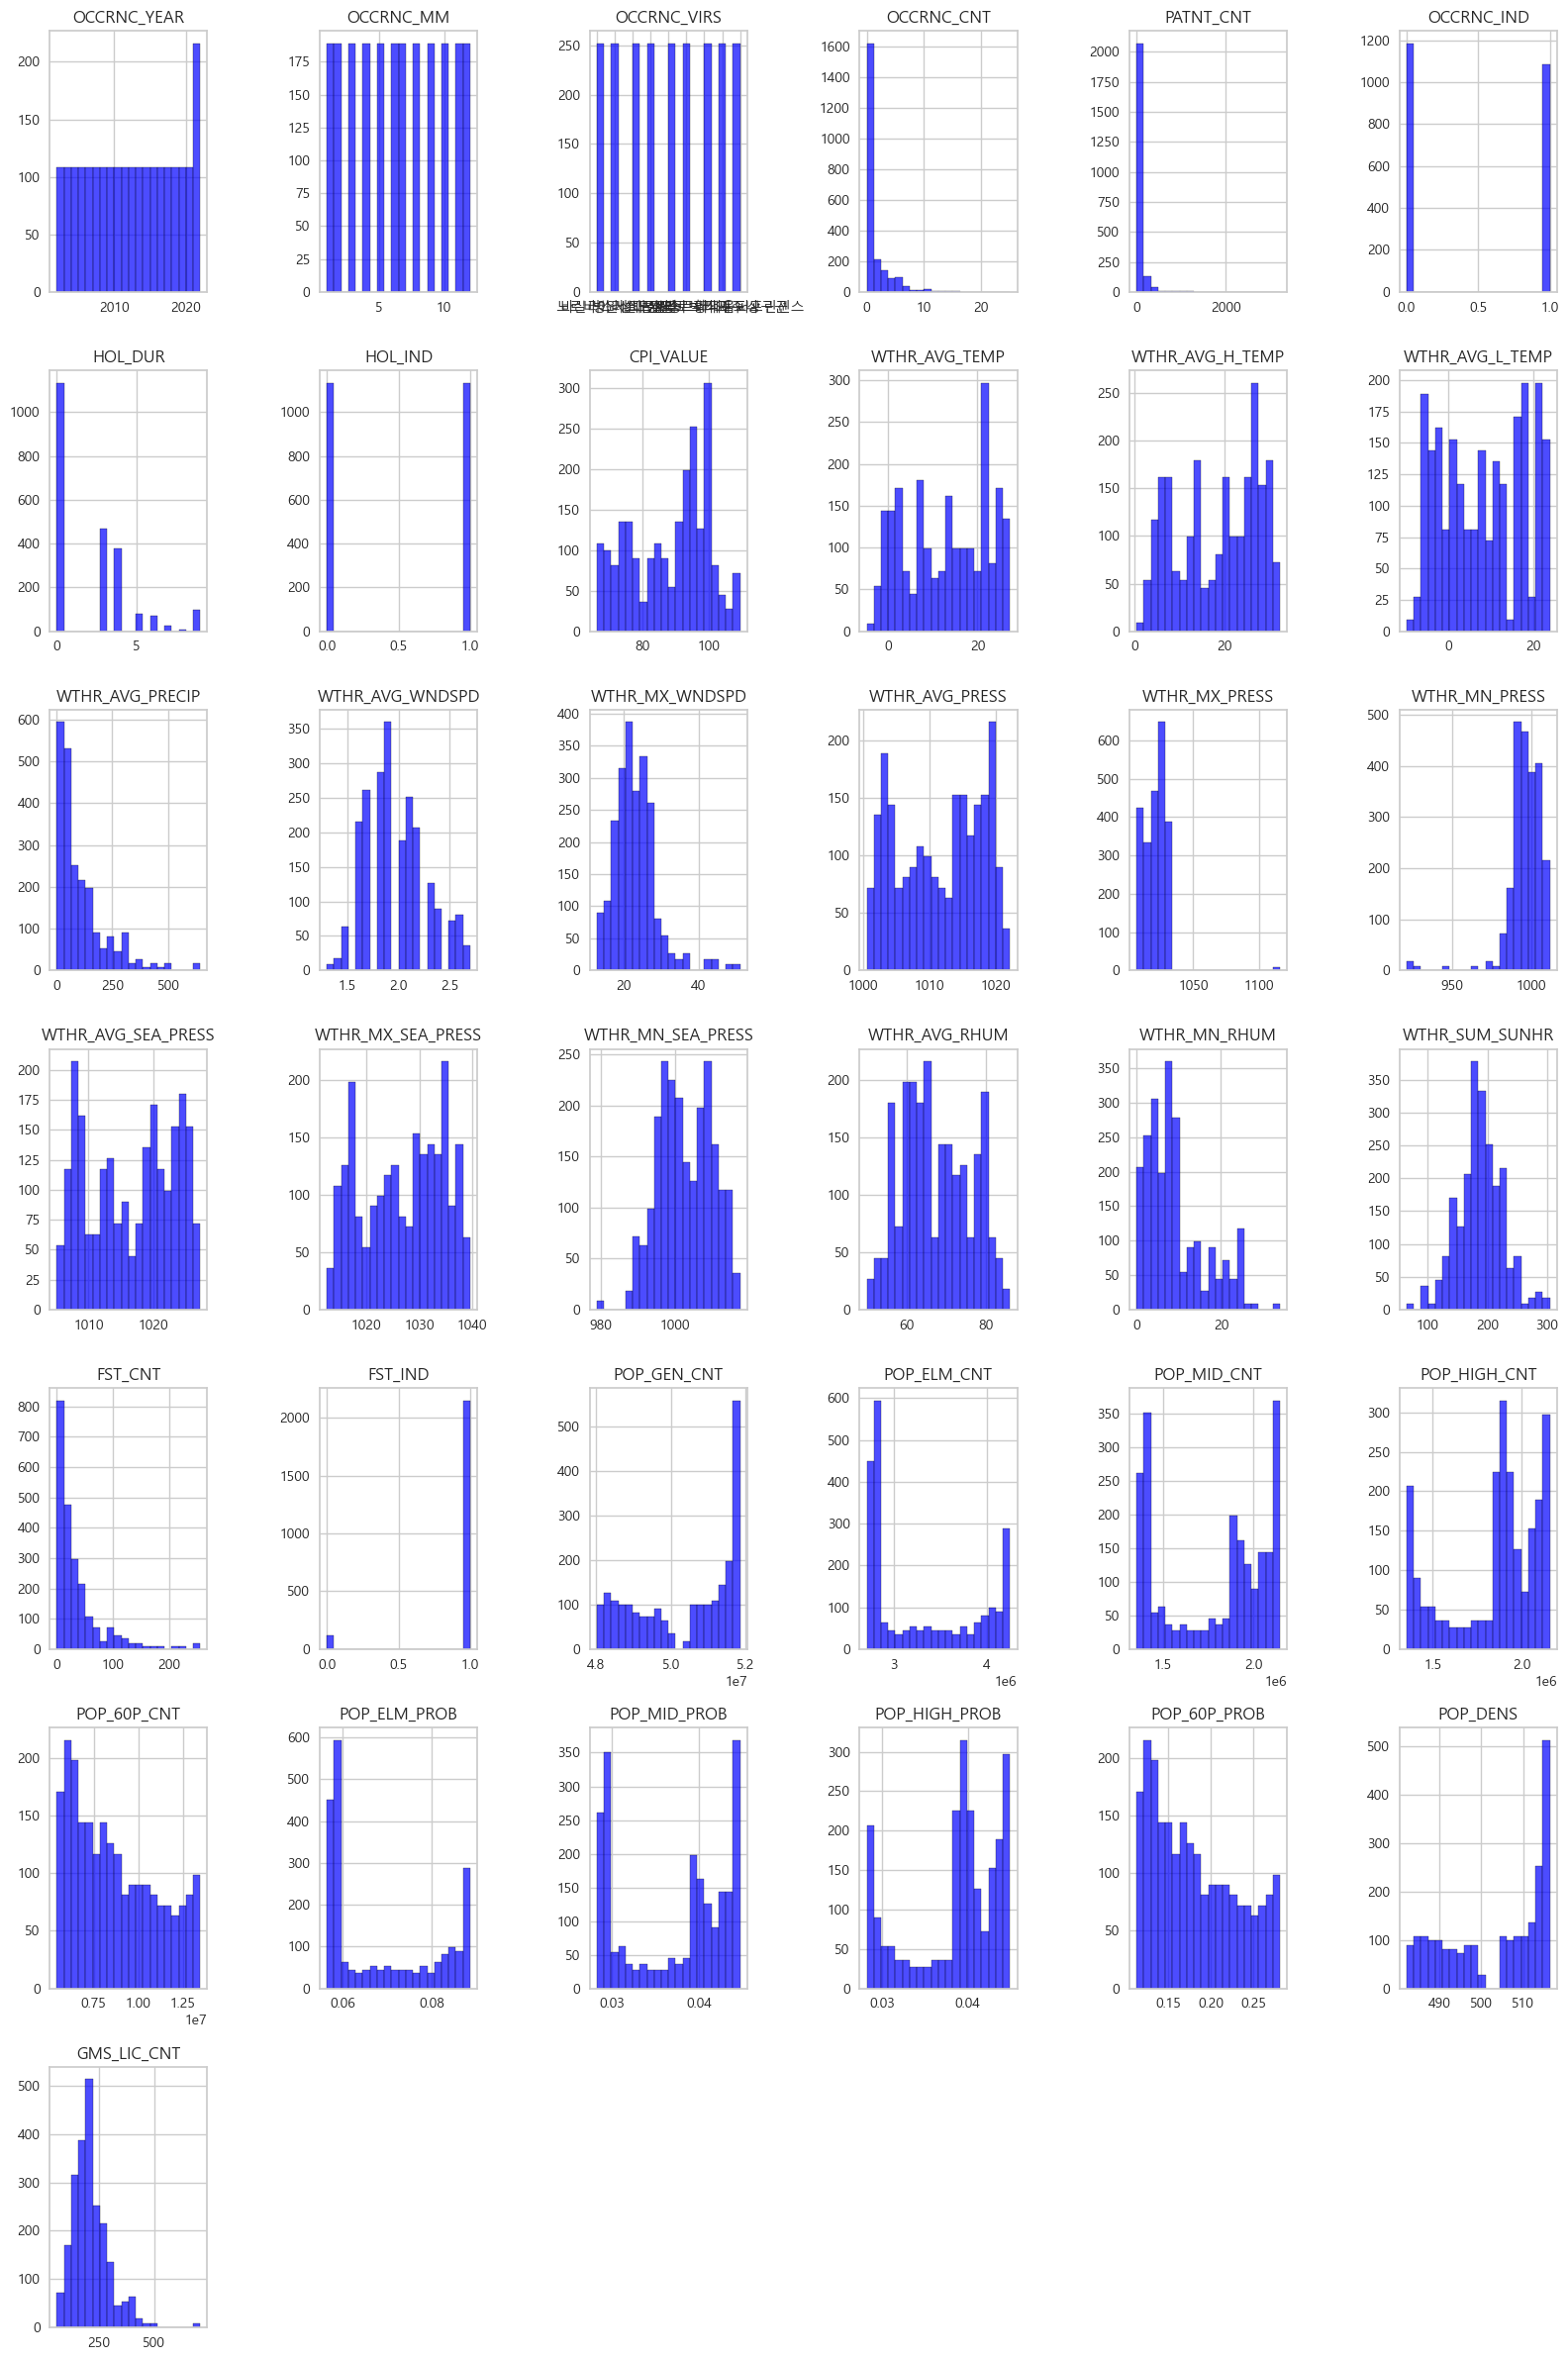

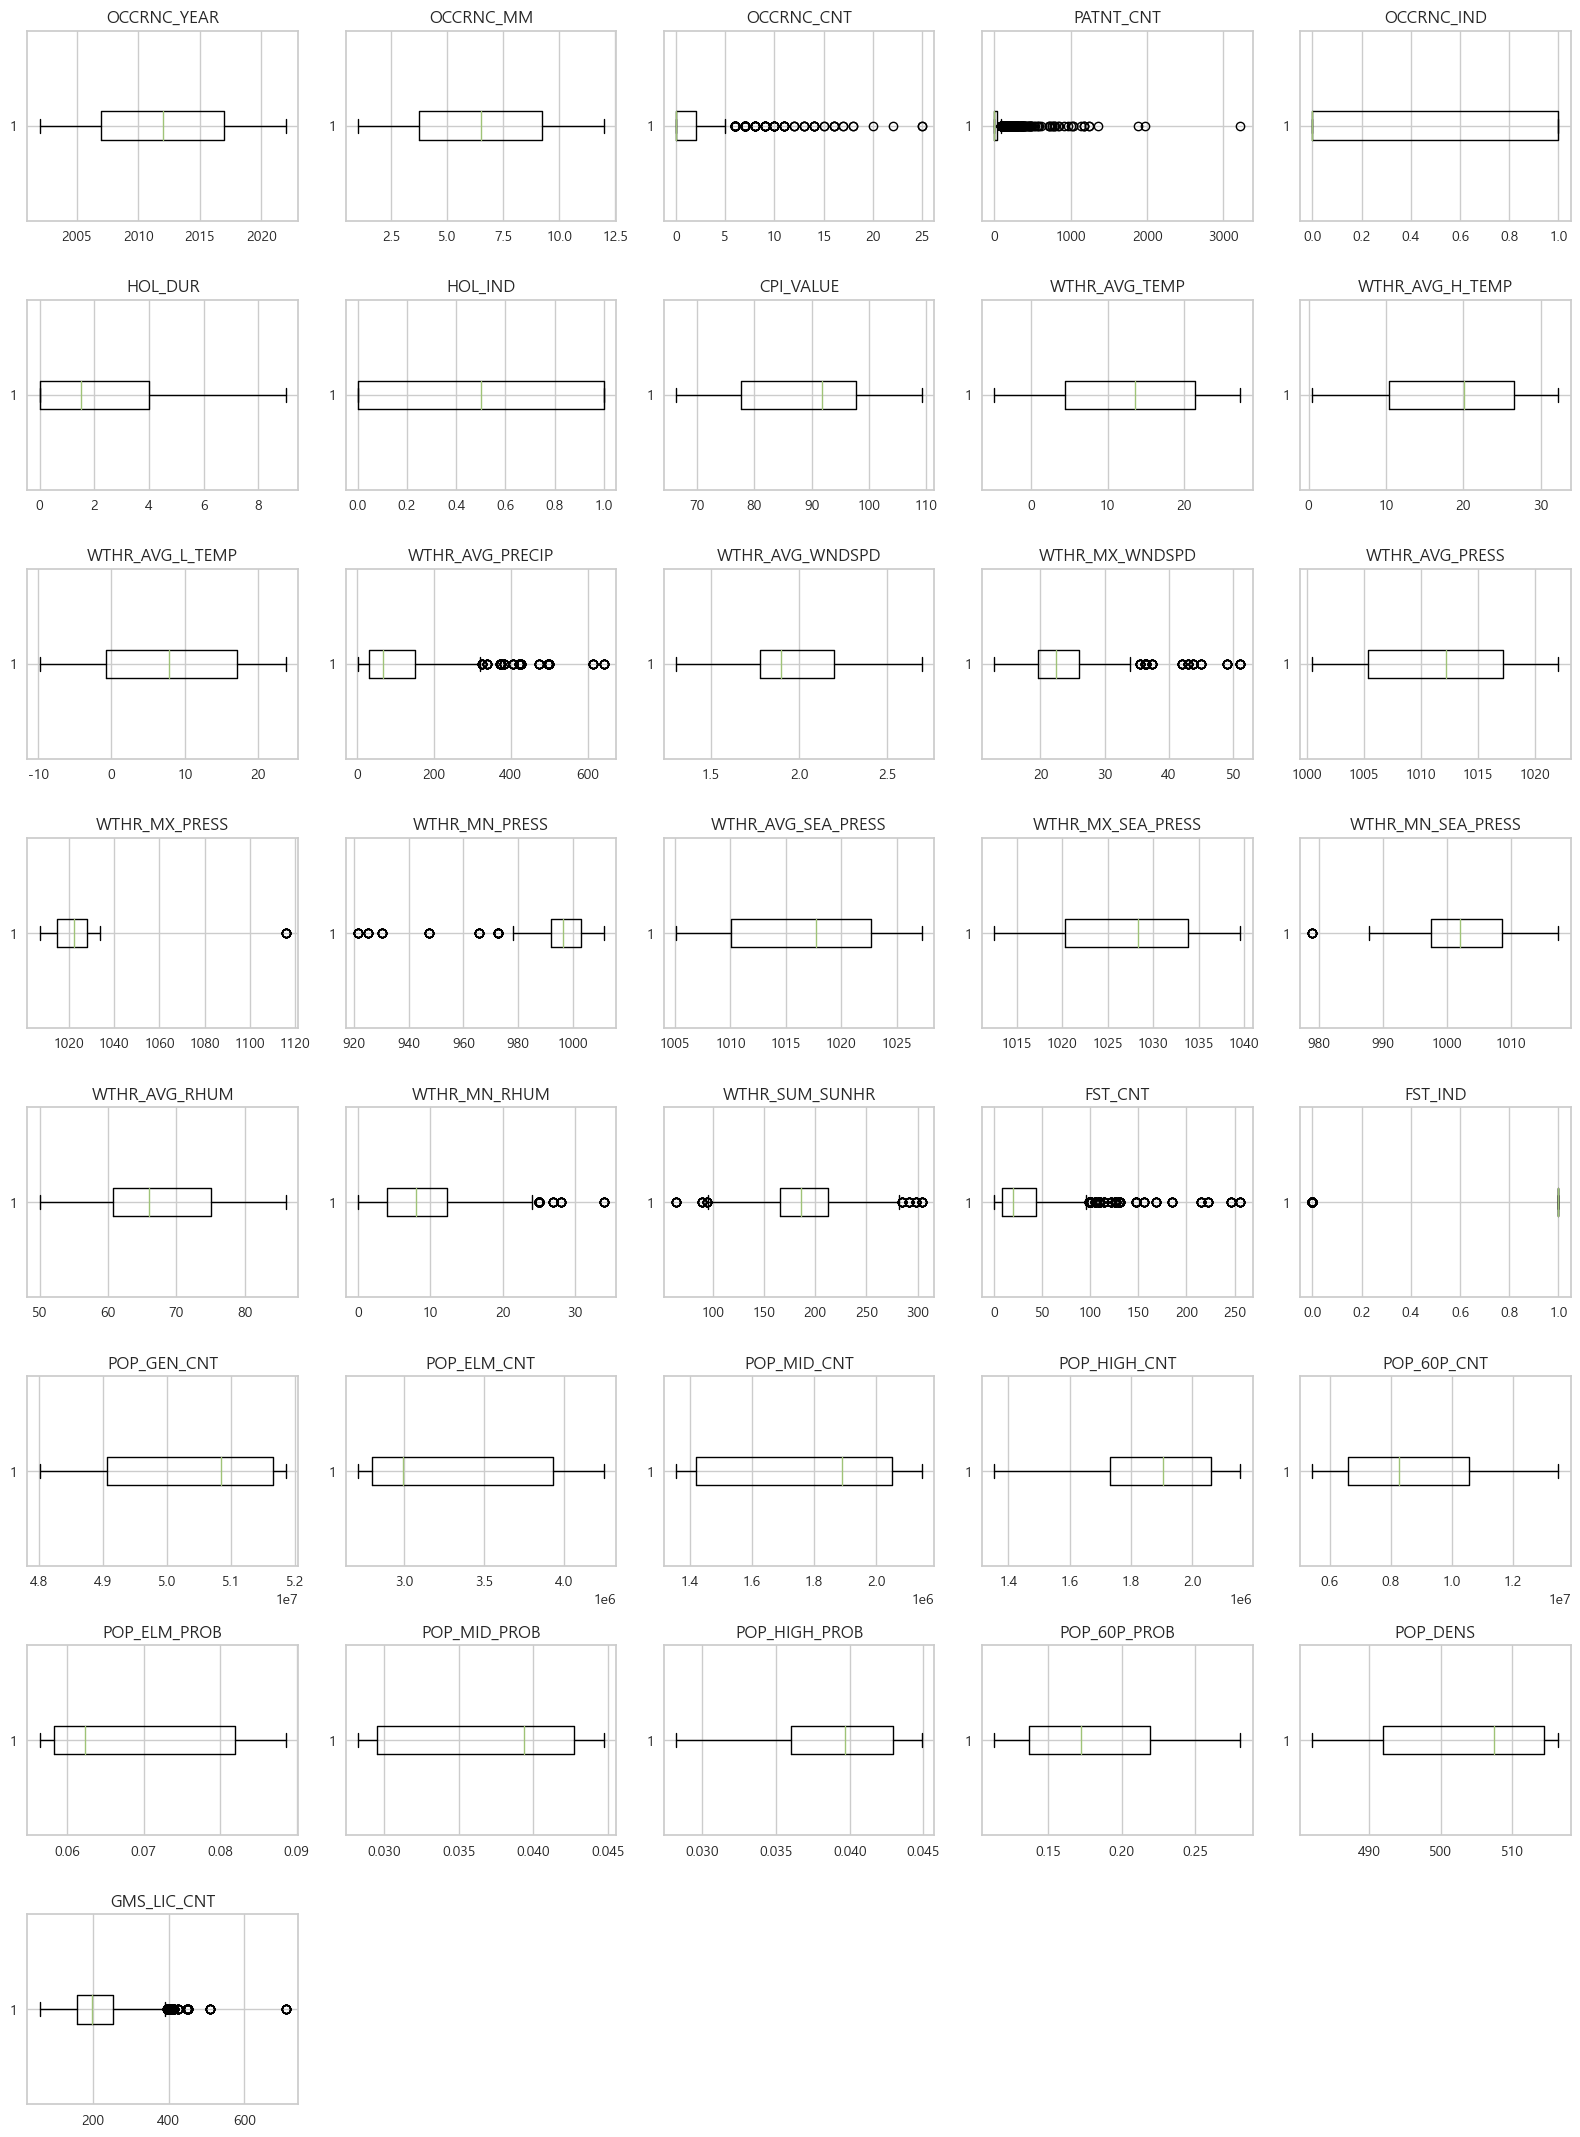

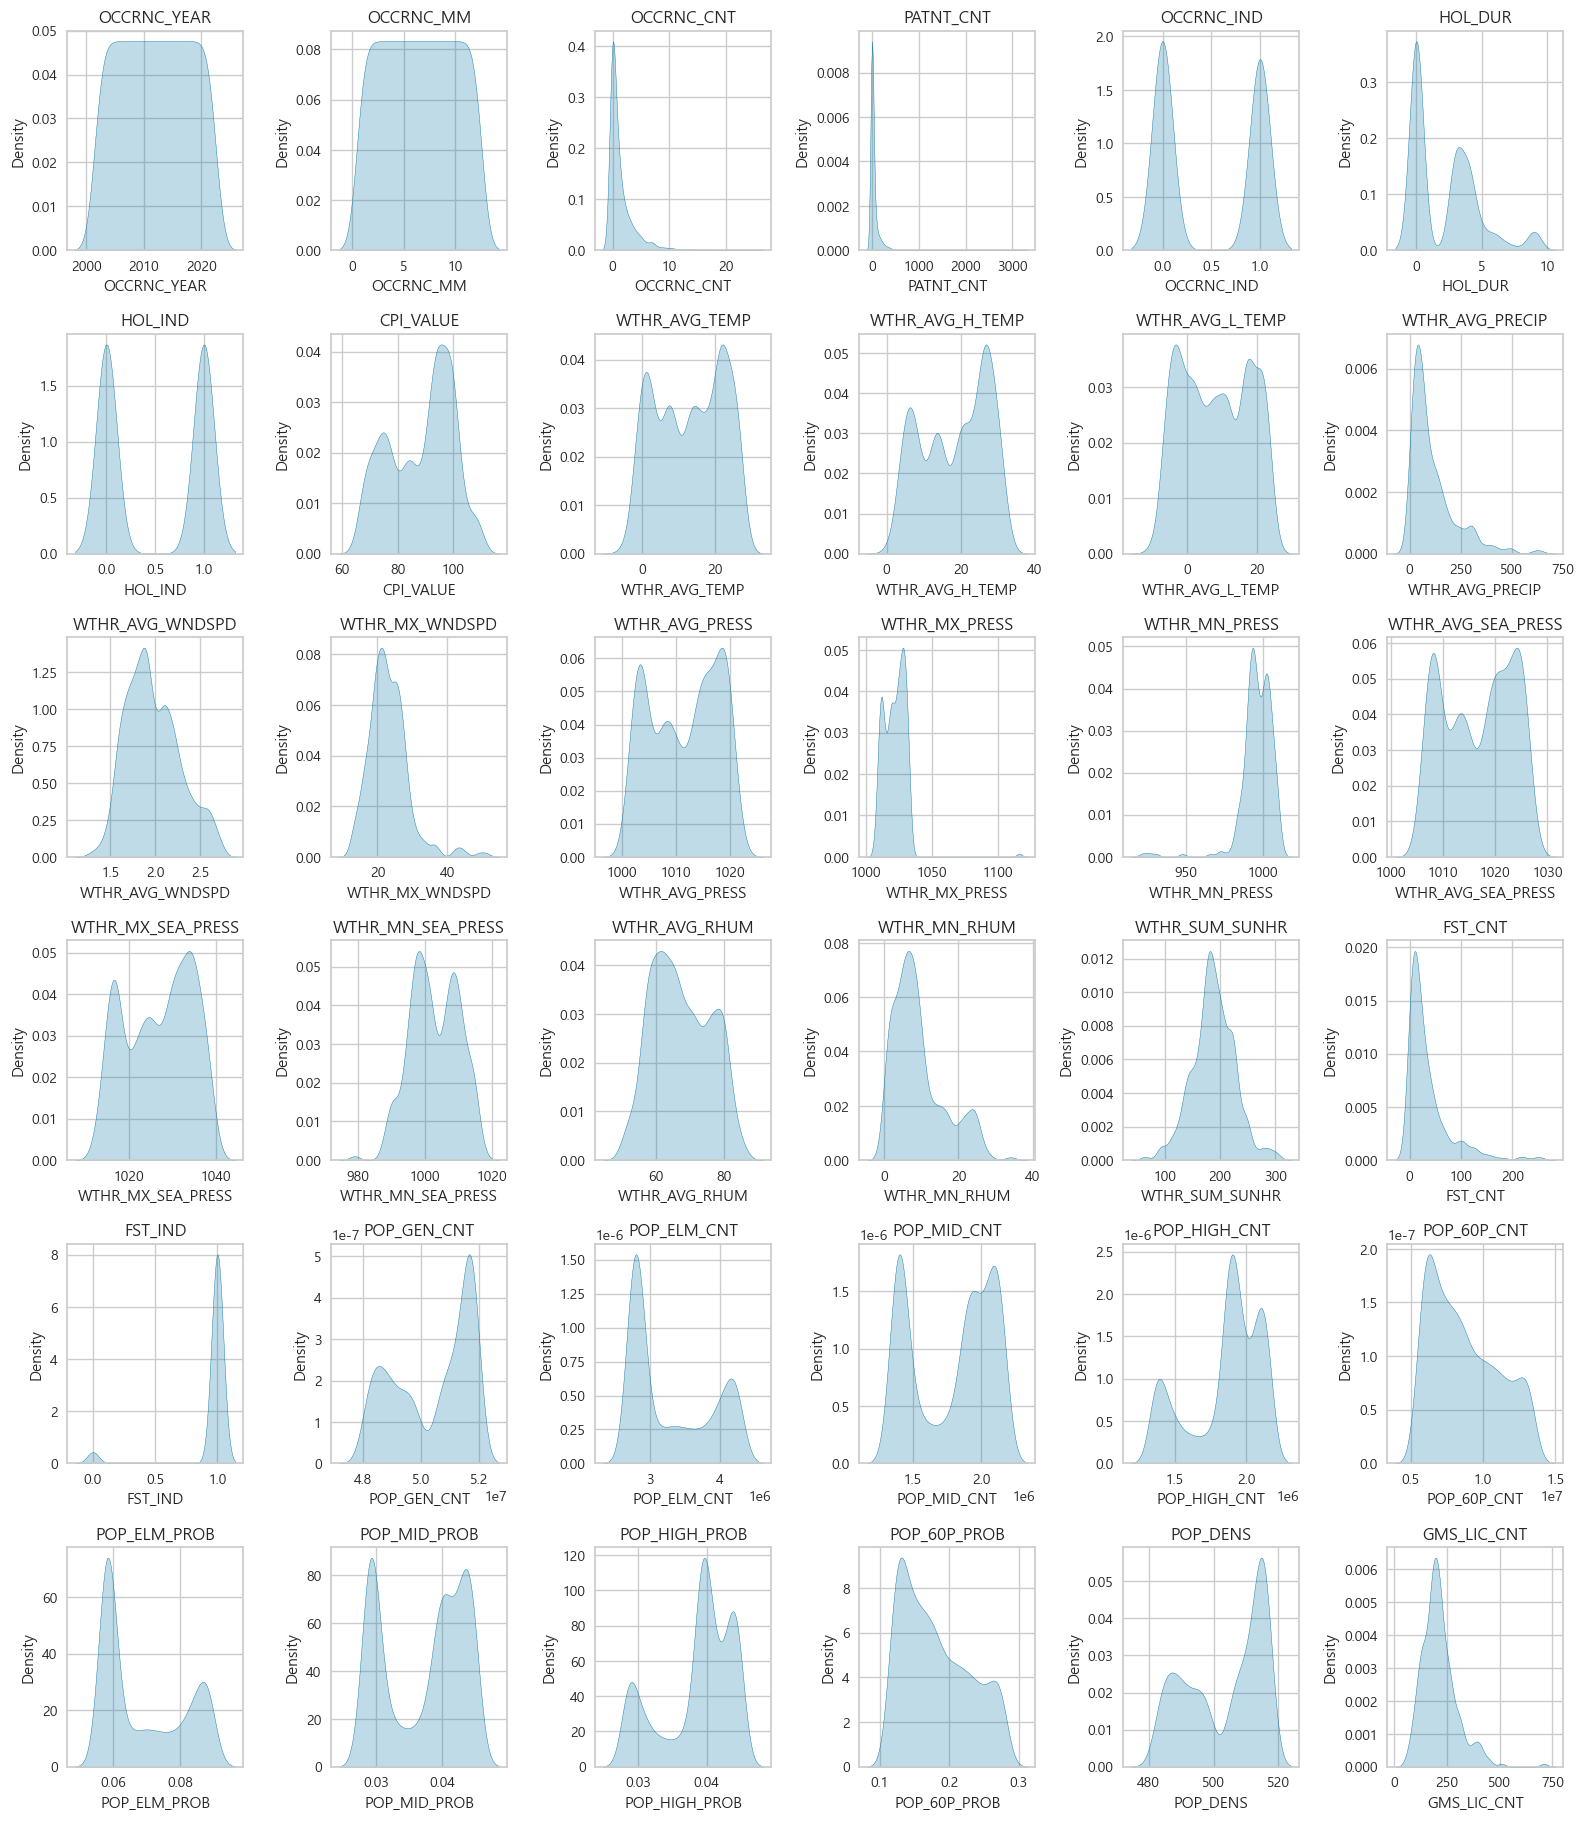

In [24]:
import matplotlib.pyplot as plt

# 변수별 분포 확인을 위한 히스토그램
plt.figure(figsize=(16, 24))
for i, col in enumerate(df2.columns, 1):
    plt.subplot(7, 6, i)
    plt.hist(df2[col].dropna(), bins=20, color='blue', edgecolor='black', alpha=0.7)
    plt.title(col)
plt.tight_layout()
plt.show()

# 박스플롯을 통한 이상치 시각화
plt.figure(figsize=(16, 24))
numeric_columns = df2.select_dtypes(include=[np.number]).columns  # 수치형 컬럼 선택
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(9, 5, i)
    plt.boxplot(df2[col].dropna(), vert=False)
    plt.title(col)
plt.tight_layout()
plt.show()

# 타겟 변수를 포함한 전체 변수의 밀도그래프
plt.figure(figsize=(16, 24))
for idx, col in enumerate(numeric_columns):
    if col in df2.columns:  # 컬럼이 존재하는지 확인
        plt.subplot(8, 6, idx + 1)
        ax = sns.kdeplot(df2[col], shade=True)
        plt.title(f'{col}')
plt.tight_layout()
plt.show()

# **Ⅳ. Master Table EDA**

## **1. 전체 통계**

In [25]:
region_df = pd.read_csv('Foodborne_Region_MasterTable.csv')
cause_df = pd.read_csv('Foodborne_Cause_MasterTable4.csv')

### 1. 연도별 발생건수 및 환자수_바 차트

In [26]:
def plot_dual_axis(data, x_column, y1_column, y2_column, x_label, y1_label, y2_label, title, bar_color, line_color, bg_color):

    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 그래프 배경 색 지정
    fig.patch.set_facecolor(bg_color)
    ax1.set_facecolor(bg_color)

    # 데이터 그룹화
    grouped_data = data.groupby(x_column).sum()

    # 첫 번째 축 - 발생 건수 (막대 그래프)
    bars = ax1.bar(grouped_data.index, grouped_data[y1_column], color=bar_color, label='Occurrence Count')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=bar_color)
    ax1.tick_params(axis='y', labelcolor=bar_color)
    ax1.set_ylim(0, 1500)     # y축 범위 설정
    ax1.set_yticks(range(0,1501, 100))       # y축 눈금 가격 설정

    # 막대 그래프에 값 라벨 추가
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3.5),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # 두 번째 축 - 환자 수 (선 그래프)
    ax2 = ax1.twinx()
    lines = ax2.plot(grouped_data.index, grouped_data[y2_column], color=line_color, marker='o', label='Patient Count')
    ax2.set_ylabel(y2_label, color=line_color)
    ax2.tick_params(axis='y', labelcolor=line_color)
    ax2.set_ylim(0, 12000)     # y축 범위 설정
    ax2.set_yticks(range(0,12001, 1000))       # y축 눈금 가격 설정

    # 선 그래프에 값 라벨 추가
    for i, txt in enumerate(grouped_data[y2_column]):
        ax2.annotate(f'{int(txt)}', (grouped_data.index[i], txt),
                    textcoords="offset points", xytext=(-5, 0),  # 왼쪽에 간격을 둠
                    ha='right', color=line_color)  # 왼쪽 정렬

    plt.title(title)
    fig.tight_layout()
    plt.show()

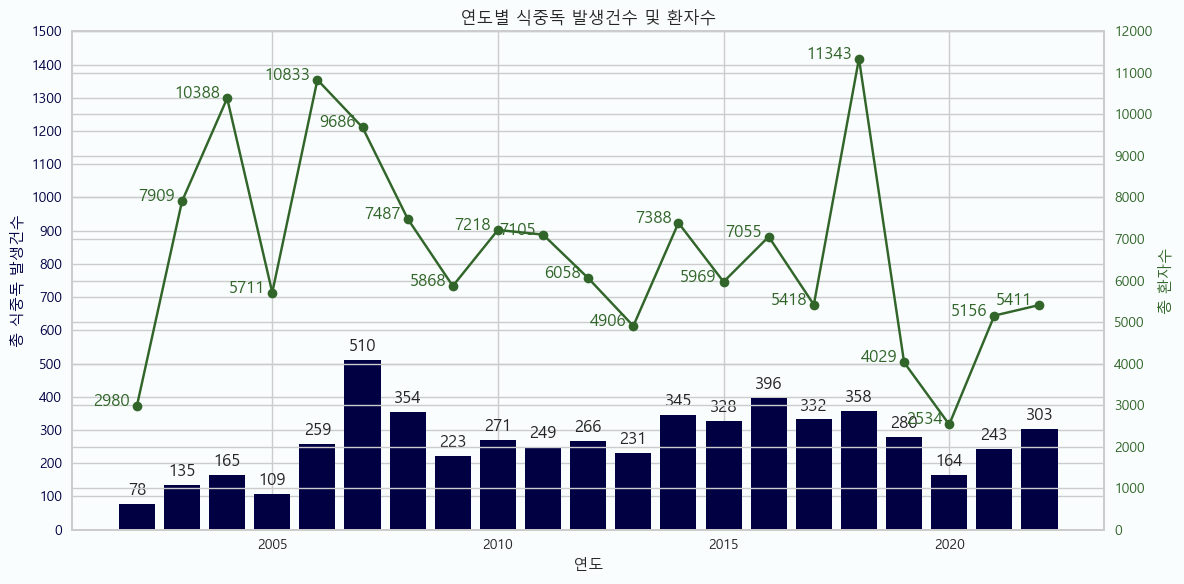

In [27]:
# 연도별 발생 건수와 환자 수 시각화
plot_dual_axis(
    data=region_df,
    x_column='OCCRNC_YEAR',
    y1_column='OCCRNC_CNT',
    y2_column='PATNT_CNT',
    x_label='연도',
    y1_label='총 식중독 발생건수',
    y2_label='총 환자수',
    title='연도별 식중독 발생건수 및 환자수',
    bar_color='#000043',
    line_color='#31652a',
    bg_color = '#FAFDFD'        # 그래프 배경 색상
    )


In [28]:
old_value = 4029  # 2019 환자 수
new_value = 2543  # 2020 환자 수

# 2019년 대비 2020년 증감
percentage_decrease = ((old_value - new_value) / old_value) * 100
print(f"2019년 대비 2020년 환자 수 증감: {percentage_decrease:.2f}%")
print('='*30)

patient_counts_5_years = [5418,11343,4029, 2534, 5156, 5411]  # 최근 5년 환자 수 (2017,2019,2020,2021,2022)
average_5_years = sum(patient_counts_5_years) / len(patient_counts_5_years)
percentage_difference_avg = ((average_5_years - new_value) / average_5_years) * 100
print(f"최근 5년간 평균 환자 수: {average_5_years:.2f}명")
print(f"2020년 환자 수와 5년 평균의 차이: {percentage_difference_avg:.2f}%")

2019년 대비 2020년 환자 수 증감: 36.88%
최근 5년간 평균 환자 수: 5648.50명
2020년 환자 수와 5년 평균의 차이: 54.98%


### 2. 연도별 식중독 발생건수 대비 환자수

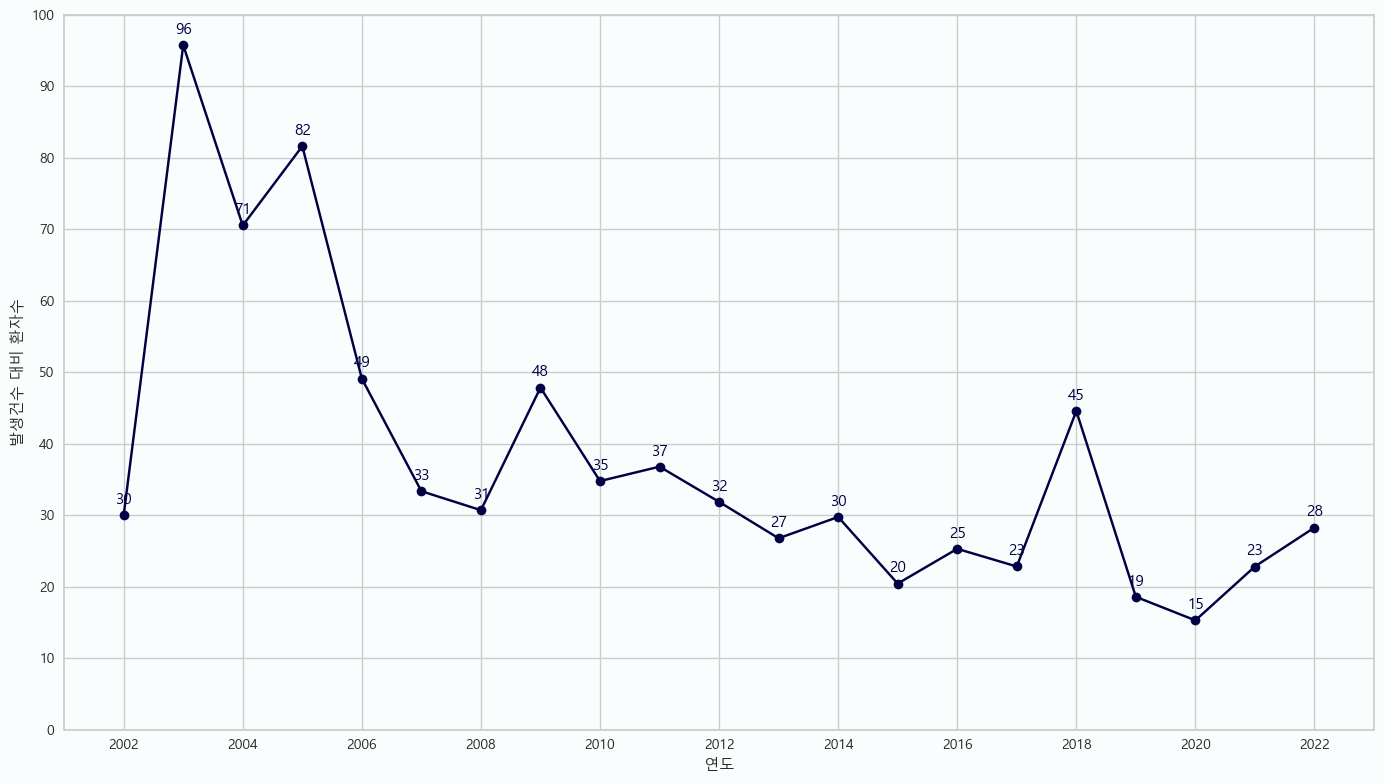

In [29]:
# 연도별 원인물질별 발생 건수와 환자 수 집계
yearly_pathogen_summary = cause_df.groupby(['OCCRNC_YEAR', 'OCCRNC_VIRS']).agg({'OCCRNC_CNT': 'sum', 'PATNT_CNT': 'sum'})

# 발생 건수 대비 환자 수 비율 계산
yearly_pathogen_summary['발생건수_대비_환자수'] = yearly_pathogen_summary['PATNT_CNT'] / yearly_pathogen_summary['OCCRNC_CNT']

# 연도별 발생 건수 대비 환자 수 비율의 연평균 계산
average_yearly_pathogen_summary = yearly_pathogen_summary.groupby('OCCRNC_YEAR')['발생건수_대비_환자수'].mean()

# 연평균 원인물질별 발생 건수 대비 환자 수 비율 시각화
plt.figure(figsize=(14, 8))

# 그래프 외부 배경색 설정
plt.gcf().patch.set_facecolor('#FAFDFD')
# 그래프 내부 배경색 설정
ax = plt.gca()
ax.set_facecolor('#FAFDFD')

plt.plot(average_yearly_pathogen_summary.index, average_yearly_pathogen_summary, marker='o', color='#000043', linestyle='-')

# y축 범위와 tick 설정
plt.ylim(0, 100)  # y축 범위 설정
plt.yticks(range(0, 101, 10))  # y축 tick 단위 설정

plt.xlim(2001, 2023)  # x축 범위 설정
plt.xticks(range(2002, 2023, 2))  # x축 tick 단위 설정

# 각 포인트에 수치값 표시
for x, y in zip(average_yearly_pathogen_summary.index, average_yearly_pathogen_summary):
    plt.text(x, y + 1, f'{y:.0f}', ha='center', va='bottom', fontsize=11, color='#000043')  # 값 표시 (y + 1로 위쪽에 위치)



#plt.title('연도별 발생 건수 대비 환자 수 비율의 연평균 변화')
plt.xlabel('연도')
plt.ylabel('발생건수 대비 환자수')
#plt.legend(title='비율')
plt.grid(True)
plt.tight_layout()
plt.show()


### 3. 원인물질별 식중독 발생건수 대비 환자수

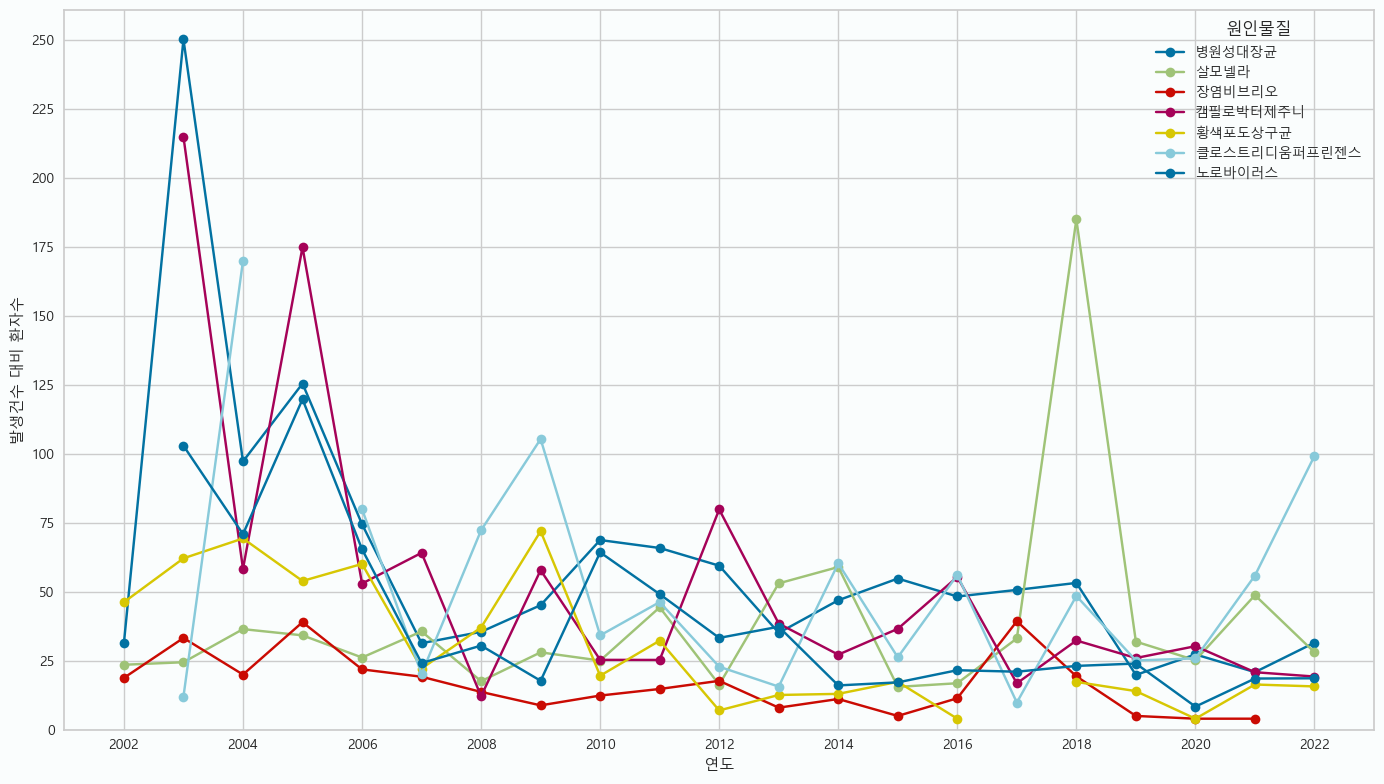

In [30]:
pathogen_list = ['병원성대장균', '살모넬라', '장염비브리오', '캠필로박터제주니', '황색포도상구균', '클로스트리디움퍼프린젠스', '노로바이러스']

# 연도별 원인물질별 발생 건수와 환자 수 집계
yearly_pathogen_summary = cause_df.groupby(['OCCRNC_YEAR', 'OCCRNC_VIRS']).agg({'OCCRNC_CNT': 'sum', 'PATNT_CNT': 'sum'})

# 발생 건수 대비 환자 수 비율 계산
yearly_pathogen_summary['발생건수/환자수 비율'] = yearly_pathogen_summary['PATNT_CNT'] / yearly_pathogen_summary['OCCRNC_CNT']

# 연도별 원인물질별 발생 건수 대비 환자 수 비율 변화 시각화
plt.figure(figsize=(14, 8))

# 그래프 외부 배경색 설정
plt.gcf().patch.set_facecolor('#FAFDFD')
# 그래프 내부 배경색 설정
ax = plt.gca()
ax.set_facecolor('#FAFDFD')

for pathogen in pathogen_list:
    plt.plot(yearly_pathogen_summary.loc[(slice(None), pathogen), :].index.get_level_values('OCCRNC_YEAR'),
            yearly_pathogen_summary.loc[(slice(None), pathogen), '발생건수/환자수 비율'],
            marker='o', label=pathogen)

plt.ylim(0, 261)  # y축 범위 설정
plt.yticks(range(0, 261, 25))  # y축 tick 단위 설정

plt.xlim(2001, 2023)  # x축 범위 설정
plt.xticks(range(2002, 2023, 2))  # x축 tick 단위 설정

#plt.title('연도별 원인물질별 발생 건수 대비 환자 수 비율 변화')
plt.xlabel('연도')
plt.ylabel('발생건수 대비 환자수')
plt.legend(title='원인물질')
plt.grid(True)
plt.tight_layout()
plt.show()


## **2. 원인 물질별 식중독 발생 분석**

### 1. 원인물질별 발생건수 파이차트

In [31]:
def cause_analysis_pie(cause_df, cause_col, occurrence_col):
    cause_summary = cause_df.groupby(cause_col)[[occurrence_col]].sum().sort_values(by=occurrence_col, ascending=False)

    # 데이터 및 비율 계산
    total_occurrences = cause_summary[occurrence_col].sum()
    cause_summary['percent'] = cause_summary[occurrence_col] / total_occurrences * 100

    labels = cause_summary.index
    sizes = cause_summary[occurrence_col]

    pastel_colors = ['#393C78','#63793C','#8B6D35','#833B3A','#7A4172','#5355A1','#8CA256','#BC9D40','#AC484C','#A45193','#6C6FCD','#B5CF6F','#E6B959','#D4606C','#CD6DBC','#9C9EDC','#CEDB9E','#E6CB96','#E6969D','#DD9ED5']
    # "tab20b" 팔레트에서 상위 5개 색상 선택
    #tab20b_colors = plt.cm.get_cmap('tab20b', 14)  # 5개의 색상 추출
    #pastel_colors = [f'#{int(r*255):02X}{int(g*255):02X}{int(b*255):02X}' for r, g, b, _ in tab20b_colors.colors]

    # Plotly 파이 차트 생성
    fig = go.Figure(
        data=[go.Pie(  
            labels=labels,
            values=sizes,
            hole=0,  
            textinfo='percent+label',  
            insidetextorientation='horizontal', 
            marker=dict(colors=pastel_colors[:len(labels)], line=dict(color='#FAFDFD', width=3)),
            sort = False,
            rotation=90,
            direction='clockwise',
            #direction='counterclockwise',
            showlegend=False
        )]
    )

    # 차트 레이아웃 설정
    fig.update_layout(
        # title={
        #     'text': "원인 물질별 식중독 발생 건수 비율",
        #     'x': 0.5,  
        #     'xanchor': 'center',
        #     'yanchor': 'top'
        # },
        font=dict(size=14, family='Arial', color='black'),
        annotations=[], 
        width=800,  
        height=800,
        paper_bgcolor='#FAFDFD',
        legend=dict(
            font=dict(size=14, family='Arial', weight='bold')
        )
    )
    
    fig.show()

In [32]:
cause_analysis_pie(cause_df, 'OCCRNC_VIRS', 'OCCRNC_CNT')

### 2. 식중독 유발 순위 및 누적 비율

In [33]:
# 원인별 환자 수 및 발생 건수를 요약
cause_summary = cause_df.groupby('OCCRNC_VIRS')[['OCCRNC_CNT']].sum().sort_values(by='OCCRNC_CNT', ascending=False)

# 데이터 및 비율 계산
total_occurrences = cause_summary['OCCRNC_CNT'].sum()
cause_summary['percent'] = cause_summary['OCCRNC_CNT'] / total_occurrences * 100
cause_summary['cumulative_percent'] = cause_summary['percent'].cumsum()

cause_summary


OCCRNC_CNT    percent  cumulative_percent
OCCRNC_VIRS                                            
노로바이러스               880  26.960784           26.960784
병원성대장균               678  20.772059           47.732843
살모넬라                 475  14.552696           62.285539
장염비브리오               265   8.118873           70.404412
황색포도상구균              234   7.169118           77.573529
캠필로박터제주니             214   6.556373           84.129902
원충                   196   6.004902           90.134804
클로스트리디움퍼프린젠스         191   5.851716           95.986520
바실러스세레우스             131   4.013480          100.000000

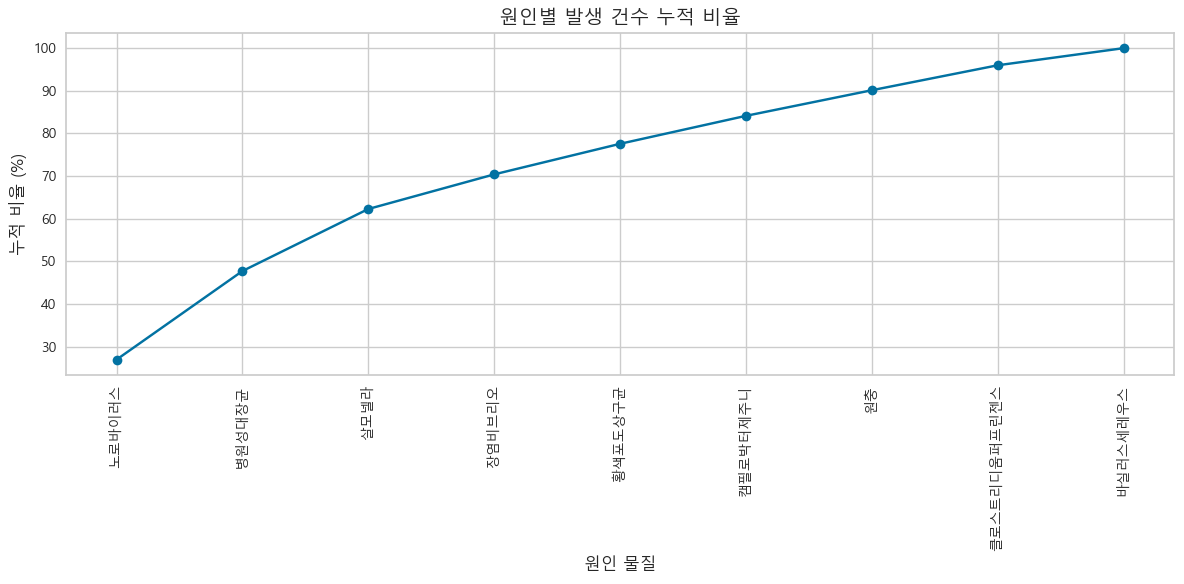

In [34]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(cause_summary.index, cause_summary['cumulative_percent'], marker='o', linestyle='-', color='b')

# 그래프 레이블 및 제목 설정
plt.title('원인별 발생 건수 누적 비율', fontsize=14)
plt.xlabel('원인 물질', fontsize=12)
plt.ylabel('누적 비율 (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(True)

# 그래프 보여주기
plt.tight_layout()
plt.show()

### 3. Sorted 원인물질별 발생건수 파이차트 (원인불명, 1% 미만 제외)

In [35]:
def cause_analysis_pie(cause_df, cause_col, occurrence_col):
    cause_summary = cause_df.groupby(cause_col)[[occurrence_col]].sum().sort_values(by=occurrence_col, ascending=False)

    # 데이터 및 비율 계산
    total_occurrences = cause_summary[occurrence_col].sum()
    cause_summary['percent'] = cause_summary[occurrence_col] / total_occurrences * 100

    labels = cause_summary.index
    sizes = cause_summary[occurrence_col]

    #pastel_colors = ['#393C78','#63793C','#8B6D35','#833B3A','#7A4172','#5355A1','#8CA256','#BC9D40','#AC484C','#A45193','#6C6FCD','#B5CF6F','#E6B959','#D4606C','#CD6DBC','#9C9EDC','#CEDB9E','#E6CB96','#E6969D','#DD9ED5']
    pastel_colors = ['#63793C','#8B6D35','#833B3A','#7A4172','#5355A1','#8CA256','#BC9D40','#AC484C','#A45193']
    # "tab20b" 팔레트에서 상위 5개 색상 선택
    #tab20b_colors = plt.cm.get_cmap('tab20b', 14)  # 5개의 색상 추출
    #pastel_colors = [f'#{int(r*255):02X}{int(g*255):02X}{int(b*255):02X}' for r, g, b, _ in tab20b_colors.colors]

    # Plotly 파이 차트 생성
    fig = go.Figure(
        data=[go.Pie(  
            labels=labels,
            values=sizes,
            hole=0,  
            textinfo='percent+label',  
            insidetextorientation='horizontal', 
            marker=dict(colors=pastel_colors[:len(labels)], line=dict(color='#FAFDFD', width=3)),
            sort = False,
            rotation=90,
            direction='clockwise',
            #direction='counterclockwise',
            showlegend=False
        )]
    )

    # 차트 레이아웃 설정
    fig.update_layout(
        # title={
        #     'text': "원인 물질별 식중독 발생 건수 비율",
        #     'x': 0.5,  
        #     'xanchor': 'center',
        #     'yanchor': 'top'
        # },
        font=dict(size=14, family='Arial'),
        annotations=[], 
        width=800,  
        height=800,
        paper_bgcolor='#FAFDFD',
        legend=dict(
            font=dict(size=14, family='Arial', weight='bold')
        )
    )
    
    fig.show()

In [36]:
cause_analysis_pie(cause_df, 'OCCRNC_VIRS', 'OCCRNC_CNT')

### 4. 원인 물질별 발생 건수 대비 환자 수 비율

#### 1) 원인물질 전체

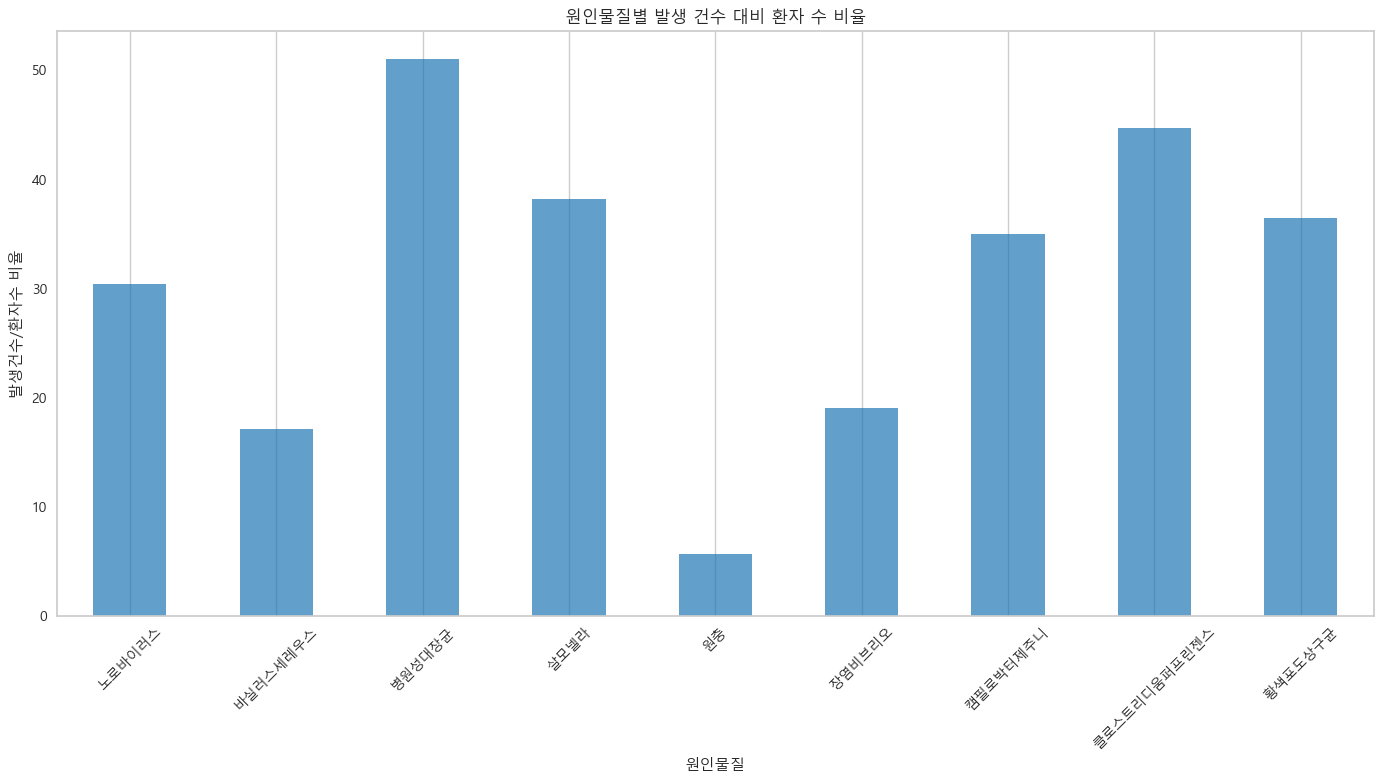

In [37]:
# 원인물질별별 발생 건수와 환자 수 집계
pathogen_summary = cause_df.groupby('OCCRNC_VIRS').agg({'OCCRNC_CNT': 'sum', 'PATNT_CNT': 'sum'})

# 발생 건수 대비 환자 수 비율 계산
pathogen_summary['발생건수/환자수 비율'] = pathogen_summary['PATNT_CNT'] / pathogen_summary['OCCRNC_CNT']

# 비율 시각화
plt.figure(figsize=(14, 8))
pathogen_summary['발생건수/환자수 비율'].plot(kind='bar', color='#1f77b4', alpha=0.7)
plt.title('원인물질별 발생 건수 대비 환자 수 비율')
plt.xlabel('원인물질')
plt.ylabel('발생건수/환자수 비율')
plt.xticks(rotation=45, ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### 2) Sorted 원인물질

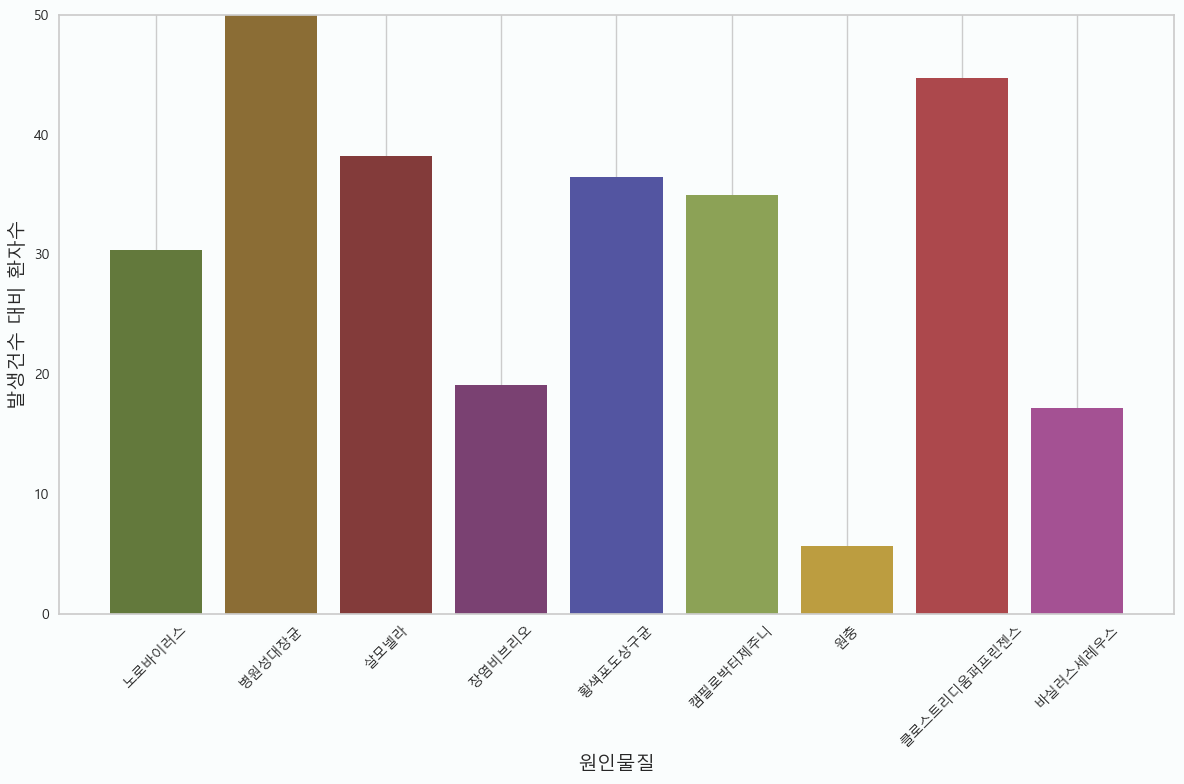

In [38]:
selected_pathogens = [
    '노로바이러스','병원성대장균','살모넬라','장염비브리오',
    '황색포도상구균','캠필로박터제주니','원충','클로스트리디움퍼프린젠스','바실러스세레우스'
    ]

# 원인물질별별 발생 건수와 환자 수 집계
pathogen_summary = cause_df.groupby('OCCRNC_VIRS').agg({'OCCRNC_CNT': 'sum', 'PATNT_CNT': 'sum'})

# 발생 건수 대비 환자 수 비율 계산
pathogen_summary['발생건수/환자수 비율'] = pathogen_summary['PATNT_CNT'] / pathogen_summary['OCCRNC_CNT']
filtered_pathogen_summary = pathogen_summary.loc[selected_pathogens]

colors = {
    '노로바이러스': '#63793C',
    '병원성대장균': '#8B6D35',
    '살모넬라': '#833B3A',
    '장염비브리오': '#7A4172',
    '황색포도상구균': '#5355A1',
    '캠필로박터제주니': '#8CA256',
    '원충': '#BC9D40',
    '클로스트리디움퍼프린젠스': '#AC484C',
    '바실러스세레우스': '#A45193'
}

plt.figure(figsize=(12, 8))
plt.gcf().patch.set_facecolor('#FAFDFD')

plt.bar(
    filtered_pathogen_summary.index,  # x축: 원인물질
    filtered_pathogen_summary['발생건수/환자수 비율'],  # y축: 발생건수 대비 환자수 비율
    color=[colors[pathogen] for pathogen in filtered_pathogen_summary.index]  # 각 항목별 색상 지정
)

# y축 범위와 tick 설정
plt.ylim(0, 50)  # y축 범위 설정
plt.yticks(range(0, 51, 10))  # y축 tick 단위 설정

# 그래프 안쪽 배경 색상 설정
plt.gca().set_facecolor('#FAFDFD')

#plt.title('Top7 원인물질별 발생 건수 대비 환자 수 비율')
plt.xlabel('원인물질', fontsize=14)
plt.ylabel('발생건수 대비 환자수', fontsize=14)
plt.xticks(rotation=45, ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



### 5. 월별 원인 물질에 따른 식중독 발생건수 추이

#### 1) 2002~2022 총 식중독 발생건수

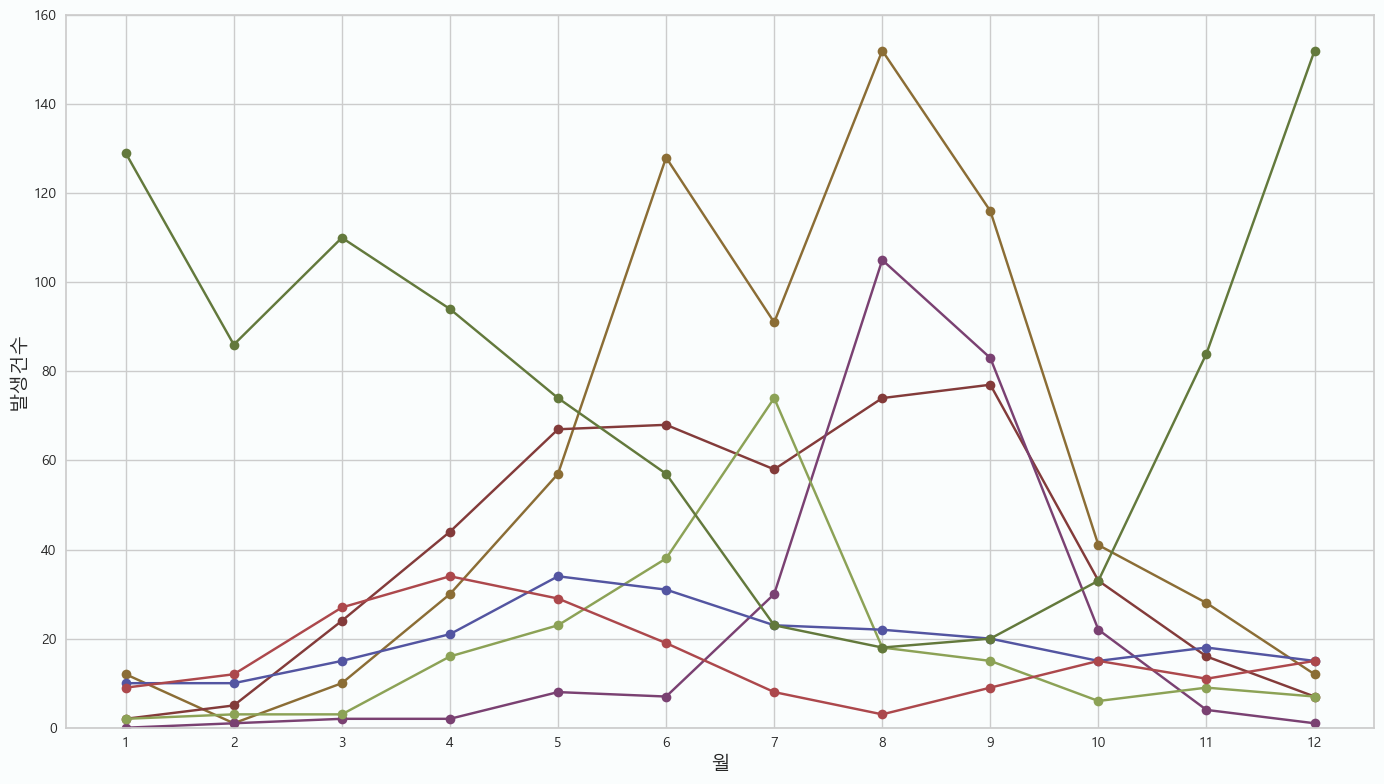

In [39]:
selected_pathogens = [
    '노로바이러스','병원성대장균','살모넬라','장염비브리오',
    '황색포도상구균','캠필로박터제주니','원충','클로스트리디움퍼프린젠스','바실러스세레우스'
    ]

cause_df2 = cause_df[cause_df['OCCRNC_VIRS'].isin(pathogen_list)]

# 월별 원인물질별 발생 건수 추이
monthly_trend = cause_df2.groupby(['OCCRNC_MM', 'OCCRNC_VIRS'])['OCCRNC_CNT'].sum().unstack()

colors = {
    '노로바이러스': '#63793C',
    '병원성대장균': '#8B6D35',
    '살모넬라': '#833B3A',
    '장염비브리오': '#7A4172',
    '황색포도상구균': '#5355A1',
    '캠필로박터제주니': '#8CA256',
    '원충': '#BC9D40',
    '클로스트리디움퍼프린젠스': '#AC484C',
    '바실러스세레우스': '#A45193'
}


# 월별 발생 건수 그래프
plt.figure(figsize=(14, 8))
plt.gcf().patch.set_facecolor('#FAFDFD')

for pathogen in pathogen_list:
    plt.plot(
        monthly_trend.index,  # 월
        monthly_trend[pathogen],  # 각 월별 발생 건수
        marker='o',
        label=pathogen,
        color=colors[pathogen]  # 해당 항목의 색상 지정
    )

# y축 범위와 tick 설정
plt.ylim(0, 160)  # y축 범위 설정
plt.yticks(range(0, 161, 20))  # y축 tick 단위 설정

plt.xticks(range(1, 13, 1))  # 1부터 12까지 1 단위로 설정 (1월부터 12월까지)

#plt.title('원인물질별 월별 발생 건수 추이', fontsize=16)
plt.xlabel('월', fontsize=14)
plt.ylabel('발생건수', fontsize=14)

# Consistent legend placement
#plt.legend(title='원인물질', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True)
plt.gca().set_facecolor('#FAFDFD')

plt.tight_layout()
plt.show()

#### 2) 2002~2023 월 평균 발생건수

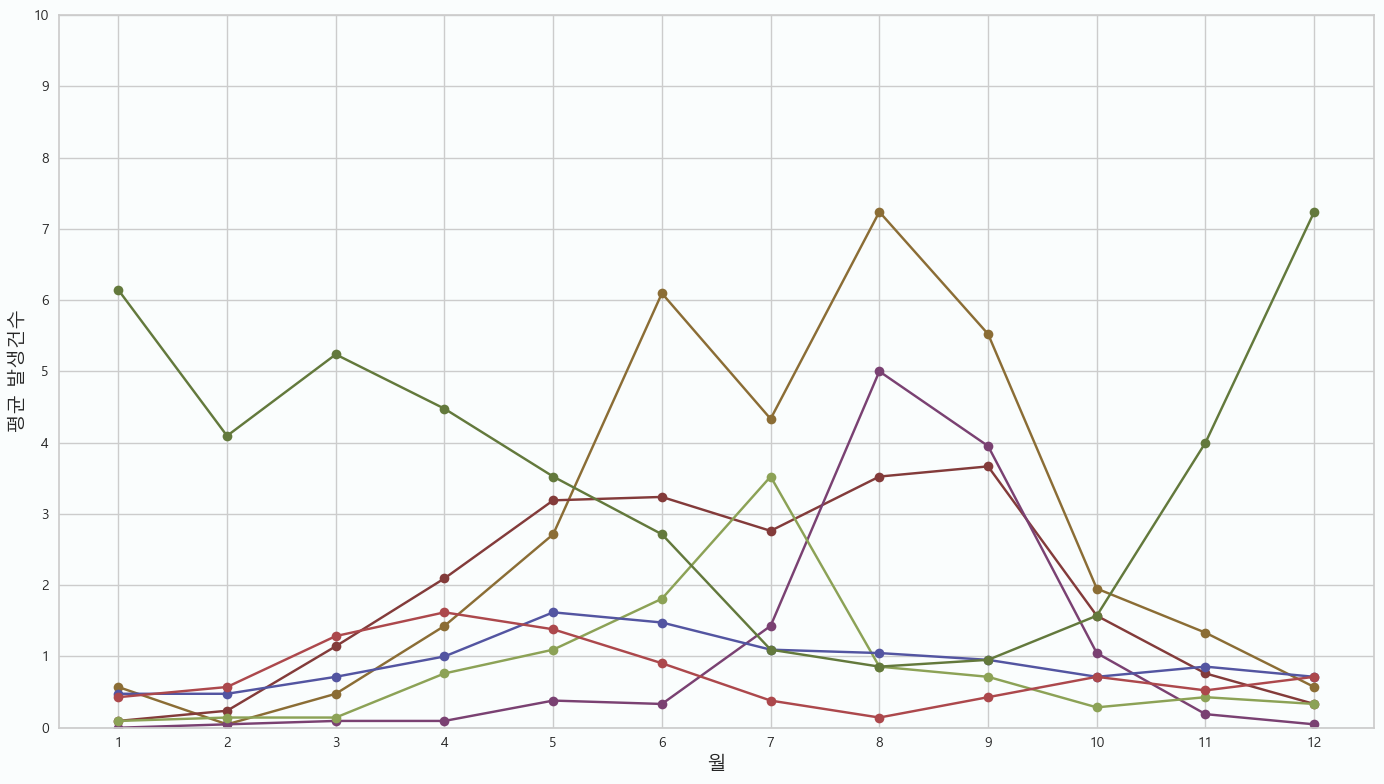

In [40]:
selected_pathogens = [
    '노로바이러스','병원성대장균','살모넬라','장염비브리오',
    '황색포도상구균','캠필로박터제주니','원충','클로스트리디움퍼프린젠스','바실러스세레우스'
    ]

cause_df2 = cause_df[cause_df['OCCRNC_VIRS'].isin(pathogen_list)]

# 월별 원인물질별 발생 건수 추이
monthly_trend = cause_df2.groupby(['OCCRNC_MM', 'OCCRNC_VIRS'])['OCCRNC_CNT'].mean().unstack()

colors = {
    '노로바이러스': '#63793C',
    '병원성대장균': '#8B6D35',
    '살모넬라': '#833B3A',
    '장염비브리오': '#7A4172',
    '황색포도상구균': '#5355A1',
    '캠필로박터제주니': '#8CA256',
    '원충': '#BC9D40',
    '클로스트리디움퍼프린젠스': '#AC484C',
    '바실러스세레우스': '#A45193'
}

# 월별 발생 건수 그래프
plt.figure(figsize=(14, 8))
plt.gcf().patch.set_facecolor('#FAFDFD')

for pathogen in pathogen_list:
    plt.plot(
        monthly_trend.index,  # 월
        monthly_trend[pathogen],  # 각 월별 발생 건수
        marker='o',
        label=pathogen,
        color=colors[pathogen]  # 해당 항목의 색상 지정
    )

# y축 범위와 tick 설정
plt.ylim(0, 10)  # y축 범위 설정
plt.yticks(range(0, 11, 1))  # y축 tick 단위 설정

plt.xticks(range(1, 13, 1))  # 1부터 12까지 1 단위로 설정 (1월부터 12월까지)

#plt.title('원인물질별 월별 발생 건수 추이', fontsize=16)
plt.xlabel('월', fontsize=14)
plt.ylabel('평균 발생건수', fontsize=14)

# Consistent legend placement
#plt.legend(title='원인물질', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True)
plt.gca().set_facecolor('#FAFDFD')

plt.tight_layout()
plt.show()

## **3. 지역별 식중독 발생 분석**

### 1. 지역별 식중독 발생건수

In [41]:
def region_analysis_pie(region_df, region_col, occurrence_col):

    region_summary = region_df.groupby(region_col)[[occurrence_col]].sum().sort_values(by=occurrence_col, ascending=False)

    # 데이터 및 비율 계산
    total_occurrences = region_summary[occurrence_col].sum()
    region_summary['percent'] = region_summary[occurrence_col] / total_occurrences * 100

    labels = region_summary.index
    sizes = region_summary[occurrence_col]


    pastel_colors = ['#393C78','#63793C','#8B6D35','#833B3A','#7A4172','#5355A1','#8CA256','#BC9D40','#AC484C','#A45193','#6C6FCD','#B5CF6F','#E6B959','#D4606C','#CD6DBC','#9C9EDC','#CEDB9E','#E6CB96','#E6969D','#DD9ED5']


    fig = go.Figure(
        data=[go.Pie( 
            labels=labels,
            values=sizes,
            hole=0,  
            textinfo='percent+label', 
            insidetextorientation='horizontal', 
            marker=dict(colors=pastel_colors[:len(labels)], line=dict(color='#FAFDFD', width=3)),
            sort=False,
            rotation=90,
            direction='clockwise',
            # direction='counterclockwise',
            showlegend=True
        )]
    )

    fig.update_layout(
        # title={
        #     'text': "지역별 식중독 발생 건수 비율",
        #     'x': 0.5,  
        #     'xanchor': 'center',
        #     'yanchor': 'top'
        # },
        #font=dict(size=12, family='Arial', color='black'),
        annotations=[], 
        width=800,  
        height=800,
        paper_bgcolor='#FAFDFD',
        legend=dict(
            font=dict(size=14, family='Arial', weight='bold')
        )
    )

    textfont=dict(size=12, family='Arial', weight='bold'),   # 안쪽 텍스트 (퍼센트+레이블)
    outsidetextfont=dict(size=14, family='Arial', weight='bold')  # 바깥 텍스트 (레이블)

    fig.show()


In [42]:
region_analysis_pie(region_df, 'OCCRNC_REGN', 'OCCRNC_CNT')

### 2. 연도별 발생 건수

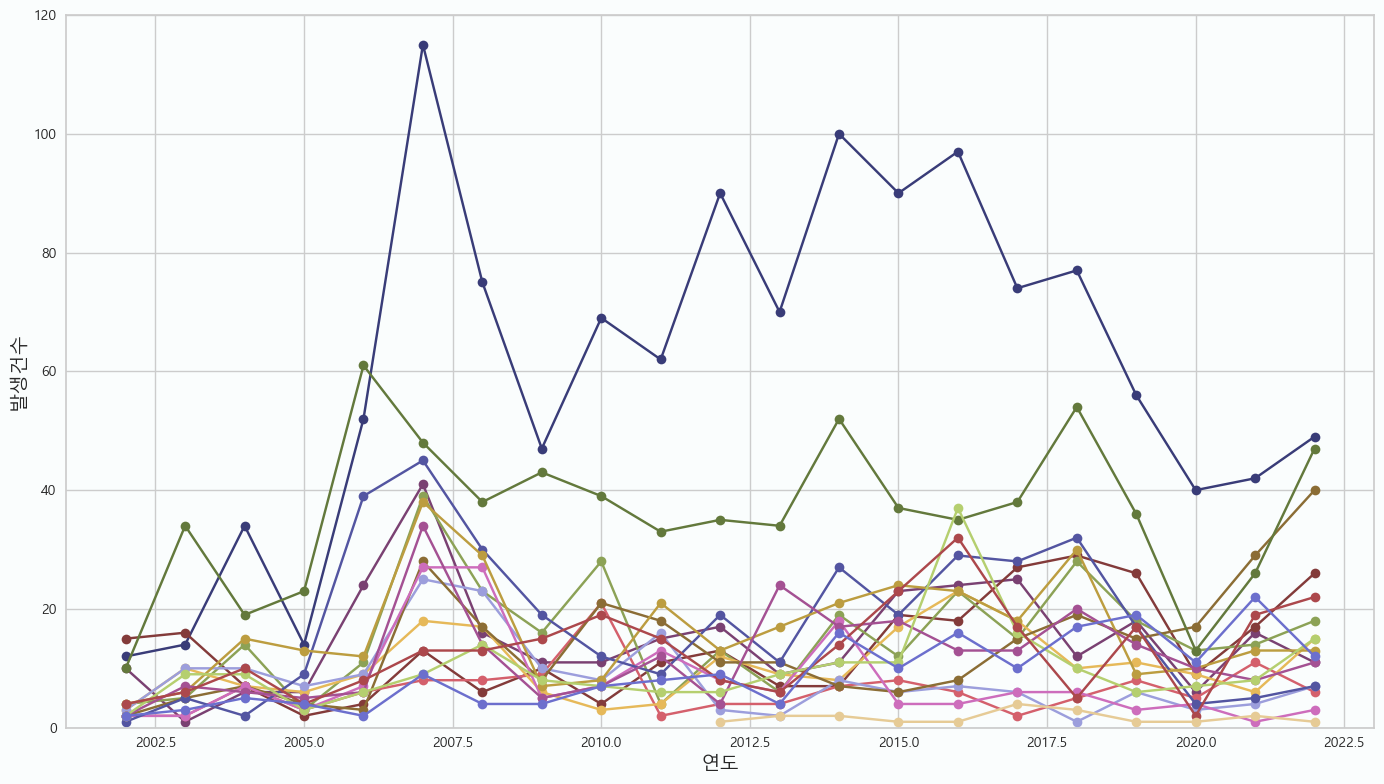

In [43]:
yearly_region_summary = region_df.groupby(['OCCRNC_YEAR', 'OCCRNC_REGN']).agg({'OCCRNC_CNT': 'sum', 'PATNT_CNT': 'sum'}).reset_index()

colors = {
    '경기' : '#393C78', '서울' : '#63793C', 
    '부산' : '#8B6D35', '경남' : '#833B3A', 
    '강원' : '#7A4172', '인천' : '#5355A1', 
    '경북' : '#8CA256', '전남' : '#BC9D40', 
    '충남' : '#AC484C', '전북' : '#A45193', 
    '충북' : '#6C6FCD', '제주' : '#B5CF6F', 
    '대구' : '#E6B959', '광주' : '#D4606C', 
    '울산' : '#CD6DBC', '대전' : '#9C9EDC', 
    '불명' : '#CEDB9E', '세종' : '#E6CB96'
    }


plt.figure(figsize=(14, 8))
plt.gcf().patch.set_facecolor('#FAFDFD')        # 그래프 외부 배경 색상 설정

for region in yearly_region_summary['OCCRNC_REGN'].unique():
    region_data = yearly_region_summary[yearly_region_summary['OCCRNC_REGN'] == region]
    plt.plot(
        region_data['OCCRNC_YEAR'], 
        region_data['OCCRNC_CNT'], 
        marker='o', 
        label=region,
        color=colors.get(region, '#000000') 
    )

#plt.title('연도별 지역별 발생 건수 변화')
plt.xlabel('연도', fontsize=14)
plt.ylabel('발생건수', fontsize=14)

#plt.legend(title='지역별', loc='upper left')
plt.grid(True)

# 그래프 안쪽 배경 색상 설정
plt.gca().set_facecolor('#FAFDFD')

# y축 범위와 tick 설정
plt.ylim(0, 120)  # y축 범위 설정
plt.yticks(range(0, 121, 20))  # y축 tick 단위 설정

plt.tight_layout()
plt.show()


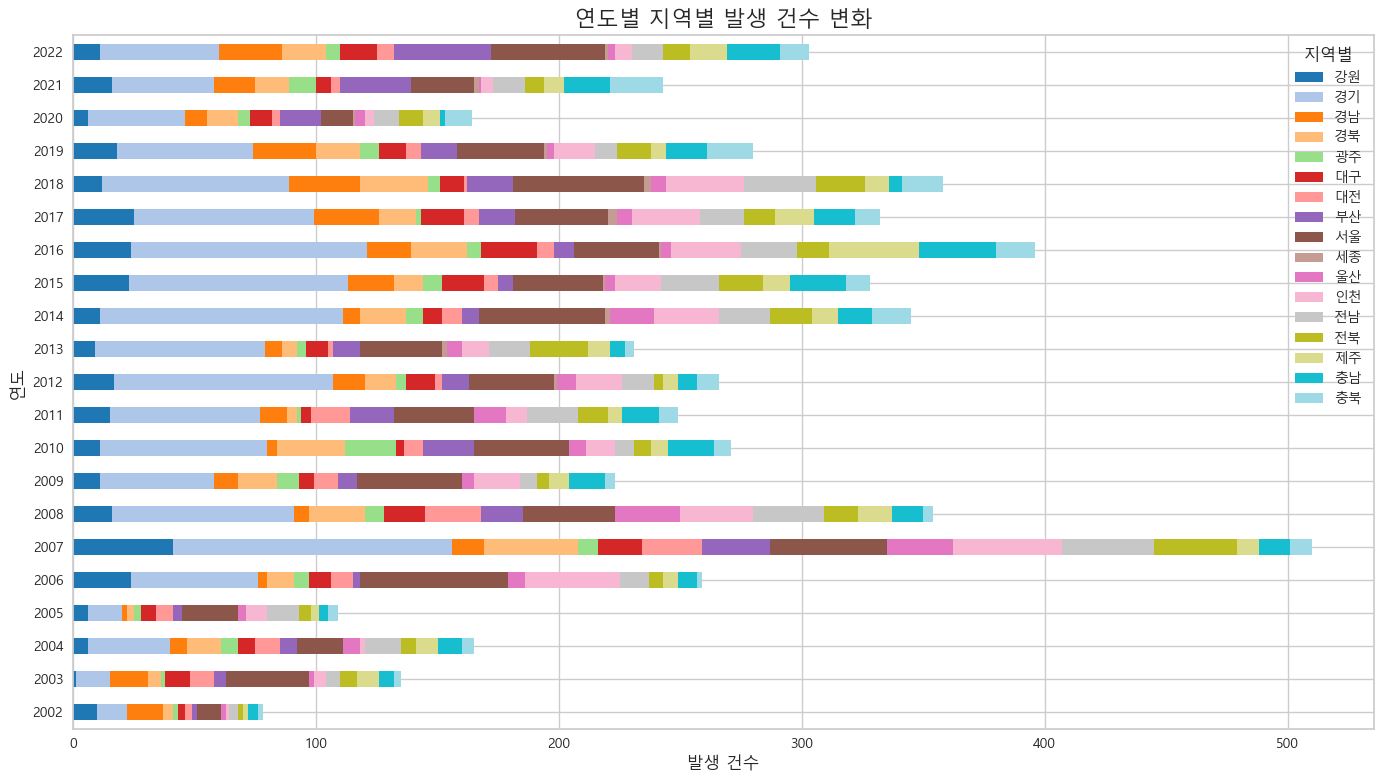

In [44]:
# yearly_facility_summary 데이터를 pivot 형태로 변환 (index는 연도, columns는 지역, values는 발생 건수)
pivot_data = yearly_region_summary.pivot_table(index='OCCRNC_YEAR', columns='OCCRNC_REGN', values='OCCRNC_CNT', aggfunc='sum')

pivot_data.plot(kind='barh', stacked=True, figsize=(14, 8), cmap='tab20')

plt.title('연도별 지역별 발생 건수 변화', fontsize=16)
plt.xlabel('발생 건수', fontsize=12)
plt.ylabel('연도', fontsize=12)
plt.legend(title='지역별', fontsize='small', title_fontsize='medium')
plt.tight_layout()
plt.show()


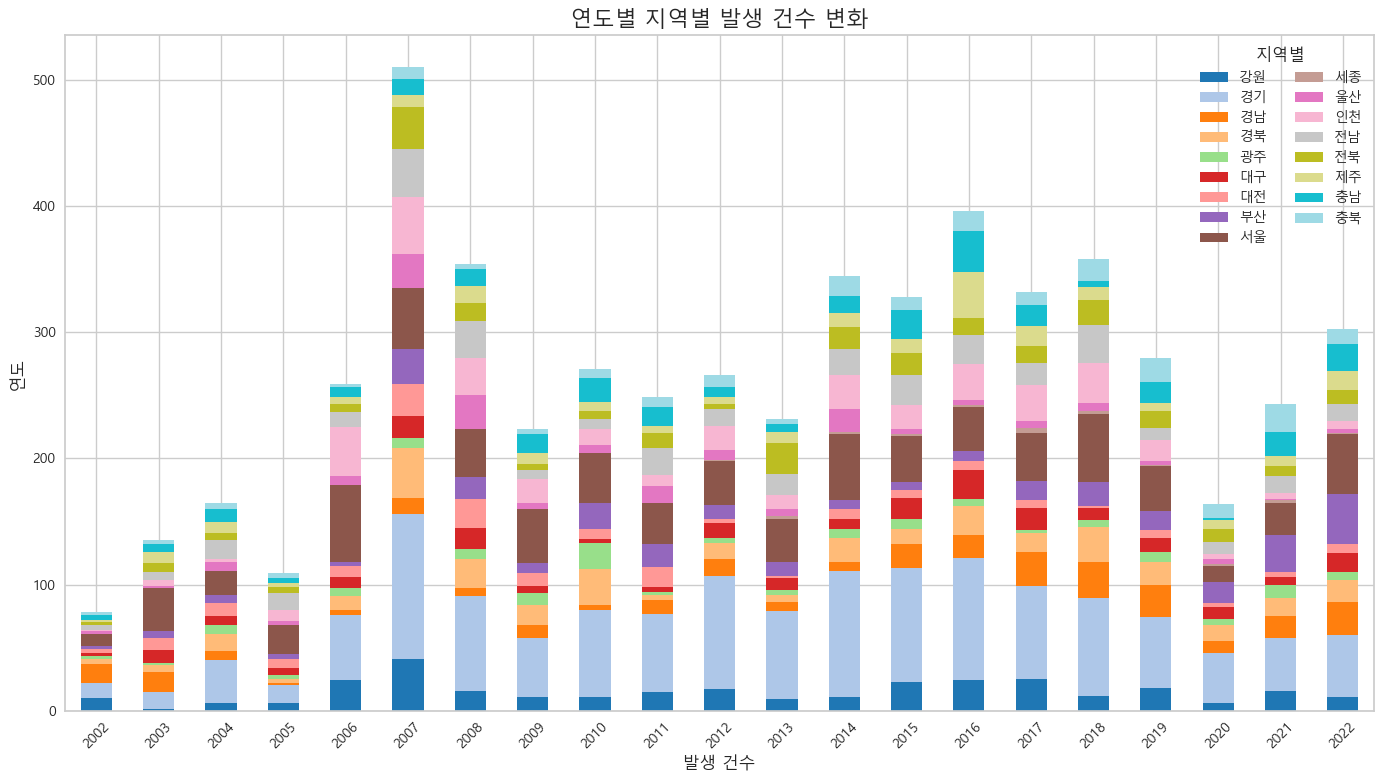

In [45]:
pivot_data = yearly_region_summary.pivot_table(index='OCCRNC_YEAR', columns='OCCRNC_REGN', values='OCCRNC_CNT', aggfunc='sum')

pivot_data.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='tab20')

plt.title('연도별 지역별 발생 건수 변화', fontsize=16)
plt.xlabel('발생 건수', fontsize=12)
plt.ylabel('연도', fontsize=12)
plt.legend(title='지역별', fontsize='small', title_fontsize='medium', ncol=2)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# **Ⅴ. Master Table 모델 검정**

## **1. 지역별 Master Table 선형회귀모델 가정 검정**

### 1. 지역별 Master Table 선형회귀모델 가정 검정

In [46]:
# # 상관관계 확인
# region_df = pd.read_csv('Foodborne_Region_MasterTable.csv')

In [47]:
region_df.tail()

OCCRNC_YEAR  OCCRNC_MM OCCRNC_REGN  OCCRNC_CNT  PATNT_CNT  OCCRNC_IND  \
4153         2002          5          충북         0.0        0.0           0   
4154         2002          4          충북         0.0        0.0           0   
4155         2002          3          충북         1.0       25.0           1   
4156         2002          2          충북         0.0        0.0           0   
4157         2002          1          충북         0.0        0.0           0   

      HOL_IND  HOL_DUR  CPI_VALUE  WTHR_AVG_TEMP  ...  POP_MID_CNT  \
4153        0        0     68.125           16.8  ...  58497.51577   
4154        1        3     67.866           13.0  ...  58532.11944   
4155        1        3     67.351            6.9  ...  58577.53256   
4156        1        9     67.158            0.3  ...  58626.98646   
4157        0        0     66.964           -0.8  ...  58691.07841   

      POP_HIGH_CNT  POP_60P_CNT  POP_STU_PER_SCH  POP_ELM_RATIO  \
4153   62053.86564  214974.0128              NaN       0.087676   
4154   62258.52411  214312.8749              NaN       0.087565   
4155   62479.97672  213624.4780              NaN       0.087445   
4156   62688.71026  212998.1390              NaN       0.087332   
4157   62929.45336  212299.6423              NaN       0.087202   

      POP_MID_RATIO  POP_HIGH_RATIO  POP_60P_RATIO    POP_DENS  GMS_LIC_CNT  
4153       0.039131        0.041510       0.143805  201.154615            7  
4154       0.039146        0.041638       0.143332  201.197233            4  
4155       0.039168        0.041777       0.142840  201.241619            6  
4156       0.039193        0.041908       0.142393  201.282014            6  
4157       0.039227        0.042060       0.141894  201.327073            3  

[5 rows x 38 columns]

In [48]:
region_df.corr(numeric_only = True)

OCCRNC_YEAR  OCCRNC_MM  OCCRNC_CNT  PATNT_CNT  OCCRNC_IND  \
OCCRNC_YEAR            1.000000  -0.000033    0.076073  -0.044807    0.126291   
OCCRNC_MM             -0.000033   1.000000    0.058346   0.020614    0.039277   
OCCRNC_CNT             0.076073   0.058346    1.000000   0.566230    0.597154   
PATNT_CNT             -0.044807   0.020614    0.566230   1.000000    0.284821   
OCCRNC_IND             0.126291   0.039277    0.597154   0.284821    1.000000   
HOL_IND               -0.005972  -0.023409    0.024265   0.029999    0.012051   
HOL_DUR                0.038576  -0.068995    0.010539   0.029372    0.000648   
CPI_VALUE              0.980153   0.041748    0.081136  -0.045505    0.135473   
WTHR_AVG_TEMP          0.023912   0.269758    0.156899   0.117494    0.153345   
WTHR_AVG_H_TEMP        0.030592   0.262158    0.161707   0.121072    0.156064   
WTHR_AVG_L_TEMP        0.015963   0.281483    0.152114   0.113376    0.148071   
WTHR_AVG_PRECIP       -0.056553   0.118048    0.108951   0.055515    0.096747   
WTHR_AVG_WNDSPD       -0.145135  -0.171684   -0.093199  -0.036230   -0.029384   
WTHR_MX_WNDSPD        -0.187113  -0.048083   -0.075320  -0.032888   -0.011283   
WTHR_AVG_PRESS        -0.008950  -0.045225   -0.139826  -0.123877   -0.107516   
WTHR_MX_PRESS         -0.004655  -0.010010   -0.027700  -0.036914   -0.026376   
WTHR_MN_PRESS         -0.028393   0.011588   -0.025826  -0.019425   -0.038087   
WTHR_AVG_SEA_PRESS     0.017588  -0.054762   -0.179307  -0.136299   -0.168006   
WTHR_MX_SEA_PRESS      0.010588  -0.091765   -0.168766  -0.121721   -0.156319   
WTHR_MN_SEA_PRESS     -0.023047  -0.014751   -0.135027  -0.117804   -0.132972   
WTHR_AVG_RHUM          0.069315   0.294677    0.120837   0.048299    0.125929   
WTHR_MN_RHUM           0.021401   0.261811    0.099628   0.028493    0.099572   
WTHR_SUM_SUNHR         0.148564  -0.166945   -0.000947   0.019839    0.041332   
FST_CNT                0.257327   0.148865    0.186670   0.104369    0.179995   
FST_IND                0.125452   0.148275    0.171528   0.085026    0.177961   
POP_GEN_CNT           -0.001147  -0.000303    0.530192   0.288566    0.280672   
POP_ELM_CNT           -0.180618  -0.006932    0.491238   0.293300    0.231430   
POP_MID_CNT           -0.165115  -0.004512    0.515249   0.291862    0.248958   
POP_HIGH_CNT          -0.118291  -0.004801    0.536107   0.292276    0.265804   
POP_60P_CNT            0.252899   0.011742    0.495559   0.244406    0.305213   
POP_STU_PER_SCH       -0.387663  -0.001487    0.177081   0.113301    0.040683   
POP_ELM_RATIO         -0.790056  -0.029296   -0.125955   0.012097   -0.210434   
POP_MID_RATIO         -0.788385  -0.019799   -0.083102   0.012700   -0.143742   
POP_HIGH_RATIO        -0.691580  -0.027593   -0.047549  -0.002201   -0.084638   
POP_60P_RATIO          0.715565   0.035525   -0.009007  -0.069078    0.118077   
POP_DENS              -0.013525  -0.000758    0.187489   0.118950    0.139648   
GMS_LIC_CNT            0.002959  -0.062917    0.445716   0.239920    0.226033   

                     HOL_IND   HOL_DUR  CPI_VALUE  WTHR_AVG_TEMP  \
OCCRNC_YEAR        -0.005972  0.038576   0.980153       0.023912   
OCCRNC_MM          -0.023409 -0.068995   0.041748       0.269758   
OCCRNC_CNT          0.024265  0.010539   0.081136       0.156899   
PATNT_CNT           0.029999  0.029372  -0.045505       0.117494   
OCCRNC_IND          0.012051  0.000648   0.135473       0.153345   
HOL_IND             1.000000  0.864742  -0.006885       0.078228   
HOL_DUR             0.864742  1.000000   0.029669       0.002796   
CPI_VALUE          -0.006885  0.029669   1.000000       0.039170   
WTHR_AVG_TEMP       0.078228  0.002796   0.039170       1.000000   
WTHR_AVG_H_TEMP     0.082684  0.005752   0.047008       0.992934   
WTHR_AVG_L_TEMP     0.076024  0.003282   0.030260       0.994187   
WTHR_AVG_PRECIP     0.017367 -0.026692  -0.051599       0.616635   
WTHR_AVG_WNDSPD    -0.054726 -0.053970  -0.157043      -0

In [49]:
region_df = region_df.rename(columns = {'OCCRNC_CNT':'발생건수','PATNT_CNT':'발생환자수','OCCRNC_IND':'발생확률','HOL_DUR':'황금연휴기간','HOL_IND':'황금연휴여부','CPI_VALUE':'소비자물가지수','WTHR_AVG_TEMP':'평균기온'
                          ,'WTHR_AVG_H_TEMP':'평균최고기온','WTHR_AVG_L_TEMP':'평균최저기온','WTHR_AVG_PRECIP':'평균강수량'
                          ,'WTHR_AVG_WNDSPD':'평균풍속','WTHR_MX_WNDSPD':'평균최고풍속','WTHR_AVG_PRESS':'평균기압','WTHR_MX_PRESS':'최고기압'
                          ,'WTHR_MN_PRESS':'최저기압','WTHR_AVG_SEA_PRESS':'평균해면기압','WTHR_MX_SEA_PRESS':'최고해면기압'
                          ,'WTHR_MN_SEA_PRESS':'최저해면기압','WTHR_AVG_RHUM':'평균상대습도','WTHR_MN_RHUM':'최소상대습도','WTHR_SUM_SUNHR':'총일조시간'
                          ,'FST_CNT':'축제횟수','FST_IND':'축제여부','POP_GEN_CNT':'총인구수','POP_ELM_CNT':'초등학생수','POP_MID_CNT':'중학생수'
                          ,'POP_HIGH_CNT':'고등학생수','POP_60P_CNT':'60세이상인구수','POP_ELM_PROB':'초등학생비율','POP_MID_PROB':'중학생비율'
                          ,'POP_HIGH_PROB':'고등학생비율','POP_60P_PROB':'60세이상비율','POP_DENS':'인구밀도','GMS_LIC_CNT':'집단급식소수'})

#### 1. 선형성 검토

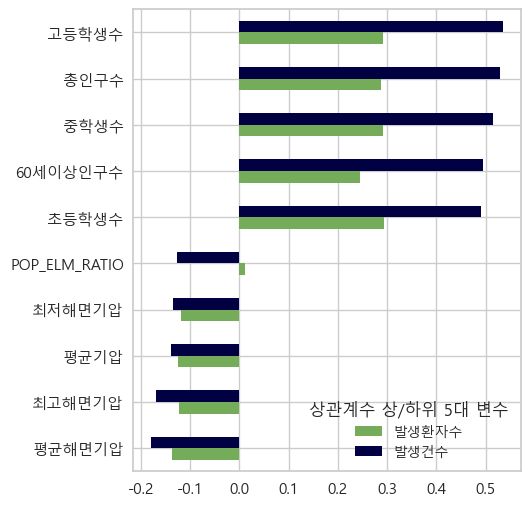

In [50]:
target = region_df.drop(columns = ['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_REGN','POP_STU_PER_SCH']).corr().iloc[:,:2].sort_values(by = '발생건수', ascending = False).iloc[3:,:]
target1 = pd.concat([target.iloc[:5,:], target.iloc[-5:,:]])[['발생환자수','발생건수']]
target1.columns.name = '상관계수 상/하위 5대 변수'
target1.sort_values(by = '발생건수').plot(kind = 'barh', figsize = (5,6), color = ['#74AC5A','#000043'], fontsize = 11)
plt.show()

#### 2. 정규성 검토

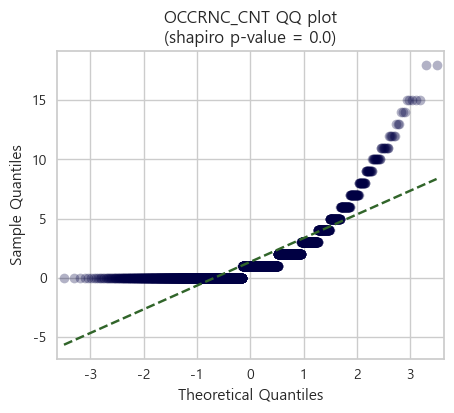

In [51]:
fig, ax = plt.subplots(1, figsize = (5,4))
sm.qqplot(region_df['발생건수'], line = 's', markerfacecolor = '#000043', markeredgecolor = '#000043', alpha = 0.3, ax = ax)
ax.get_lines()[1].set_color('#31652a')
ax.get_lines()[1].set_linestyle('--')
plt.title(f"OCCRNC_CNT QQ plot\n(shapiro p-value = {shapiro(region_df['발생건수']).pvalue})")
plt.show()

#### 3. 등분산성 검토

In [52]:
X = region_df.drop(columns = ['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_REGN','발생환자수','발생건수','발생확률','POP_STU_PER_SCH'])
PATNT_CNT = region_df['발생환자수']
OCCRNC_CNT = region_df['발생건수']

In [53]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X, i) for i in range(len(X.columns))]
vif['Features'] = X.columns

vif.sort_values(by = 'VIF', ascending = False)

VIF        Features
12  781290.755190          평균해면기압
9   345539.166482            평균기압
13  327874.146145          최고해면기압
14   60505.191554          최저해면기압
3    12241.581779            평균기온
4     5565.176844          평균최고기온
20    2993.136020            총인구수
5     2079.880263          평균최저기온
10    1844.931428            최고기압
23    1063.722292           고등학생수
11     844.154592            최저기압
22     775.290326            중학생수
27     743.232659  POP_HIGH_RATIO
26     666.713128   POP_MID_RATIO
21     528.659658           초등학생수
24     421.666429        60세이상인구수
25     415.099524   POP_ELM_RATIO
2      363.259802         소비자물가지수
28     221.118554   POP_60P_RATIO
15     205.360723          평균상대습도
17      52.240210           총일조시간
8       46.691270          평균최고풍속
7       43.169096            평균풍속
16      24.806829          최소상대습도
29      10.452142            인구밀도
0        8.457234          황금연휴여부
1        7.286067          황금연휴기간
6        4.573535           평균강수량
30       4.224848          집단급식소수
19       3.657453            축제여부
18       2.131062            축제횟수

#### 4. 독립성 검토

In [54]:
def hetero_var_and_independence_test(df):
    X = df.drop(columns = ['OCCRNC_YEAR','OCCRNC_MM','OCCRNC_REGN','발생환자수','발생건수','발생확률','POP_STU_PER_SCH'])
    PATNT_CNT = df['발생환자수']
    OCCRNC_CNT = df['발생건수']
    
    # PATNT_CNT를 종속변수로 했을 경우
    
    X_const = sm.add_constant(X)
    ols_patnt = sm.OLS(endog = PATNT_CNT, exog = X_const).fit()
    
    # OCCRNC_CNT를 종속변수로 했을 경우
    
    ols_occrnc = sm.OLS(endog = OCCRNC_CNT, exog = X_const).fit()

    resid_patnt = ols_patnt.resid
    resid_occrnc = ols_occrnc.resid

    plt.figure(figsize = (12.7, 5))
    plt.subplot(121)
    plt.scatter(ols_patnt.fittedvalues, ols_patnt.resid, color = '#000043', alpha = 0.3)
    plt.xlabel('fitted_values')
    plt.ylabel('residuals')
    plt.title(f'PATNT_CNT 예측값과 잔차의 산점도\n(BP 검정 p-value = {het_breuschpagan(resid = ols_patnt.resid, exog_het = X_const)[3]})')
    
    plt.subplot(122)
    plt.scatter(ols_occrnc.fittedvalues, ols_occrnc.resid, color = '#000043', alpha = 0.3)
    plt.xlabel('fitted_values')
    plt.ylabel('residuals')
    plt.title(f'OCCRNC_CNT 예측값과 잔차의 산점도\n(BP 검정 p-value = {het_breuschpagan(resid = ols_occrnc.resid, exog_het = X_const)[3]})')
    plt.show()
    
    fig, axes = plt.subplots(1,2, figsize = (13, 5))
    plot_acf(resid_patnt, ax = axes[0])
    axes[0].set_title(f'PATNT_CNT 잔차의 ACF \n(DW = {sm.stats.stattools.durbin_watson(resid_patnt):.4f})')

    plot_acf(resid_occrnc, ax = axes[1], color = '#000043', vlines_kwargs={'color':'#000043','linestyle':'-'})
    axes[1].set_title(f'OCCRNC_CNT 잔차의 ACF\n(DW = {sm.stats.stattools.durbin_watson(resid_occrnc):.4f})')
    axes[1].get_lines()[1].set_linestyle('')
    plt.show()

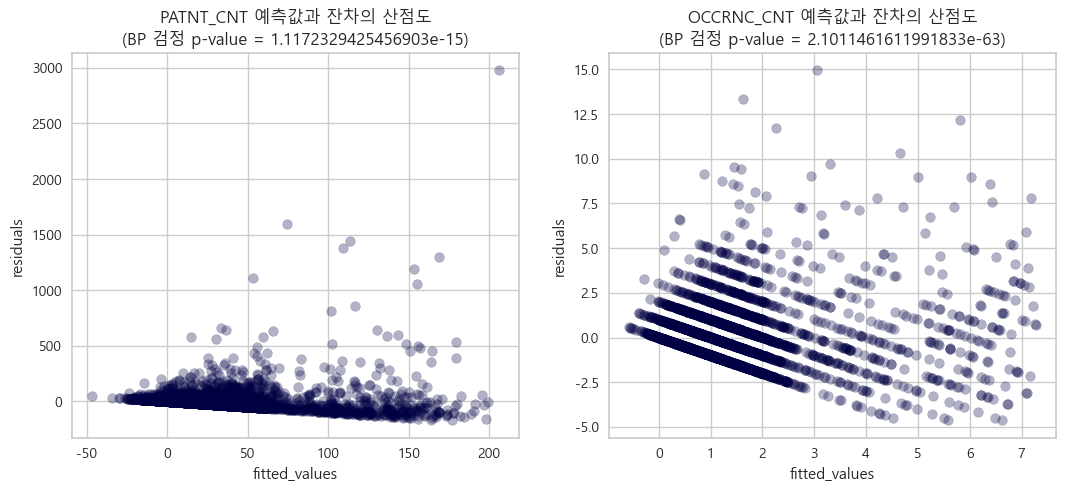

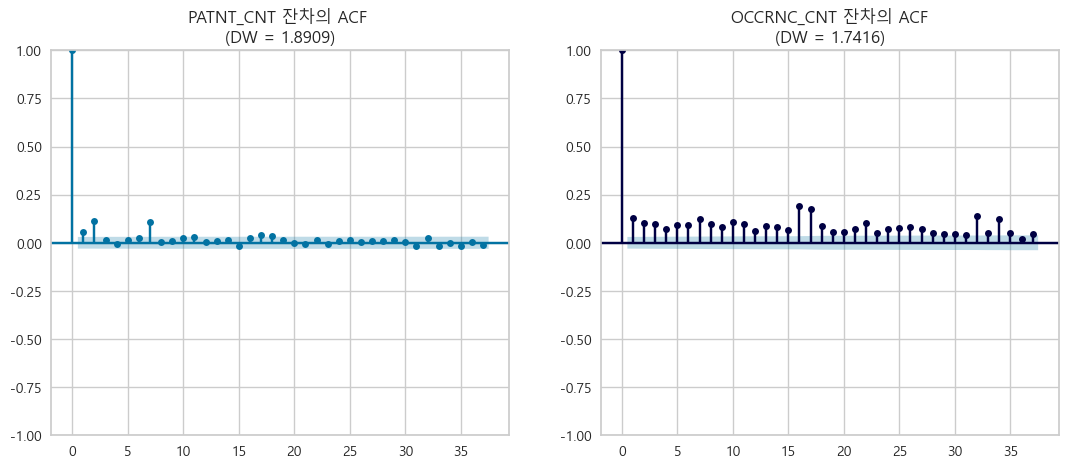

In [55]:
target_df = region_df.sort_values(by = ['OCCRNC_YEAR','OCCRNC_MM'])
hetero_var_and_independence_test(target_df)

#### 5. 결론 
변수 간 공선성이 너무 강해서인지 White검정 실행이 되지 않아 대체 검정법인 Breusch Pagan 검정을 적용했습니다.
검정 방법은 White검정과 동일하게 등분산성이 없다는 것을 귀무가설로 설정하고 p-value가 유의수준 미만이면 이를 기각하는 형태입니

## 2. Master Table 다층분류모델 가설 검정

- **<다중 분류 기준>**  
**발생 건수 기준 4개의 클래스**
- class0 (발생건수0)
- class1 (발생건수1~5)
- class2 (발생건수6~15)
- class3 (발생건수 15건이상)

### 1. 지역별 Master Table 다층분류모델 가설 검정

In [56]:
# 데이터 로드
region_data_copy = pd.read_csv('Foodborne_Region_MasterTable.csv')

# 위험 수준을 범주화하는 함수 정의
def risk_category(count):
    if count == 0:
        return 0  # 관심
    elif 1 <= count <= 5:
        return 1  # 주의
    elif 6 <= count <= 15:
        return 2  # 경고
    else:
        return 3  # 위험

# 위험 수준 열 추가
region_data_copy['RISK_LEVEL'] = region_data_copy['OCCRNC_CNT'].apply(risk_category)

# 고유 지역 목록
regions = region_data_copy['OCCRNC_REGN'].unique()

# 모델 정의
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softmax', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

# 결과 저장을 위한 리스트 초기화
all_results = []

# 각 지역과 모델에 대해 평가
for region in regions:
    # 지역별 데이터 필터링
    region_data = region_data_copy[region_data_copy['OCCRNC_REGN'] == region]
    X = region_data.drop(columns=['RISK_LEVEL', 'OCCRNC_CNT', 'OCCRNC_REGN'])
    y = region_data['RISK_LEVEL']

    # 데이터가 너무 적은 경우 건너뛰기
    if y.nunique() < 2:
        print(f"Skipping region {region} due to insufficient data in one or more classes.")
        continue

    # 전처리 단계 설정
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                    ('scaler', StandardScaler())]), numerical_cols),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
        ]
    )

    # 데이터셋 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 데이터 전처리 적용
    X_train_prepared = preprocessor.fit_transform(X_train)
    X_test_prepared = preprocessor.transform(X_test)

    # 각 모델에 대해 학습 및 평가
    for model_name, model in models.items():
        # XGBoost에 대한 num_class 설정
        if model_name == "XGBoost":
            model.set_params(num_class=len(y.unique()))

        # 모델 학습 및 예측
        model.fit(X_train_prepared, y_train)
        y_pred = model.predict(X_test_prepared)

        # 클래스별 precision, recall, f1-score 계산
        for cls in sorted(y.unique()):
            precision = precision_score(y_test, y_pred, labels=[cls], average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, labels=[cls], average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, labels=[cls], average='weighted', zero_division=0)

            # Accuracy는 전체에 대해 한 번만 계산
            accuracy = accuracy_score(y_test, y_pred) if cls == 0 else None

            # 결과 저장
            all_results.append({
                'Region': region,
                'Model': model_name,
                'Class': cls,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            })

# 결과를 데이터프레임으로 변환 및 출력
results_df = pd.DataFrame(all_results)
results_df.head()

Region         Model  Class  Accuracy  Precision    Recall  F1 Score
0     강원  RandomForest      0  0.947368   1.000000  1.000000  1.000000
1     강원  RandomForest      1       NaN   0.976744  0.933333  0.954545
2     강원  RandomForest      2       NaN   0.000000  0.000000  0.000000
3     강원       XGBoost      0  0.947368   1.000000  1.000000  1.000000
4     강원       XGBoost      1       NaN   0.976744  0.933333  0.954545

### 2. 원인물질별 Master Table 다층분류모델 가설 검정

In [57]:
# 데이터 로드
data_cause_copy = pd.read_csv('Foodborne_Cause_MasterTable4.csv')

# 위험 수준을 범주화하는 함수 정의
def risk_category(count):
    if count == 0:
        return 0  # 관심
    elif 1 <= count <= 5:
        return 1  # 주의
    elif 6 <= count <= 15:
        return 2  # 경고
    else:
        return 3  # 위험

# 위험 수준 열 추가
data_cause_copy['RISK_LEVEL'] = data_cause_copy['OCCRNC_CNT'].apply(risk_category)

# 고유 바이러스 목록
viruses = data_cause_copy['OCCRNC_VIRS'].unique()

# 모델 정의
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softmax', random_state=42),  # XGBoost의 num_class 설정은 아래에서 적용
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

# 결과 저장을 위한 리스트 초기화
all_results = []

# 각 바이러스와 모델에 대해 평가
for virus in viruses:
    # 바이러스별 데이터 필터링
    virus_data = data_cause_copy[data_cause_copy['OCCRNC_VIRS'] == virus]
    X = virus_data.drop(columns=['RISK_LEVEL', 'OCCRNC_CNT'])
    y = virus_data['RISK_LEVEL']

    # 전처리 단계 설정
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                    ('scaler', StandardScaler())]), numerical_cols),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
        ]
    )

    # 데이터셋 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 데이터 전처리 적용
    X_train_prepared = preprocessor.fit_transform(X_train)
    X_test_prepared = preprocessor.transform(X_test)

    # 각 모델에 대해 학습 및 평가
    for model_name, model in models.items():
        # XGBoost에 대한 num_class 설정
        if model_name == "XGBoost":
            model.set_params(num_class=len(y.unique()))

        # 모델 학습 및 예측
        model.fit(X_train_prepared, y_train)
        y_pred = model.predict(X_test_prepared)

        # 클래스별 precision, recall, f1-score 계산
        for cls in sorted(y.unique()):
            precision = precision_score(y_test, y_pred, labels=[cls], average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, labels=[cls], average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, labels=[cls], average='weighted', zero_division=0)

            # Accuracy는 전체에 대해 한 번만 계산
            accuracy = accuracy_score(y_test, y_pred) if cls == 0 else None

            # 결과 저장
            all_results.append({
                'Virus': virus,
                'Model': model_name,
                'Class': cls,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            })

# 결과를 데이터프레임으로 변환 및 출력
results_df = pd.DataFrame(all_results)
results_df

Virus         Model  Class  Accuracy  Precision    Recall  F1 Score
0     노로바이러스  RandomForest      0  0.828947   1.000000  1.000000  1.000000
1     노로바이러스  RandomForest      1       NaN   0.833333  0.909091  0.869565
2     노로바이러스  RandomForest      2       NaN   0.375000  0.272727  0.315789
3     노로바이러스  RandomForest      3       NaN   0.000000  0.000000  0.000000
4     노로바이러스       XGBoost      0  0.815789   1.000000  1.000000  1.000000
..       ...           ...    ...       ...        ...       ...       ...
198  황색포도상구균    NaiveBayes      1       NaN   0.970588  1.000000  0.985075
199  황색포도상구균    NaiveBayes      2       NaN   0.000000  0.000000  0.000000
200  황색포도상구균  DecisionTree      0  0.986842   1.000000  1.000000  1.000000
201  황색포도상구균  DecisionTree      1       NaN   0.970588  1.000000  0.985075
202  황색포도상구균  DecisionTree      2       NaN   0.000000  0.000000  0.000000

[203 rows x 7 columns]

# **Ⅵ. Master Table 모델링**

## 1. PYCarot

In [58]:
master_df = pd.read_csv('Foodborne_Cause_MasterTable4.csv')
# 지역을 기준으로 그룹화해서 지역별 데이터셋 생성
cause_groups = {cause: df for cause, df in master_df.groupby('OCCRNC_VIRS')}

norovirs_df = cause_groups.get("노로바이러스")
bacillus_df = cause_groups.get("바실러스세레우스")
ecoli_df = cause_groups.get("병원성대장균")
salmonella_df = cause_groups.get("살모넬라")
protozoa_df = cause_groups.get("원충")
vibrio_df = cause_groups.get("장염비브리오")
campilobacter_df = cause_groups.get("캠필로박터제주니")
clostrip_df = cause_groups.get("클로스트리디움퍼프린젠스")
staphylo_df = cause_groups.get("황색포도상구균")

# 원인물질별 데이터프레임 목록
cause_list = {
    "노로바이러스": ["norovirs", norovirs_df],
    "바실러스세레우스": ["bacillus", bacillus_df],
    "병원성대장균": ["ecoli", ecoli_df],
    "살모넬라": ["salmonella", salmonella_df],
    "원충": ["protozoa", protozoa_df],
    "장염비브리오": ["vibrio", vibrio_df],
    "캠필로박터제주니": ["campilobacter", campilobacter_df],
    "클로스트리디움퍼프린젠스": ["clostrip", clostrip_df],
    "황색포도상구균": ["staphylo", staphylo_df]
}

#### 1) PyCaret Classification 분석

In [59]:
# 최종 결과를 저장할 데이터프레임 생성
final_report = pd.DataFrame()
removed_features_report = {}

for cause_name, (eng_name, cause_df) in cause_list.items():
    print(f"Processing {cause_name} ...")

    # PyCaret 설정
    classification_setup = setup(
        data=cause_df,
        target='OCCRNC_IND',  
        ignore_features=['OCCRNC_CNT', 'PATNT_CNT', 'OCCRNC_VIRS', 'OCCRNC_YEAR', 'OCCRNC_MM'],  
        session_id=42,
        #normalize=True,
        #feature_selection=True,
        #remove_multicollinearity=True,
        #multicollinearity_threshold=0.9,
        remove_outliers=False,
        fold=5,  
        train_size=0.7,
        html=False,
        #fix_imbalance=True
    )

    # 모델 비교 수행 및 결과 가져오기
    models = compare_models(verbose=False)
    results = pull()
    
    # 사용 가능한 지표 확인
    print(f"Available metrics in results for {cause_name}: {results.columns}")
    
    # 존재하는 지표로만 필터링
    available_metrics = ['Accuracy', 'F1', 'Recall', 'Prec.']
    metrics = [metric for metric in available_metrics if metric in results.columns]
    
    if 'Model' in results.columns:
        results_sorted = results[['Model'] + metrics].sort_values(by='Model').set_index('Model')
    else:
        # 'Model' 열이 없을 경우 직접적인 모델 이름 사용 대신 index 설정 필요
        results_sorted = results[metrics].sort_index()
    
    # 각 원인물질에 대한 성능 지표를 final_report에 추가
    for metric in metrics:
        final_report[f"{cause_name}_{metric}"] = results_sorted[metric]

# # 최종 보고서 저장
# final_report.to_csv('PyCaret_Cause4_Classification_ver1.csv', encoding='utf-8-sig')

print("Process Terminated")


Processing 노로바이러스 ...
                    Description             Value
0                    Session id                42
1                        Target        OCCRNC_IND
2                   Target type            Binary
3           Original data shape         (252, 37)
4        Transformed data shape         (252, 32)
5   Transformed train set shape         (176, 32)
6    Transformed test set shape          (76, 32)
7               Ignore features                 5
8              Numeric features                31
9                    Preprocess              True
10              Imputation type            simple
11           Numeric imputation              mean
12       Categorical imputation              mode
13               Fold Generator   StratifiedKFold
14                  Fold Number                 5
15                     CPU Jobs                -1
16                      Use GPU             False
17               Log Experiment             False
18              Experiment N

### 2) XGBoost Classifier 분석

In [60]:
results = []
drop_cols = ['OCCRNC_IND','OCCRNC_CNT', 'PATNT_CNT', 'OCCRNC_VIRS', 'OCCRNC_YEAR', 'OCCRNC_MM']

for cause_name, (cause_code, cause_df) in cause_list.items():
    # 독립 변수(X)와 종속 변수(y) 분리
    X = cause_df.drop(columns=drop_cols)
    y = cause_df['OCCRNC_IND']    

    # 데이터 분할 (train 70%, test 30%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 모델 생성 및 학습
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # 모델 저장
    model_filename = f"{cause_name}_XGBoost_model.joblib"
    joblib.dump(model, model_filename)
    
    
    # 예측
    y_pred = model.predict(X_test)

    # 평가지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    precision = precision_score(y_test, y_pred, zero_division=0)
    
    # 결과 저장
    results.append({
        'Cause': cause_name,
        'Accuracy': round(accuracy, 4),
        'F1 Score': round(f1, 4),
        'Recall': round(recall, 4),
        'Precision': round(precision, 4)
    })

# 결과를 DataFrame으로 변환 및 CSV로 저장
results_df = pd.DataFrame(results)
results_df.head(3)
# results_df.to_csv('XGBoost_Cause4_1.csv', index=False, encoding='utf-8-sig')


Cause  Accuracy  F1 Score  Recall  Precision
0    노로바이러스    0.7632    0.8475  0.8929     0.8065
1  바실러스세레우스    0.6842    0.5000  0.5455     0.4615
2    병원성대장균    0.8289    0.8713  0.8800     0.8627

#### 3) Results and Discussion

1. Gradient Boosting Regressor (gbr)
    - 여러 지역에서 상대적으론 높은 R(^)2 값을 기록하고 있다.
    - 비선형 모델로 데이터 내의 복잡한 패턴을 파악하는데 유리하다
    - 해석 가능성은 다소 낮지만, feature importance 등을 통해 중요한 변수들을 파악할 수 있다.

2. Light Gradient Boosting Machine (lightgbm)
    - XGBoost와 유사한 앙상블 학습 모델이지만, 속도가 빠르고 메모리 효율이 좋다.
    - 일부 지역에서 상대적으로 높은 R(^)2 값을 기록하고 있다.

3. Random Forest Regressor
    - '경남', '부산', '강원' 등에서 비교적 준수한 성능을 보인다.
    - 비선형 패턴을 작 학습할 수 있기 때문에 다양한 변수 간의 상호작용을 포착할 수 있다.
    - 추가적인 하이퍼파라미터 튜닝 시 성능 향상의 여지가 크다.
    - 해석은 다소 어렵겠지만, 변수 중요도 분석을 통해 주요 변수를 파악할 수 있다.

4. Extra Trees Regressor
    - Random Forest 와 비슷하지만, 더욱 무작위성을 강조하여 특정 피처의 임의의 분할지점을 사용하기 때문에 과적합 방지에 더 효과적이다.
    - 비선형성 및 복잡한 데이터 패턴 학습에 강하다.
    - 랜덤한 특성으로 인해 데이터의 노이즈에 잘 견딜 수 있기 때문에 데이터에 노이즈가 많거나 불확실한 경우 장점으로 작용될 수 있다.
    - 하이퍼파라미터 조정을 통해 성능을 향상시키기 쉬운 편이다.

**결론:** Gradient Boosting Regressor, LGBM, XGBoost, Random Forest Regressor, Extra Trees Regressor 모델을 이용하여 추가 분석 수행.

## 2. 지역별 식중독 예측 모델링

### 1) 모델링

#### - 최초 모델

In [61]:
data = pd.read_csv(r'Foodborne_Region_MasterTable.csv')
# 종속변수 OCCRNC_IND와 관련된 변수 OCCRNC_CNT, OCCRNC_REGN, PATNT_CNT와 결측치가 많은 변수 POP_STU_PER_SCH는 제외하고 모델링 
# OCCRNC_YEAR, OCCRNC_MM도 독립변수에서 제외한 모델과 비교 

city = ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']
models = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGB': XGBClassifier(n_estimators=100, learning_rate=0.3, max_depth=6, random_state=42),
    'GB': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

results = []

for c in city:
    filtered_data = data[data['OCCRNC_REGN'] == c]
    X = filtered_data.drop(columns=['OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH']) 
    y = filtered_data['OCCRNC_IND']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    city_results = {'City': c}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        
        # Feature Importance
        importance = dict(sorted(zip(X.columns, model.feature_importances_), key=lambda item: item[1], reverse=True)[:5])

        # Validation performance
        y_val_pred = model.predict(X_val)
        city_results.update({
            f'{model_name}_Val_Accuracy': round(accuracy_score(y_val, y_val_pred), 4),
            f'{model_name}_Val_F1_Score': round(f1_score(y_val, y_val_pred), 4),
            f'{model_name}_Val_Precision': round(precision_score(y_val, y_val_pred), 4),
            f'{model_name}_Val_Recall': round(recall_score(y_val, y_val_pred), 4)
        })
        
        # Test performance
        y_test_pred = model.predict(X_test)
        city_results.update({
            f'{model_name}_T_Accuracy': round(accuracy_score(y_test, y_test_pred), 4),
            f'{model_name}_T_F1_Score': round(f1_score(y_test, y_test_pred), 4),
            f'{model_name}_T_Precision': round(precision_score(y_test, y_test_pred), 4),
            f'{model_name}_T_Recall': round(recall_score(y_test, y_test_pred), 4)
        })

    results.append(city_results)

# Convert to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.head(3)

City  RF_Val_Accuracy  RF_Val_F1_Score  RF_Val_Precision  RF_Val_Recall  \
0   강원           0.7222           0.7727            0.7391         0.8095   
1   경기           0.7500           0.8525            0.9286         0.7879   
2   경남           0.6667           0.7273            0.6667         0.8000   

   RF_T_Accuracy  RF_T_F1_Score  RF_T_Precision  RF_T_Recall  \
0         0.6579         0.6579          0.7812       0.5682   
1         0.8684         0.9275          0.9275       0.9275   
2         0.7368         0.7619          0.7805       0.7442   

   XGB_Val_Accuracy  ...  XGB_T_Precision  XGB_T_Recall  GB_Val_Accuracy  \
0            0.6944  ...           0.7297        0.6136           0.6389   
1            0.8056  ...           0.9000        0.9130           0.8056   
2            0.6944  ...           0.6809        0.7442           0.5833   

   GB_Val_F1_Score  GB_Val_Precision  GB_Val_Recall  GB_T_Accuracy  \
0           0.7111            0.6667         0.7619         0.5921   
1           0.8852            0.9643         0.8182         0.8684   
2           0.6667            0.6000         0.7500         0.7895   

   GB_T_F1_Score  GB_T_Precision  GB_T_Recall  
0         0.6265          0.6667       0.5909  
1         0.9265          0.9403       0.9130  
2         0.8140          0.8140       0.8140  

[3 rows x 25 columns]

#### - 최종 모델

강원   
(Gradient 모델/ 오버샘플링 미적용 / n_estimators 20, learning_rate 0.09, max_depth 7)

In [62]:
filtered = data[data['OCCRNC_REGN'] == '강원']
X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH', 'GMS_LIC_CNT','POP_MID_RATIO', 'WTHR_AVG_RHUM', 'WTHR_MN_RHUM', 'FST_IND', 'POP_MID_CNT', 'POP_60P_CNT', 'POP_60P_RATIO', 'HOL_IND', 'FST_CNT'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# 하이퍼 파라미터 그리드 설정
param_grid = {
    'n_estimators': [20],
    'learning_rate': [0.09],
    'max_depth': [17],
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_gb_model = grid_search.best_estimator_

# 검증 세트 성능 평가
y_val_pred_GB = best_gb_model.predict(X_val)
val_Accuracy_GB = round(accuracy_score(y_val, y_val_pred_GB), 4)
val_f1_GB = round(f1_score(y_val, y_val_pred_GB), 4)
val_precision_GB = round(precision_score(y_val, y_val_pred_GB), 4)
val_recall_GB = round(recall_score(y_val, y_val_pred_GB), 4)

# 테스트 세트 성능 평가
y_test_pred_GB = best_gb_model.predict(X_test)
test_Accuracy_GB = round(accuracy_score(y_test, y_test_pred_GB), 4)
test_f1_GB = round(f1_score(y_test, y_test_pred_GB), 4)
test_precision_GB = round(precision_score(y_test, y_test_pred_GB), 4)
test_recall_GB = round(recall_score(y_test, y_test_pred_GB), 4)


print(f'City', '강원')
print(f"{val_Accuracy_GB} {val_f1_GB} {val_precision_GB} {val_recall_GB} {test_Accuracy_GB} {test_f1_GB} {test_precision_GB} {test_recall_GB}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
City 강원
0.6111 0.65 0.6842 0.619 0.6711 0.6988 0.7436 0.6591


경기  
(Gradient 모델/ SMOTE 오버샘플링/ n_estimators 100, learning_rate 0.1, max_depth 5)


In [63]:
filtered = data[data['OCCRNC_REGN'] == '경기']
X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [5],
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_gb_model = grid_search.best_estimator_

# 검증 세트 성능 평가
y_val_pred_GB = best_gb_model.predict(X_val)
val_Accuracy_GB = round(accuracy_score(y_val, y_val_pred_GB), 4)
val_f1_GB = round(f1_score(y_val, y_val_pred_GB), 4)
val_precision_GB = round(precision_score(y_val, y_val_pred_GB), 4)
val_recall_GB = round(recall_score(y_val, y_val_pred_GB), 4)

# 테스트 세트 성능 평가
y_test_pred_GB = best_gb_model.predict(X_test)
test_Accuracy_GB = round(accuracy_score(y_test, y_test_pred_GB), 4)
test_f1_GB = round(f1_score(y_test, y_test_pred_GB), 4)
test_precision_GB = round(precision_score(y_test, y_test_pred_GB), 4)
test_recall_GB = round(recall_score(y_test, y_test_pred_GB), 4)


print(f'City', '경기')
print(f'GB_Validation_Accuracy: {val_Accuracy_GB}'),
print(f'GB_Validation_F1_Score: {val_f1_GB}'),
print(f'GB_Validation_Precision: {val_precision_GB}'),
print(f'GB_Validation_Recall: {val_recall_GB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_GB}'),
print(f'GB_Test_F1_Score: {test_f1_GB}'),
print(f'GB_Test_Precision: {test_precision_GB}'),
print(f'GB_Test_Recall: {test_recall_GB}')



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation F1 score: 0.9434
City 경기
GB_Validation_Accuracy: 0.7222
GB_Validation_F1_Score: 0.8387
GB_Validation_Precision: 0.8966
GB_Validation_Recall: 0.7879
GB_Test_Accuracy: 0.9211
GB_Test_F1_Score: 0.9565
GB_Test_Precision: 0.9565
GB_Test_Recall: 0.9565


경남  
(LightGBM 모델/ 오버샘플링 미적용 / n_estimators 100, learning_rate 0.1, max_depth -1, min_child_samples 20, num_leaves 31, subsample 1)

In [64]:
filtered = data[data['OCCRNC_REGN'] == '경남']
X = filtered.drop(columns=['OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [-1],
    'min_child_samples': [20],
    'num_leaves': [31],
    'subsample': [1]
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
lgb_model = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='f1',  callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=10)])

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_lgb_model = grid_search.best_estimator_

# LGB Validation 성능 평가: 
y_val_pred_LGB = best_lgb_model.predict(X_val)
val_Accuracy_LGB = round(accuracy_score(y_val, y_val_pred_LGB), 4)
val_f1_LGB = round(f1_score(y_val, y_val_pred_LGB), 4)
val_precision_LGB = round(precision_score(y_val, y_val_pred_LGB), 4)
val_recall_LGB = round(recall_score(y_val, y_val_pred_LGB), 4)

# LGB Test 데이터 성능평가: 
y_test_pred_LGB = best_lgb_model.predict(X_test)
test_Accuracy_LGB = round(accuracy_score(y_test, y_test_pred_LGB), 4)
test_f1_LGB = round(f1_score(y_test, y_test_pred_LGB), 4)
test_precision_LGB = round(precision_score(y_test, y_test_pred_LGB), 4)
test_recall_LGB = round(recall_score(y_test, y_test_pred_LGB), 4)

print(f'City', '경남')
print(f'GB_Validation_Accuracy: {val_Accuracy_LGB}'),
print(f'GB_Validation_F1_Score: {val_f1_LGB}'),
print(f'GB_Validation_Precision: {val_precision_LGB}'),
print(f'GB_Validation_Recall: {val_recall_LGB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_LGB}'),
print(f'GB_Test_F1_Score: {test_f1_LGB}'),
print(f'GB_Test_Precision: {test_precision_LGB}'),
print(f'GB_Test_Recall: {test_recall_LGB}')
print(f"{grid_search.best_params_} {val_Accuracy_LGB} {val_f1_LGB} {val_precision_LGB} {val_recall_LGB} {test_Accuracy_LGB} {test_f1_LGB} {test_precision_LGB} {test_recall_LGB}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 79, number of negative: 61
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564286 -> initscore=0.258574
[LightGBM] [Info] Start training from score 0.258574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

경북  
(Gradient 모델/ Random 오버샘플링 적용/ n_estimators 100, learning_rate 0.1, max_depth 3,subsample 1)

In [65]:
filtered = data[data['OCCRNC_REGN'] == '경북']
X = filtered.drop(columns=['OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

ros = RandomOverSampler(random_state=42)
X_ros_resampled, y_ros_resampled = ros.fit_resample(X_train, y_train)


# 하이퍼 파라미터 그리드 설정
param_grid = {
    'n_estimators': [90],
    'learning_rate': [0.1],
    'max_depth': [5],
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_ros_resampled, y_ros_resampled)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_gb_model = grid_search.best_estimator_

# 검증 세트 성능 평가
y_val_pred_GB = best_gb_model.predict(X_val)
val_Accuracy_GB = round(accuracy_score(y_val, y_val_pred_GB), 4)
val_f1_GB = round(f1_score(y_val, y_val_pred_GB), 4)
val_precision_GB = round(precision_score(y_val, y_val_pred_GB), 4)
val_recall_GB = round(recall_score(y_val, y_val_pred_GB), 4)

# 테스트 세트 성능 평가
y_test_pred_GB = best_gb_model.predict(X_test)
test_Accuracy_GB = round(accuracy_score(y_test, y_test_pred_GB), 4)
test_f1_GB = round(f1_score(y_test, y_test_pred_GB), 4)
test_precision_GB = round(precision_score(y_test, y_test_pred_GB), 4)
test_recall_GB = round(recall_score(y_test, y_test_pred_GB), 4)


print(f'City', '경기')
print(f'GB_Validation_Accuracy: {val_Accuracy_GB}'),
print(f'GB_Validation_F1_Score: {val_f1_GB}'),
print(f'GB_Validation_Precision: {val_precision_GB}'),
print(f'GB_Validation_Recall: {val_recall_GB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_GB}'),
print(f'GB_Test_F1_Score: {test_f1_GB}'),
print(f'GB_Test_Precision: {test_precision_GB}'),
print(f'GB_Test_Recall: {test_recall_GB}')
print(f"{grid_search.best_params_} {val_Accuracy_GB} {val_f1_GB} {val_precision_GB} {val_recall_GB} {test_Accuracy_GB} {test_f1_GB} {test_precision_GB} {test_recall_GB}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 90}
Best cross-validation F1 score: 0.7269
City 경기
GB_Validation_Accuracy: 0.7222
GB_Validation_F1_Score: 0.7727
GB_Validation_Precision: 0.7727
GB_Validation_Recall: 0.7727
GB_Test_Accuracy: 0.6974
GB_Test_F1_Score: 0.7677
GB_Test_Precision: 0.7308
GB_Test_Recall: 0.8085
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 90} 0.7222 0.7727 0.7727 0.7727 0.6974 0.7677 0.7308 0.8085


광주  
(LightGGBM 모델/ SMOTE 오버샘플링 적용/ n_estimators 300, learning_rate 0.5, max_depth 2, min_child_samples 20, num_leaves 31, subsample 1)

In [66]:
filtered = data[data['OCCRNC_REGN'] == '광주']
X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

smote = SMOTE(random_state=42)
X_smote_resampled, y_smote_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.5],
    'max_depth': [2],
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
lgb_model = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_smote_resampled, y_smote_resampled, eval_set=[(X_val, y_val)], eval_metric='f1',  callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=10)])

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_lgb_model = grid_search.best_estimator_

# LGB Validation 성능 평가: 
y_val_pred_LGB = best_lgb_model.predict(X_val)
val_Accuracy_LGB = round(accuracy_score(y_val, y_val_pred_LGB), 4)
val_f1_LGB = round(f1_score(y_val, y_val_pred_LGB), 4)
val_precision_LGB = round(precision_score(y_val, y_val_pred_LGB), 4)
val_recall_LGB = round(recall_score(y_val, y_val_pred_LGB), 4)

# LGB Test 데이터 성능평가: 
y_test_pred_LGB = best_lgb_model.predict(X_test)
test_Accuracy_LGB = round(accuracy_score(y_test, y_test_pred_LGB), 4)
test_f1_LGB = round(f1_score(y_test, y_test_pred_LGB), 4)
test_precision_LGB = round(precision_score(y_test, y_test_pred_LGB), 4)
test_recall_LGB = round(recall_score(y_test, y_test_pred_LGB), 4)

print(f'City', '경남')
print(f'GB_Validation_Accuracy: {val_Accuracy_LGB}'),
print(f'GB_Validation_F1_Score: {val_f1_LGB}'),
print(f'GB_Validation_Precision: {val_precision_LGB}'),
print(f'GB_Validation_Recall: {val_recall_LGB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_LGB}'),
print(f'GB_Test_F1_Score: {test_f1_LGB}'),
print(f'GB_Test_Precision: {test_precision_LGB}'),
print(f'GB_Test_Recall: {test_recall_LGB}')
print(f"{grid_search.best_params_} {test_Accuracy_LGB} {test_f1_LGB} {test_precision_LGB} {test_recall_LGB}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 88, number of negative: 88
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1458
[LightGBM] [Info] Number of data points in the train set: 176, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

대구  
(LGBM 모델 / 오버샘플링 미적용 / n_estimators 46 , learning_rate 0.09, max_depth 2, min_child_samples 22, num_leaves 31, subsample 1)

In [67]:
filtered = data[data['OCCRNC_REGN'] == '대구']
X = filtered.drop(columns=['OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

param_grid = {
    'n_estimators': [46],
    'learning_rate': [0.09],
    'max_depth': [2],
    'num_leaves': [31],
    'subsample': [1],
    'min_child_samples': [22]
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
lgb_model = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='f1',  callbacks=[early_stopping(stopping_rounds=50)])

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_lgb_model = grid_search.best_estimator_

# LGB Validation 성능 평가: 
y_val_pred_LGB = best_lgb_model.predict(X_val)
val_Accuracy_LGB = round(accuracy_score(y_val, y_val_pred_LGB), 4)
val_f1_LGB = round(f1_score(y_val, y_val_pred_LGB), 4)
val_precision_LGB = round(precision_score(y_val, y_val_pred_LGB), 4)
val_recall_LGB = round(recall_score(y_val, y_val_pred_LGB), 4)

# LGB Test 데이터 성능평가: 
y_test_pred_LGB = best_lgb_model.predict(X_test)
test_Accuracy_LGB = round(accuracy_score(y_test, y_test_pred_LGB), 4)
test_f1_LGB = round(f1_score(y_test, y_test_pred_LGB), 4)
test_precision_LGB = round(precision_score(y_test, y_test_pred_LGB), 4)
test_recall_LGB = round(recall_score(y_test, y_test_pred_LGB), 4)

print(f'City', '경남')
print(f'GB_Validation_Accuracy: {val_Accuracy_LGB}'),
print(f'GB_Validation_F1_Score: {val_f1_LGB}'),
print(f'GB_Validation_Precision: {val_precision_LGB}'),
print(f'GB_Validation_Recall: {val_recall_LGB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_LGB}'),
print(f'GB_Test_F1_Score: {test_f1_LGB}'),
print(f'GB_Test_Precision: {test_precision_LGB}'),
print(f'GB_Test_Recall: {test_recall_LGB}')
print(f"{grid_search.best_params_}{test_Accuracy_LGB} {test_f1_LGB} {test_precision_LGB} {test_recall_LGB}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 76, number of negative: 64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1201
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542857 -> initscore=0.171850
[LightGBM] [Info] Start training from score 0.171850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

대전  
(XGBoost 모델/n_estimators 30, learning_rate 0.09, max_depth 2, subsample 1)

In [68]:
filtered = data[data['OCCRNC_REGN'] == '대전']
X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

ros = RandomOverSampler(random_state=42)
X_ros_resampled, y_ros_resampled = ros.fit_resample(X_train, y_train)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [30],               
    'max_depth': [2],                      
    'learning_rate': [0.09],   
    'subsample': [1],        
}

# XGBoost 모델 학습 및 하이퍼파라미터 튜닝
xgb_model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_ros_resampled, y_ros_resampled)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_xgb_model = grid_search.best_estimator_

# 검증 세트 성능 평가
y_val_pred_XGB = best_xgb_model.predict(X_val)
val_Accuracy_XGB = round(accuracy_score(y_val, y_val_pred_XGB), 4)
val_f1_XGB = round(f1_score(y_val, y_val_pred_XGB), 4)
val_precision_XGB = round(precision_score(y_val, y_val_pred_XGB), 4)
val_recall_XGB = round(recall_score(y_val, y_val_pred_XGB), 4)

# 테스트 세트 성능 평가
y_test_pred_XGB = best_xgb_model.predict(X_test)
test_Accuracy_XGB = round(accuracy_score(y_test, y_test_pred_XGB), 4)
test_f1_XGB = round(f1_score(y_test, y_test_pred_XGB), 4)
test_precision_XGB = round(precision_score(y_test, y_test_pred_XGB), 4)
test_recall_XGB = round(recall_score(y_test, y_test_pred_XGB), 4)

print('City:', '대전')
print(f'XGB_Validation_Accuracy: {val_Accuracy_XGB}')
print(f'XGB_Validation_F1_Score: {val_f1_XGB}')
print(f'XGB_Validation_Precision: {val_precision_XGB}')
print(f'XGB_Validation_Recall: {val_recall_XGB}')
print(f'XGB_Test_Accuracy: {test_Accuracy_XGB}')
print(f'XGB_Test_F1_Score: {test_f1_XGB}')
print(f'XGB_Test_Precision: {test_precision_XGB}')
print(f'XGB_Test_Recall: {test_recall_XGB}')
print(f"{grid_search.best_params_} {val_Accuracy_XGB} {val_f1_XGB} {val_precision_XGB} {val_recall_XGB} {test_Accuracy_XGB} {test_f1_XGB} {test_precision_XGB} {test_recall_XGB}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'learning_rate': 0.09, 'max_depth': 2, 'n_estimators': 30, 'subsample': 1}
Best cross-validation F1 score: 0.6565
City: 대전
XGB_Validation_Accuracy: 0.5833
XGB_Validation_F1_Score: 0.5161
XGB_Validation_Precision: 0.5
XGB_Validation_Recall: 0.5333
XGB_Test_Accuracy: 0.7632
XGB_Test_F1_Score: 0.7273
XGB_Test_Precision: 0.7059
XGB_Test_Recall: 0.75
{'learning_rate': 0.09, 'max_depth': 2, 'n_estimators': 30, 'subsample': 1} 0.5833 0.5161 0.5 0.5333 0.7632 0.7273 0.7059 0.75


부산  
(lightGBM/ 랜덤 오버샘플링/ n_estimators 100, learning_rate 0.1, max_depth 5, subsample 1)

In [69]:
filtered = data[data['OCCRNC_REGN'] == '부산']
X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH','HOL_IND', 'HOL_DUR', 'WTHR_AVG_TEMP', 'WTHR_AVG_H_TEMP', 'WTHR_AVG_L_TEMP', 'POP_MID_CNT', 'POP_HIGH_CNT', 'POP_HIGH_RATIO', 'POP_60P_RATIO'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

ros = RandomOverSampler(random_state=42)
X_ros_resampled, y_ros_resampled = ros.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [5],
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
lgb_model = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_ros_resampled, y_ros_resampled, eval_set=[(X_val, y_val)], eval_metric='f1',  callbacks=[early_stopping(stopping_rounds=50)])

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_lgb_model = grid_search.best_estimator_

# LGB Validation 성능 평가: 
y_val_pred_LGB = best_lgb_model.predict(X_val)
val_Accuracy_LGB = round(accuracy_score(y_val, y_val_pred_LGB), 4)
val_f1_LGB = round(f1_score(y_val, y_val_pred_LGB), 4)
val_precision_LGB = round(precision_score(y_val, y_val_pred_LGB), 4)
val_recall_LGB = round(recall_score(y_val, y_val_pred_LGB), 4)

# LGB Test 데이터 성능평가: 
y_test_pred_LGB = best_lgb_model.predict(X_test)
test_Accuracy_LGB = round(accuracy_score(y_test, y_test_pred_LGB), 4)
test_f1_LGB = round(f1_score(y_test, y_test_pred_LGB), 4)
test_precision_LGB = round(precision_score(y_test, y_test_pred_LGB), 4)
test_recall_LGB = round(recall_score(y_test, y_test_pred_LGB), 4)

print(f'City', '경남')
print(f'GB_Validation_Accuracy: {val_Accuracy_LGB}'),
print(f'GB_Validation_F1_Score: {val_f1_LGB}'),
print(f'GB_Validation_Precision: {val_precision_LGB}'),
print(f'GB_Validation_Recall: {val_recall_LGB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_LGB}'),
print(f'GB_Test_F1_Score: {test_f1_LGB}'),
print(f'GB_Test_Precision: {test_precision_LGB}'),
print(f'GB_Test_Recall: {test_recall_LGB}')
print(f"{grid_search.best_params_} ({test_Accuracy_LGB} {test_f1_LGB} {test_precision_LGB} {test_recall_LGB})")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 78, number of negative: 78
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 903
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

서울  
(Gradient/ 보더라인 오버샘플링 / n_estimators 100, learning 0.1 max_depth 5, subsample 1)

In [70]:
filtered = data[data['OCCRNC_REGN'] == '서울']
X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

border = BorderlineSMOTE(random_state=42)
X_border_resampled, y_border_resampled = border.fit_resample(X_train, y_train)


# 하이퍼 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [5]
    # 'subsample': [1.0, 1.1],
    # 'min_samples_split': [3, 4, 5],
    # 'min_samples_leaf': [1, 2, 4, 5],
    # 'max_features': ['auto', 'sqrt', 'log2'],
    # 'max_leaf_nodes': [40, 50, None],
    # 'min_impurity_decrease': [0.1, 0.11]
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_border_resampled, y_border_resampled)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_gb_model = grid_search.best_estimator_

# 검증 세트 성능 평가
y_val_pred_GB = best_gb_model.predict(X_val)
val_Accuracy_GB = round(accuracy_score(y_val, y_val_pred_GB), 4)
val_f1_GB = round(f1_score(y_val, y_val_pred_GB), 4)
val_precision_GB = round(precision_score(y_val, y_val_pred_GB), 4)
val_recall_GB = round(recall_score(y_val, y_val_pred_GB), 4)

# 테스트 세트 성능 평가
y_test_pred_GB = best_gb_model.predict(X_test)
test_Accuracy_GB = round(accuracy_score(y_test, y_test_pred_GB), 4)
test_f1_GB = round(f1_score(y_test, y_test_pred_GB), 4)
test_precision_GB = round(precision_score(y_test, y_test_pred_GB), 4)
test_recall_GB = round(recall_score(y_test, y_test_pred_GB), 4)


print(f'City', '경기')
print(f'GB_Validation_Accuracy: {val_Accuracy_GB}'),
print(f'GB_Validation_F1_Score: {val_f1_GB}'),
print(f'GB_Validation_Precision: {val_precision_GB}'),
print(f'GB_Validation_Recall: {val_recall_GB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_GB}'),
print(f'GB_Test_F1_Score: {test_f1_GB}'),
print(f'GB_Test_Precision: {test_precision_GB}'),
print(f'GB_Test_Recall: {test_recall_GB}')
print(f"{grid_search.best_params_} {val_Accuracy_GB} {val_f1_GB} {val_precision_GB} {val_recall_GB} {test_Accuracy_GB} {test_f1_GB} {test_precision_GB} {test_recall_GB}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation F1 score: 0.9052
City 경기
GB_Validation_Accuracy: 0.8889
GB_Validation_F1_Score: 0.9375
GB_Validation_Precision: 0.9091
GB_Validation_Recall: 0.9677
GB_Test_Accuracy: 0.9079
GB_Test_F1_Score: 0.9489
GB_Test_Precision: 0.9155
GB_Test_Recall: 0.9848
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} 0.8889 0.9375 0.9091 0.9677 0.9079 0.9489 0.9155 0.9848


세종  
(랜덤포레스트/ 보더라인 오버샘플링/ n_estimatos 100, ccp_alpha 13)

In [71]:
filtered = data[data['OCCRNC_REGN'] == '세종']
y = filtered['OCCRNC_IND']

X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM','PATNT_CNT', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND'])
param_grid = {
    'n_estimators': [100]
    , 'max_depth': [None]
    , 'ccp_alpha': [0.13]
    }

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state= 42,stratify=y_train)

border = BorderlineSMOTE(random_state=42)
X_border_resampled, y_border_resampled = border.fit_resample(X_train, y_train)
    
# Random Forest 모델 학습
rf_model = RandomForestClassifier(random_state= 42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_border_resampled, y_border_resampled)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_lgb_model = grid_search.best_estimator_

# LGB Validation 성능 평가: 
y_val_pred_LGB = best_lgb_model.predict(X_val)
val_Accuracy_LGB = round(accuracy_score(y_val, y_val_pred_LGB), 4)
val_f1_LGB = round(f1_score(y_val, y_val_pred_LGB), 4)
val_precision_LGB = round(precision_score(y_val, y_val_pred_LGB), 4)
val_recall_LGB = round(recall_score(y_val, y_val_pred_LGB), 4)

# LGB Test 데이터 성능평가: 
y_test_pred_LGB = best_lgb_model.predict(X_test)
test_Accuracy_LGB = round(accuracy_score(y_test, y_test_pred_LGB), 4)
test_f1_LGB = round(f1_score(y_test, y_test_pred_LGB), 4)
test_precision_LGB = round(precision_score(y_test, y_test_pred_LGB), 4)
test_recall_LGB = round(recall_score(y_test, y_test_pred_LGB), 4)

print(f"{grid_search.best_params_} {val_Accuracy_LGB} {val_f1_LGB} {val_precision_LGB} {val_recall_LGB} {test_Accuracy_LGB} {test_f1_LGB} {test_precision_LGB} {test_recall_LGB}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'ccp_alpha': 0.13, 'max_depth': None, 'n_estimators': 100}
Best cross-validation F1 score: 0.7453
{'ccp_alpha': 0.13, 'max_depth': None, 'n_estimators': 100} 0.5556 0.2 0.125 0.5 0.4737 0.2308 0.1429 0.6


울산  
(lightGBM/ 램덤 오버샘플링/ n_estimators 50, learning_rate 0.07, max_depth 2, min_child_samples 20, num_leavs 31, subsample 1)

In [72]:
filtered = data[data['OCCRNC_REGN'] == '울산']
X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

ros = RandomOverSampler(random_state=42)
X_ros_resampled, y_ros_resampled = ros.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.07],
    'max_depth': [2],
    'min_child_samples': [20],
    'num_leaves': [31],
    'subsample' : [1],
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
lgb_model = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_ros_resampled, y_ros_resampled, eval_set=[(X_val, y_val)], eval_metric='f1',  callbacks=[early_stopping(stopping_rounds=50)])

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_lgb_model = grid_search.best_estimator_

# LGB Validation 성능 평가: 
y_val_pred_LGB = best_lgb_model.predict(X_val)
val_Accuracy_LGB = round(accuracy_score(y_val, y_val_pred_LGB), 4)
val_f1_LGB = round(f1_score(y_val, y_val_pred_LGB), 4)
val_precision_LGB = round(precision_score(y_val, y_val_pred_LGB), 4)
val_recall_LGB = round(recall_score(y_val, y_val_pred_LGB), 4)

# LGB Test 데이터 성능평가: 
y_test_pred_LGB = best_lgb_model.predict(X_test)
test_Accuracy_LGB = round(accuracy_score(y_test, y_test_pred_LGB), 4)
test_f1_LGB = round(f1_score(y_test, y_test_pred_LGB), 4)
test_precision_LGB = round(precision_score(y_test, y_test_pred_LGB), 4)
test_recall_LGB = round(recall_score(y_test, y_test_pred_LGB), 4)

print(f'City', '경남')
print(f'GB_Validation_Accuracy: {val_Accuracy_LGB}'),
print(f'GB_Validation_F1_Score: {val_f1_LGB}'),
print(f'GB_Validation_Precision: {val_precision_LGB}'),
print(f'GB_Validation_Recall: {val_recall_LGB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_LGB}'),
print(f'GB_Test_F1_Score: {test_f1_LGB}'),
print(f'GB_Test_Precision: {test_precision_LGB}'),
print(f'GB_Test_Recall: {test_recall_LGB}')
print(f"{grid_search.best_params_} ({test_Accuracy_LGB} {test_f1_LGB} {test_precision_LGB} {test_recall_LGB})")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 86, number of negative: 86
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

인천  
(lightGBM/ 램덤 오버샘플링/ n_estimators 49, learning_rate 0.06, max_depth 3, min_child_samples 20, num_leavs 4, subsample 1)

In [73]:
filtered = data[data['OCCRNC_REGN'] == '인천']
X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH','HOL_DUR', 'CPI_VALUE', 'WTHR_AVG_H_TEMP', 'WTHR_AVG_L_TEMP', 'WTHR_AVG_WNDSPD', 'WTHR_MX_WNDSPD', 'WTHR_MX_PRESS', 'WTHR_MN_PRESS', 'WTHR_MX_SEA_PRESS', 'FST_CNT', 'FST_IND', 'POP_60P_CNT', 'POP_MID_RATIO', 'POP_60P_RATIO', 'GMS_LIC_CNT'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

smote = SMOTE(random_state=42)
X_smote_resampled, y_smote_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [49],
    'learning_rate': [0.06],
    'max_depth': [3],
    'num_leaves': [4],
    'subsample': [0.06],
    'min_child_samples': [20]
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
lgb_model = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_smote_resampled, y_smote_resampled, eval_set=[(X_val, y_val)], eval_metric='f1',  callbacks=[early_stopping(stopping_rounds=50)])

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_lgb_model = grid_search.best_estimator_

# LGB Validation 성능 평가: 
y_val_pred_LGB = best_lgb_model.predict(X_val)
val_Accuracy_LGB = round(accuracy_score(y_val, y_val_pred_LGB), 4)
val_f1_LGB = round(f1_score(y_val, y_val_pred_LGB), 4)
val_precision_LGB = round(precision_score(y_val, y_val_pred_LGB), 4)
val_recall_LGB = round(recall_score(y_val, y_val_pred_LGB), 4)

# LGB Test 데이터 성능평가: 
y_test_pred_LGB = best_lgb_model.predict(X_test)
test_Accuracy_LGB = round(accuracy_score(y_test, y_test_pred_LGB), 4)
test_f1_LGB = round(f1_score(y_test, y_test_pred_LGB), 4)
test_precision_LGB = round(precision_score(y_test, y_test_pred_LGB), 4)
test_recall_LGB = round(recall_score(y_test, y_test_pred_LGB), 4)

print(f'City', '경남')
print(f'GB_Validation_Accuracy: {val_Accuracy_LGB}'),
print(f'GB_Validation_F1_Score: {val_f1_LGB}'),
print(f'GB_Validation_Precision: {val_precision_LGB}'),
print(f'GB_Validation_Recall: {val_recall_LGB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_LGB}'),
print(f'GB_Test_F1_Score: {test_f1_LGB}'),
print(f'GB_Test_Precision: {test_precision_LGB}'),
print(f'GB_Test_Recall: {test_recall_LGB}')
print(f"{grid_search.best_params_} ({test_Accuracy_LGB} {test_f1_LGB} {test_precision_LGB} {test_recall_LGB})")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 89, number of negative: 89
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 178, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[49]	valid_0's binary_logloss: 0.544872
Best parameters found:  {'learning_rate': 0.06, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 49, 'num_leaves': 4, 'subsample': 0.06}
Best cross-validation F1 score: 0.7748
City 경남
GB_Validation_Accuracy: 0.7778
GB_Validation_F1_Score: 0.8462
GB_Validation_Precision: 0.7586
GB_Validation_Recall: 0.9565
GB_Test_Accuracy: 0.8158
GB_Test_F1_Score: 0.85

전남  
(Gradient/ SMOTE 오버샘플링 / n_estimators 100, learning 0.1 max_depth 5, subsample 1)

In [74]:
filtered = data[data['OCCRNC_REGN'] == '전남']
X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

smote = SMOTE(random_state=42)
X_smote_resampled, y_smote_resampled = smote.fit_resample(X_train, y_train)


# 하이퍼 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [5],
}

gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1, verbose=2)

# GridSearchCV 실행
grid_search.fit(X_smote_resampled, y_smote_resampled)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation Recall score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_gb_model = grid_search.best_estimator_

# 검증 세트 성능 평가
y_val_pred_GB = best_gb_model.predict(X_val)
val_Accuracy_GB = round(accuracy_score(y_val, y_val_pred_GB), 4)
val_f1_GB = round(f1_score(y_val, y_val_pred_GB), 4)
val_precision_GB = round(precision_score(y_val, y_val_pred_GB), 4)
val_recall_GB = round(recall_score(y_val, y_val_pred_GB), 4)

# 테스트 세트 성능 평가
y_test_pred_GB = best_gb_model.predict(X_test)
test_Accuracy_GB = round(accuracy_score(y_test, y_test_pred_GB), 4)
test_f1_GB = round(f1_score(y_test, y_test_pred_GB), 4)
test_precision_GB = round(precision_score(y_test, y_test_pred_GB), 4)
test_recall_GB = round(recall_score(y_test, y_test_pred_GB), 4)


print(f'City', '경기')
print(f'GB_Validation_Accuracy: {val_Accuracy_GB}'),
print(f'GB_Validation_F1_Score: {val_f1_GB}'),
print(f'GB_Validation_Precision: {val_precision_GB}'),
print(f'GB_Validation_Recall: {val_recall_GB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_GB}'),
print(f'GB_Test_F1_Score: {test_f1_GB}'),
print(f'GB_Test_Precision: {test_precision_GB}'),
print(f'GB_Test_Recall: {test_recall_GB}')
print(f"{grid_search.best_params_} ({test_Accuracy_GB} {test_f1_GB} {test_precision_GB} {test_recall_GB})")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation Recall score: 0.7078
City 경기
GB_Validation_Accuracy: 0.6389
GB_Validation_F1_Score: 0.7111
GB_Validation_Precision: 0.7273
GB_Validation_Recall: 0.6957
GB_Test_Accuracy: 0.75
GB_Test_F1_Score: 0.7957
GB_Test_Precision: 0.8409
GB_Test_Recall: 0.7551
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} (0.75 0.7957 0.8409 0.7551)


전북  
(lightGBM / 오버샘플링 미적용/ n_estimators 10, learning_rate 0.02, max_depth 3, min_child_samples 20, num_leavs 31, subsample 1 )

In [75]:
filtered = data[data['OCCRNC_REGN'] == '전북']
X = filtered.drop(columns=['OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

param_grid = {
    'n_estimators': [10],
    'learning_rate': [0.02],
    'max_depth': [3],
    'num_leaves': [31],
    'subsample': [1],
    'min_child_samples': [20]
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
lgb_model = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='f1',  callbacks=[early_stopping(stopping_rounds=50)])

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_lgb_model = grid_search.best_estimator_

# LGB Validation 성능 평가: 
y_val_pred_LGB = best_lgb_model.predict(X_val)
val_Accuracy_LGB = round(accuracy_score(y_val, y_val_pred_LGB), 4)
val_f1_LGB = round(f1_score(y_val, y_val_pred_LGB), 4)
val_precision_LGB = round(precision_score(y_val, y_val_pred_LGB), 4)
val_recall_LGB = round(recall_score(y_val, y_val_pred_LGB), 4)

# LGB Test 데이터 성능평가: 
y_test_pred_LGB = best_lgb_model.predict(X_test)
test_Accuracy_LGB = round(accuracy_score(y_test, y_test_pred_LGB), 4)
test_f1_LGB = round(f1_score(y_test, y_test_pred_LGB), 4)
test_precision_LGB = round(precision_score(y_test, y_test_pred_LGB), 4)
test_recall_LGB = round(recall_score(y_test, y_test_pred_LGB), 4)

print(f'City', '경남')
print(f'GB_Validation_Accuracy: {val_Accuracy_LGB}'),
print(f'GB_Validation_F1_Score: {val_f1_LGB}'),
print(f'GB_Validation_Precision: {val_precision_LGB}'),
print(f'GB_Validation_Recall: {val_recall_LGB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_LGB}'),
print(f'GB_Test_F1_Score: {test_f1_LGB}'),
print(f'GB_Test_Precision: {test_precision_LGB}'),
print(f'GB_Test_Recall: {test_recall_LGB}')
print(f"{grid_search.best_params_} ({test_Accuracy_LGB} {test_f1_LGB} {test_precision_LGB} {test_recall_LGB})")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 72, number of negative: 68
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1195
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514286 -> initscore=0.057158
[LightGBM] [Info] Start training from score 0.057158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

제주  
(lightGBM / 보더라인 스모트 적용/ n_estimators 100, learning_rate 0.1, max_depth 5, min_child_samples 20, num_leavs 31, subsample 1 )

In [76]:
filtered = data[data['OCCRNC_REGN'] == '제주']
X = filtered.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH', 'HOL_IND', 'HOL_DUR', 'CPI_VALUE', 'WTHR_AVG_TEMP', 'WTHR_AVG_H_TEMP', 'WTHR_AVG_PRECIP', 'WTHR_AVG_WNDSPD', 'WTHR_MN_PRESS', 'WTHR_AVG_SEA_PRESS', 'WTHR_MN_SEA_PRESS', 'FST_CNT', 'FST_IND', 'POP_GEN_CNT', 'POP_MID_CNT', 'POP_HIGH_CNT', 'POP_60P_CNT', 'POP_ELM_RATIO', 'POP_HIGH_RATIO', 'POP_60P_RATIO', 'POP_DENS', 'GMS_LIC_CNT'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

border = BorderlineSMOTE(random_state=42)
X_border_resampled, y_border_resampled = border.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [5],
}

# GridSearchCV 설정 및 최적의 파라미터 찾기
lgb_model = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_border_resampled, y_border_resampled, eval_set=[(X_val, y_val)], eval_metric='f1',  callbacks=[early_stopping(stopping_rounds=50)])

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_lgb_model = grid_search.best_estimator_

# LGB Validation 성능 평가: 
y_val_pred_LGB = best_lgb_model.predict(X_val)
val_Accuracy_LGB = round(accuracy_score(y_val, y_val_pred_LGB), 4)
val_f1_LGB = round(f1_score(y_val, y_val_pred_LGB), 4)
val_precision_LGB = round(precision_score(y_val, y_val_pred_LGB), 4)
val_recall_LGB = round(recall_score(y_val, y_val_pred_LGB), 4)

# LGB Test 데이터 성능평가: 
y_test_pred_LGB = best_lgb_model.predict(X_test)
test_Accuracy_LGB = round(accuracy_score(y_test, y_test_pred_LGB), 4)
test_f1_LGB = round(f1_score(y_test, y_test_pred_LGB), 4)
test_precision_LGB = round(precision_score(y_test, y_test_pred_LGB), 4)
test_recall_LGB = round(recall_score(y_test, y_test_pred_LGB), 4)

print(f'City', '경남')
print(f'GB_Validation_Accuracy: {val_Accuracy_LGB}'),
print(f'GB_Validation_F1_Score: {val_f1_LGB}'),
print(f'GB_Validation_Precision: {val_precision_LGB}'),
print(f'GB_Validation_Recall: {val_recall_LGB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_LGB}'),
print(f'GB_Test_F1_Score: {test_f1_LGB}'),
print(f'GB_Test_Precision: {test_precision_LGB}'),
print(f'GB_Test_Recall: {test_recall_LGB}')
print(f"{grid_search.best_params_} ({test_Accuracy_LGB} {test_f1_LGB} {test_precision_LGB} {test_recall_LGB})")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 74, number of negative: 74
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


충남  
(Gradient/ 보더라인 오버샘플링 / n_estimators 100, learning 0.1 max_depth 5, subsample 1)

In [77]:
filtered = data[data['OCCRNC_REGN'] == '충남']
X = filtered.drop(columns=['OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

border = BorderlineSMOTE(random_state=42)
X_border_resampled, y_border_resampled = border.fit_resample(X_train, y_train)


# 하이퍼 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [5],
}

gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1, verbose=2)

# GridSearchCV 실행
grid_search.fit(X_border_resampled, y_border_resampled)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation Recall score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_gb_model = grid_search.best_estimator_

# 검증 세트 성능 평가
y_val_pred_GB = best_gb_model.predict(X_val)
val_Accuracy_GB = round(accuracy_score(y_val, y_val_pred_GB), 4)
val_f1_GB = round(f1_score(y_val, y_val_pred_GB), 4)
val_precision_GB = round(precision_score(y_val, y_val_pred_GB), 4)
val_recall_GB = round(recall_score(y_val, y_val_pred_GB), 4)

# 테스트 세트 성능 평가
y_test_pred_GB = best_gb_model.predict(X_test)
test_Accuracy_GB = round(accuracy_score(y_test, y_test_pred_GB), 4)
test_f1_GB = round(f1_score(y_test, y_test_pred_GB), 4)
test_precision_GB = round(precision_score(y_test, y_test_pred_GB), 4)
test_recall_GB = round(recall_score(y_test, y_test_pred_GB), 4)


print(f'City', '경기')
print(f'GB_Validation_Accuracy: {val_Accuracy_GB}'),
print(f'GB_Validation_F1_Score: {val_f1_GB}'),
print(f'GB_Validation_Precision: {val_precision_GB}'),
print(f'GB_Validation_Recall: {val_recall_GB}'),
print(f'GB_Test_Accuracy: {test_Accuracy_GB}'),
print(f'GB_Test_F1_Score: {test_f1_GB}'),
print(f'GB_Test_Precision: {test_precision_GB}'),
print(f'GB_Test_Recall: {test_recall_GB}')
print(f"{grid_search.best_params_} {val_Accuracy_GB} {val_f1_GB} {val_precision_GB} {val_recall_GB} {test_Accuracy_GB} {test_f1_GB} {test_precision_GB} {test_recall_GB}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation Recall score: 0.7199
City 경기
GB_Validation_Accuracy: 0.75
GB_Validation_F1_Score: 0.7805
GB_Validation_Precision: 0.8
GB_Validation_Recall: 0.7619
GB_Test_Accuracy: 0.75
GB_Test_F1_Score: 0.7912
GB_Test_Precision: 0.766
GB_Test_Recall: 0.8182
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} 0.75 0.7805 0.8 0.7619 0.75 0.7912 0.766 0.8182


충북  
(XGBoost/ 보더라인 스모트 적용/ n_estimators 55 learning_rate 0.3 max_depth 6, max_featurs: auto, minsamples_leaf 2, min_samples_split 2 )

In [78]:
filtered = data[data['OCCRNC_REGN'] == '충북']
X = filtered.drop(columns=['OCCRNC_CNT', 'OCCRNC_REGN', 'OCCRNC_IND', 'PATNT_CNT', 'POP_STU_PER_SCH'])
y = filtered['OCCRNC_IND']

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

border = BorderlineSMOTE(random_state=42)
X_border_resampled, y_border_resampled = border.fit_resample(X_train, y_train)


# 하이퍼파라미터 그리드 설정: 
param_grid = {
    'n_estimators': [55],
    'max_depth': [6],
    'learning_rate': [0.3],
    'max_featurs': ['auto'],
    'min_samples_leaf': [2],
    'min_samples_split': [2]
}

# XGBoost 모델 학습 및 하이퍼파라미터 튜닝
xgb_model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_border_resampled, y_border_resampled)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.4f}".format(grid_search.best_score_))

# 최적의 모델로 평가
best_xgb_model = grid_search.best_estimator_

# 검증 세트 성능 평가
y_val_pred_XGB = best_xgb_model.predict(X_val)
val_Accuracy_XGB = round(accuracy_score(y_val, y_val_pred_XGB), 4)
val_f1_XGB = round(f1_score(y_val, y_val_pred_XGB), 4)
val_precision_XGB = round(precision_score(y_val, y_val_pred_XGB), 4)
val_recall_XGB = round(recall_score(y_val, y_val_pred_XGB), 4)

# 테스트 세트 성능 평가
y_test_pred_XGB = best_xgb_model.predict(X_test)
test_Accuracy_XGB = round(accuracy_score(y_test, y_test_pred_XGB), 4)
test_f1_XGB = round(f1_score(y_test, y_test_pred_XGB), 4)
test_precision_XGB = round(precision_score(y_test, y_test_pred_XGB), 4)
test_recall_XGB = round(recall_score(y_test, y_test_pred_XGB), 4)

print('City:', '세종')
print(f'XGB_Validation_Accuracy: {val_Accuracy_XGB}')
print(f'XGB_Validation_F1_Score: {val_f1_XGB}')
print(f'XGB_Validation_Precision: {val_precision_XGB}')
print(f'XGB_Validation_Recall: {val_recall_XGB}')
print(f'XGB_Test_Accuracy: {test_Accuracy_XGB}')
print(f'XGB_Test_F1_Score: {test_f1_XGB}')
print(f'XGB_Test_Precision: {test_precision_XGB}')
print(f'XGB_Test_Recall: {test_recall_XGB}')
print(f"{val_Accuracy_XGB} {val_f1_XGB} {val_precision_XGB} {val_recall_XGB} {test_Accuracy_XGB} {test_f1_XGB} {test_precision_XGB} {test_recall_XGB}")
print(f"{grid_search.best_params_} ({test_Accuracy_XGB} {test_f1_XGB} {test_precision_XGB} {test_recall_XGB})")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 6, 'max_featurs': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 55}
Best cross-validation F1 score: 0.5945
City: 세종
XGB_Validation_Accuracy: 0.6111
XGB_Validation_F1_Score: 0.5882
XGB_Validation_Precision: 0.5882
XGB_Validation_Recall: 0.5882
XGB_Test_Accuracy: 0.75
XGB_Test_F1_Score: 0.7246
XGB_Test_Precision: 0.7812
XGB_Test_Recall: 0.6757
0.6111 0.5882 0.5882 0.5882 0.75 0.7246 0.7812 0.6757
{'learning_rate': 0.3, 'max_depth': 6, 'max_featurs': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 55} (0.75 0.7246 0.7812 0.6757)


## 3. 원인물질별 식중독 예측 모델링

#### 1) 모델링

##### - 최초모델

In [79]:
# 데이터 로드
data = pd.read_csv('Foodborne_Cause_MasterTable4.csv')

# 고유 바이러스 목록
viruses = data['OCCRNC_VIRS'].unique()

# 모델 정의
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softmax', random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(objective='multiclass', random_state=42)
}

# 결과 저장을 위한 리스트 초기화
all_results = []

# 각 바이러스와 모델에 대해 평가
for virus in viruses:
    # 바이러스별 데이터 필터링
    virus_data = data[data['OCCRNC_VIRS'] == virus]
    X = virus_data.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_VIRS', 'OCCRNC_CNT', 'OCCRNC_IND', 'PATNT_CNT'])
    y = virus_data['OCCRNC_IND']

    # 데이터셋 분리 (70% 학습, 30% 테스트)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 각 모델에 대해 학습 및 평가
    for model_name, model in models.items():
        # XGBoost와 LightGBM에 대해서만 num_class 설정
        if model_name in ["XGBoost", "LightGBM"]:
            model.set_params(num_class=len(y.unique()))

        # 모델 학습
        model.fit(X_train, y_train)

        # 학습 데이터(train) 성능 평가
        y_train_pred = model.predict(X_train)
        train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
        train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
        train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
        train_accuracy = accuracy_score(y_train, y_train_pred)

        # 테스트 데이터(test) 성능 평가
        y_test_pred = model.predict(X_test)
        test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
        test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # 결과 저장
        all_results.append({
            'Virus': virus,
            'Model': model_name,
            'Train Accuracy': train_accuracy,
            'Train Precision': train_precision,
            'Train Recall': train_recall,
            'Train F1 Score': train_f1,
            'Test Accuracy': test_accuracy,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test F1 Score': test_f1
        })

# 평가 결과를 데이터프레임으로 변환 및 출력
results_df = pd.DataFrame(all_results)
print(results_df)

# # 결과를 엑셀 파일로 저장
# results_df.to_excel("1_virus_model_performance_results_train_test.xlsx", index=False)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 176, number of used features: 30
[LightGBM] [Info] Start training from score -1.363822
[LightGBM] [Info] Start training from score -0.295287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

##### - 최종모델

In [ ]:
# 데이터 로드
file_path = 'Foodborne_Cause_MasterTable4.csv'
data = pd.read_csv(file_path)

# Recall이 가장 높은 모델 선정 결과 저장
best_models_by_virus = {
    "노로바이러스": GradientBoostingClassifier(random_state=42),
    "바실러스세레우스": GradientBoostingClassifier(random_state=42),
    "병원성대장균": LGBMClassifier(objective='multiclass', random_state=42),
    "살모넬라": RandomForestClassifier(random_state=42),
    "원충": RandomForestClassifier(random_state=42),
    "장염비브리오": GradientBoostingClassifier(random_state=42),
    "캠필로박터제주니": GradientBoostingClassifier(random_state=42),
    "클로스트리디움퍼프린젠스": RandomForestClassifier(random_state=42),
    "황색포도상구균": RandomForestClassifier(random_state=42)
}

# 하이퍼파라미터 그리드 설정
param_grids = {
    "RandomForestClassifier": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "GradientBoostingClassifier": {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.01]},
    "XGBClassifier": {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.01]},
    "LGBMClassifier": {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.01]}
}

# 결과 저장을 위한 리스트 초기화
all_results = []
feature_importance_results = []

# 각 바이러스와 모델에 대해 평가 및 Feature Importance 추출
for virus, best_model in best_models_by_virus.items():
    # 바이러스별 데이터 필터링
    virus_data = data[data['OCCRNC_VIRS'] == virus]
    X = virus_data.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_VIRS', 'OCCRNC_CNT', 'OCCRNC_IND', 'PATNT_CNT'])
    y = virus_data['OCCRNC_IND']

    # 클래스가 하나뿐인 경우 건너뛰기
    if y.nunique() < 2:
        print(f"Skipping {virus} due to single class in target variable.")
        continue

    # 데이터셋 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 병원성 대장균에 대해서만 SMOTE 적용
    if virus == "병원성대장균":
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        best_model.set_params(num_class=y.nunique())

    # 하이퍼파라미터 튜닝 수행
    model_name = best_model.__class__.__name__
    best_params = {}

    if model_name in param_grids:
        try:
            grid_search = GridSearchCV(best_model, param_grids[model_name], cv=3, scoring='recall_weighted', error_score='raise')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        except ValueError as e:
            print(f"Skipping {virus} for {model_name} due to configuration error: {e}")
            continue
    else:
        best_model.fit(X_train, y_train)

    # 모델 저장
    model_filename = f"{virus}_{best_model.__class__.__name__}.pkl"
    joblib.dump(best_model, model_filename)

    # 학습 데이터 성능 평가
    y_train_pred = best_model.predict(X_train)
    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # 테스트 데이터 성능 평가
    y_test_pred = best_model.predict(X_test)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # 모델 성능 결과 저장
    all_results.append({
        'Virus': virus,
        'Model': best_model.__class__.__name__,
        'Best Parameters': best_params,
        'Train Accuracy': train_accuracy,
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    })

    # Feature importance 추출
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        importance_df = pd.DataFrame({
            'Virus': virus,
            'Feature': X.columns,
            'Importance': importances
        })
        feature_importance_results.append(importance_df)

# 성능 평가 결과와 Feature Importance를 데이터프레임으로 변환
results_df = pd.DataFrame(all_results)
feature_importance_df = pd.concat(feature_importance_results, axis=0)

# 성능 평가와 Feature Importance 결과 저장
# results_df.to_excel("1030_optimized_virus_model_performance_results_with_smote_train_test.xlsx", index=False)
# feature_importance_df.to_excel("virus_feature_importance.xlsx", index=False)
print("Model performance and feature importance saved to Excel files.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1318
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 30
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

#### 2) feature importance 확인

In [81]:
# 각 바이러스 유형별 feature importance top5
top_features_by_virus = feature_importance_df.groupby("Virus").apply(lambda x: x.nlargest(5, "Importance")).reset_index(drop=True)

# feature importance 계산
aggregate_feature_importance = feature_importance_df.groupby("Feature")["Importance"].mean().sort_values(ascending=False).reset_index()
aggregate_feature_importance.head()

Feature  Importance
0   WTHR_MX_WNDSPD   16.908386
1   WTHR_SUM_SUNHR   14.908089
2  WTHR_AVG_PRECIP   13.152677
3    WTHR_AVG_RHUM   11.160017
4      POP_ELM_CNT   10.479767

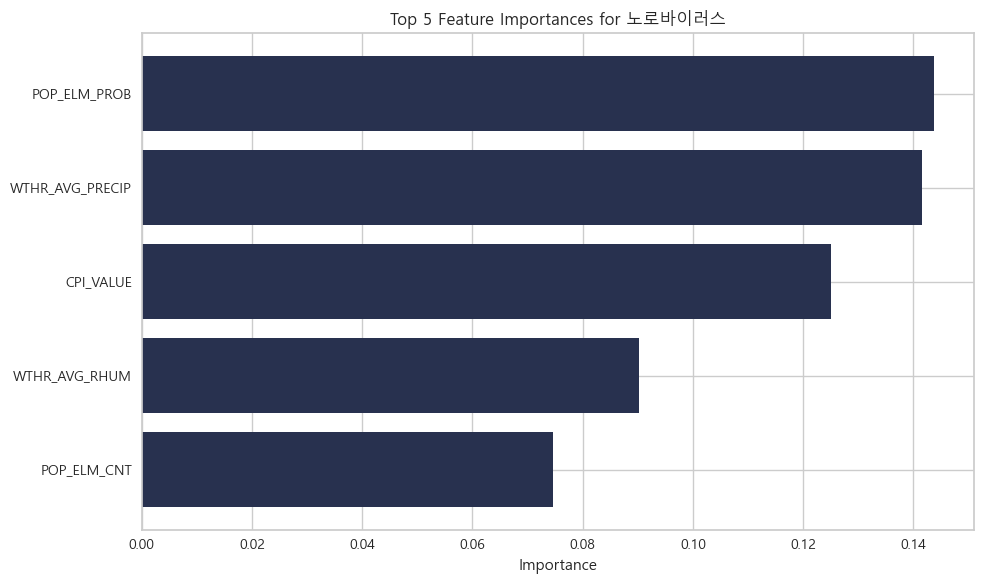

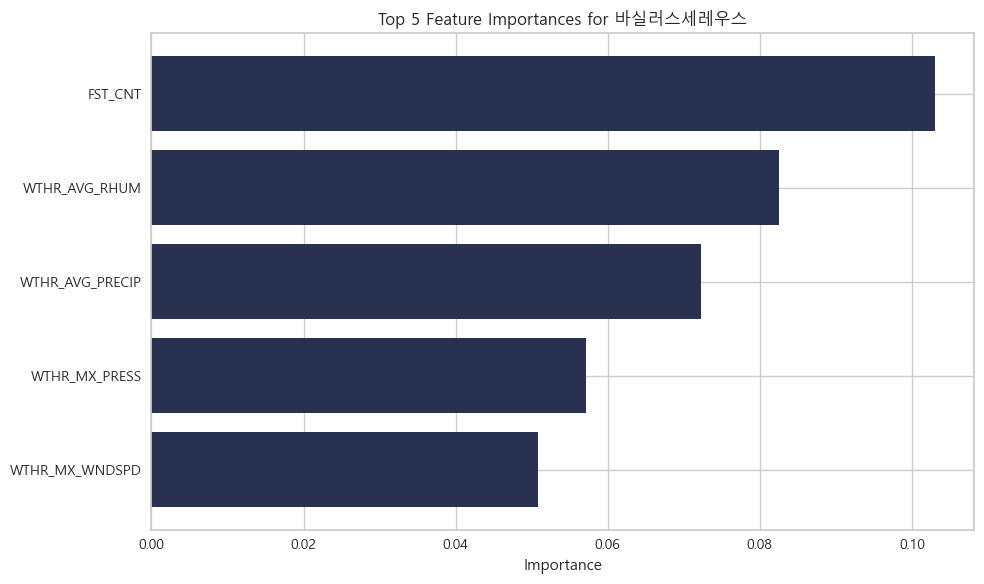

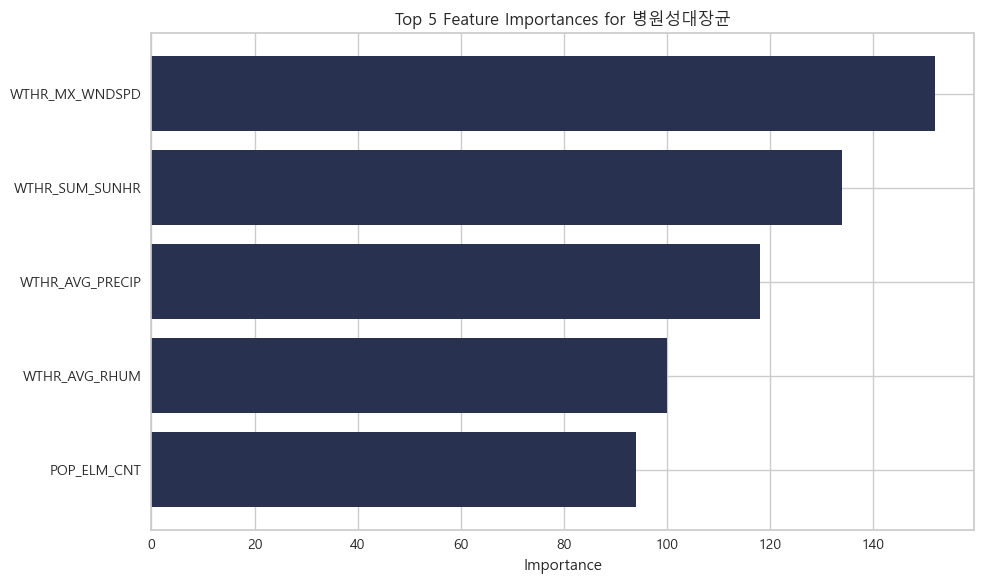

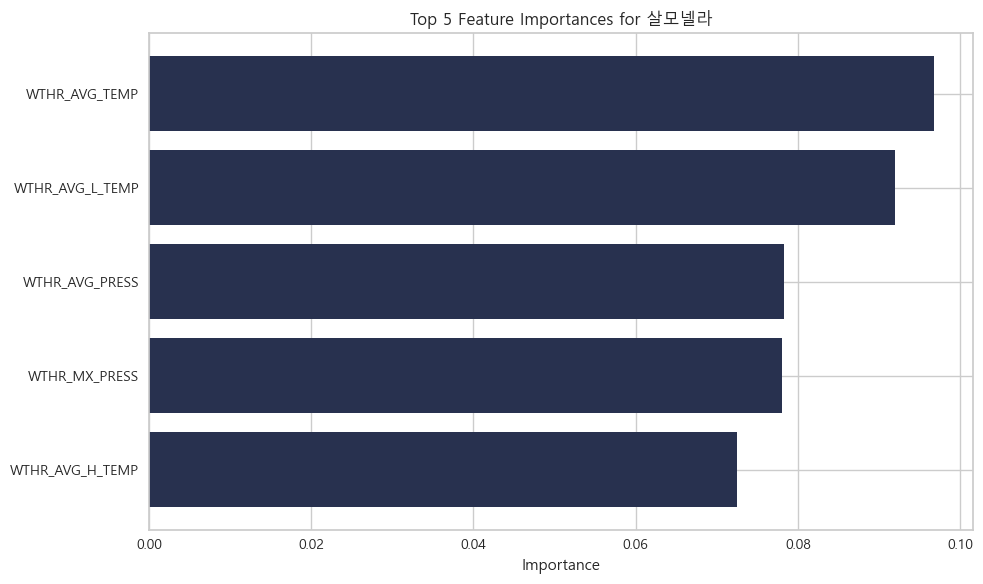

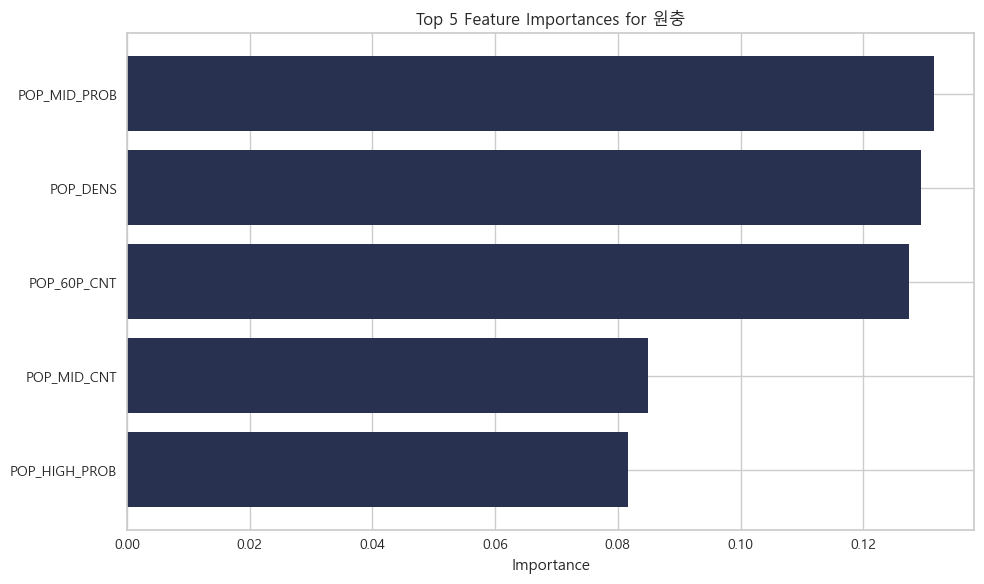

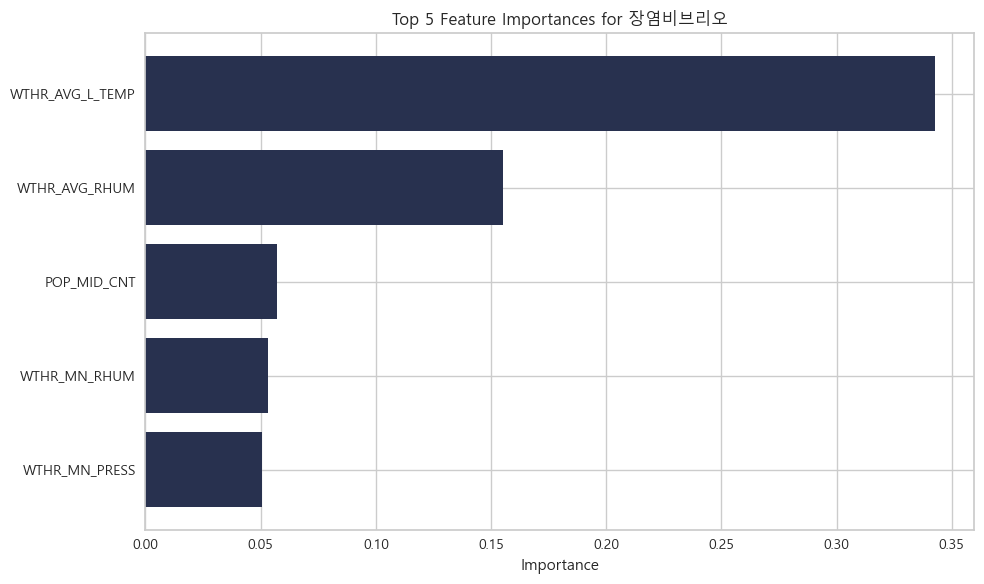

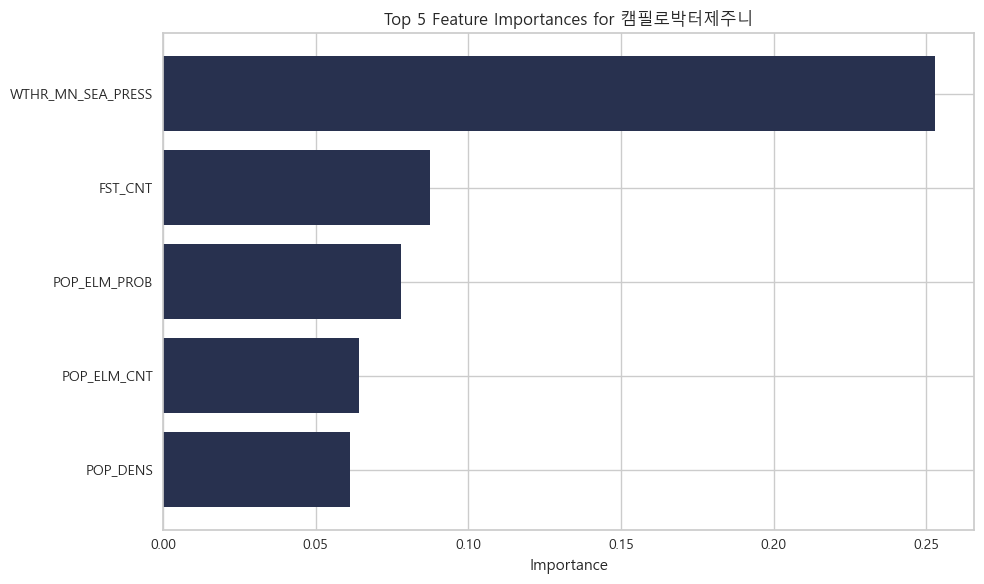

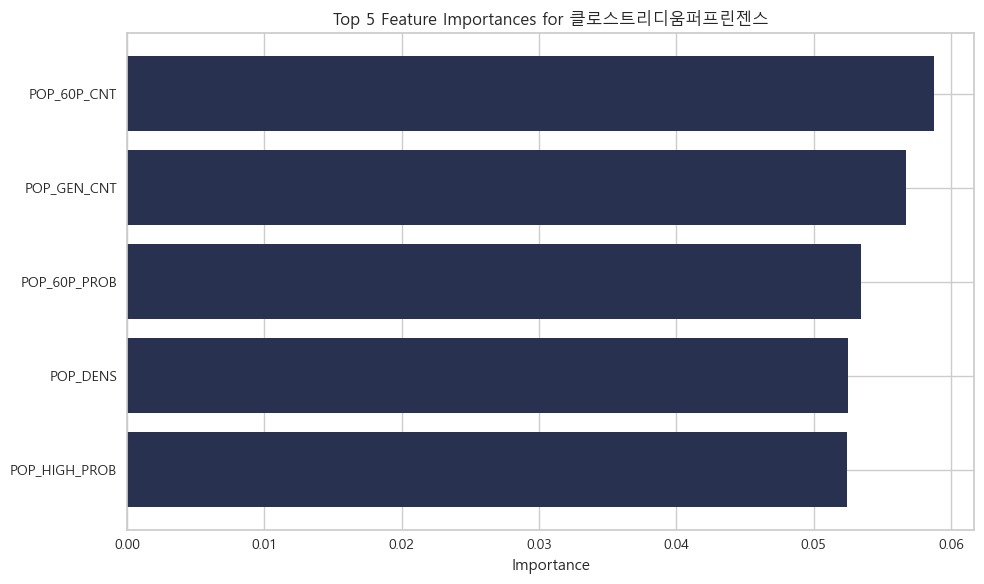

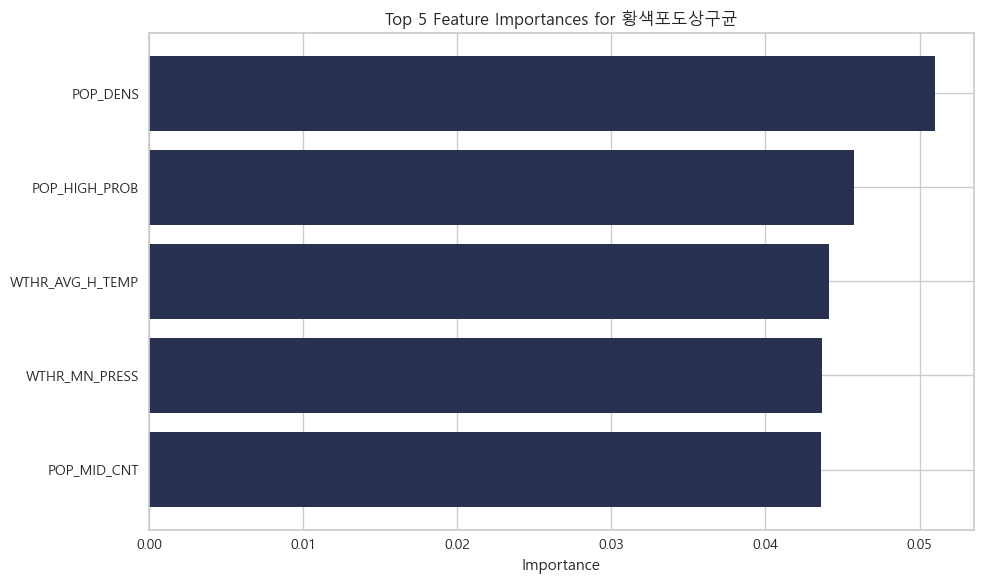

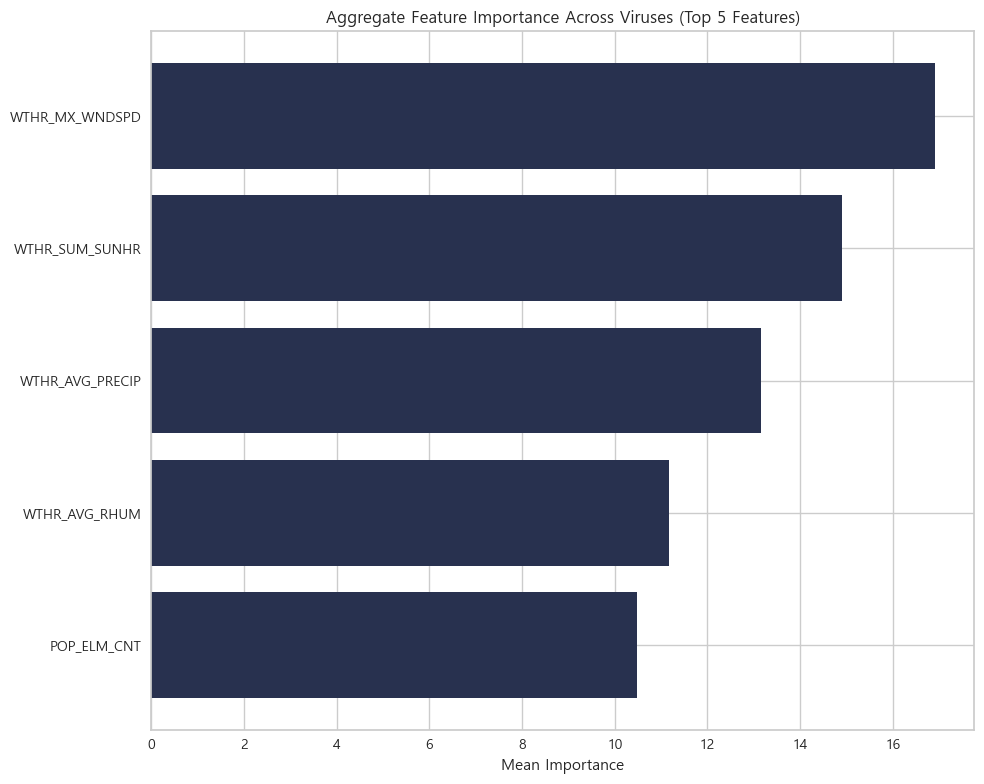

In [82]:
# top 5 feature importance
unique_viruses = top_features_by_virus['Virus'].unique()

for virus in unique_viruses:
    virus_data = top_features_by_virus[top_features_by_virus['Virus'] == virus]
    plt.figure(figsize=(10, 6))
    plt.barh(virus_data['Feature'], virus_data['Importance'], color='#28314F')
    plt.title(f"Top 5 Feature Importances for {virus}")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# top5 feature importance 평균
plt.figure(figsize=(10, 8))
plt.barh(aggregate_feature_importance['Feature'][:5], aggregate_feature_importance['Importance'][:5], color='#28314F')
plt.title("Aggregate Feature Importance Across Viruses (Top 5 Features)")
plt.xlabel("Mean Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### 3) ROC Curve 확인

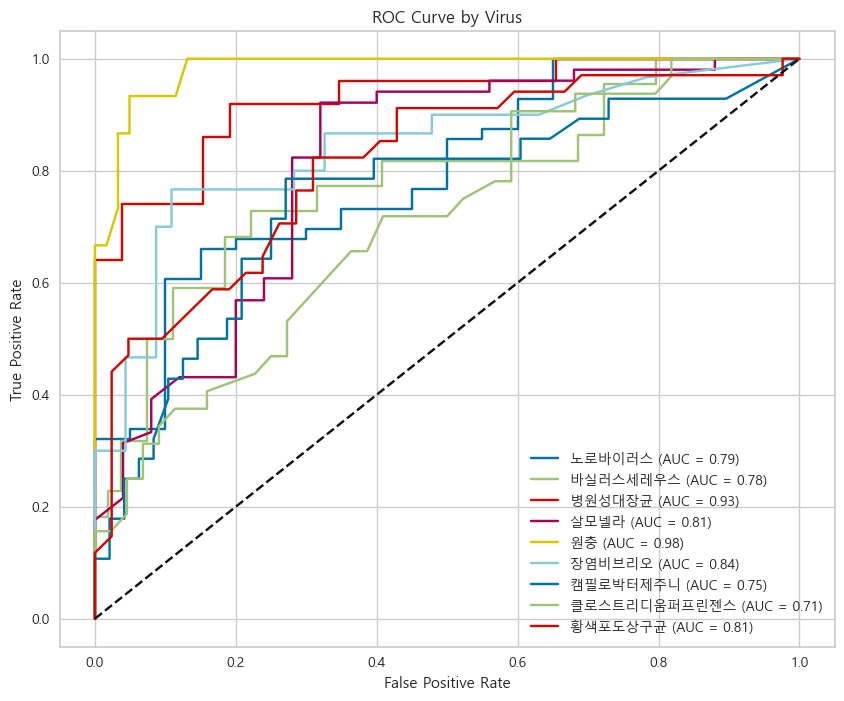

In [83]:
# 각 바이러스의 모델과 이름을 리스트로 가져와 ROC Curve 생성
plt.figure(figsize=(10, 8))
for virus, model_filename in zip(results_df['Virus'], results_df['Model']):
    model_file = f"{virus}_{model_filename}.pkl"
    if os.path.exists(model_file):
        model = joblib.load(model_file)
        
        # 테스트 데이터 준비
        virus_data = data[data['OCCRNC_VIRS'] == virus]
        X = virus_data.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_VIRS', 'OCCRNC_CNT', 'OCCRNC_IND', 'PATNT_CNT'])
        y = virus_data['OCCRNC_IND']
        _, X_test, _, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # ROC 곡선 그리기 (이진 분류인 경우에만)
        if len(np.unique(y_test)) == 2:
            y_score = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{virus} (AUC = {roc_auc:.2f})")
        else:
            print(f"Skipping ROC curve for {virus} due to multi-class target.")

# 그래프 속성 설정 및 출력
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Virus')
plt.legend(loc="lower right")
plt.show()

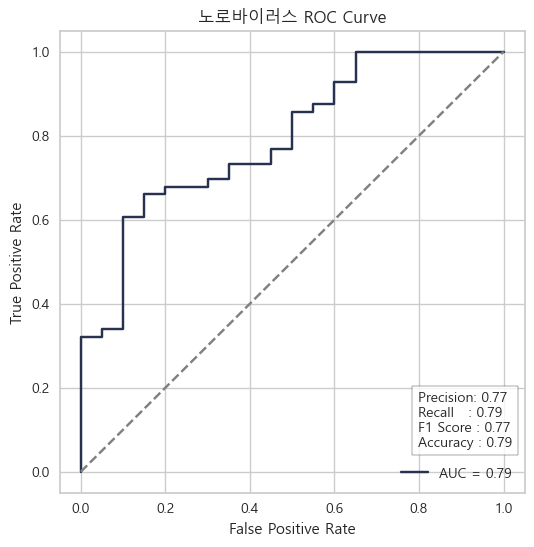

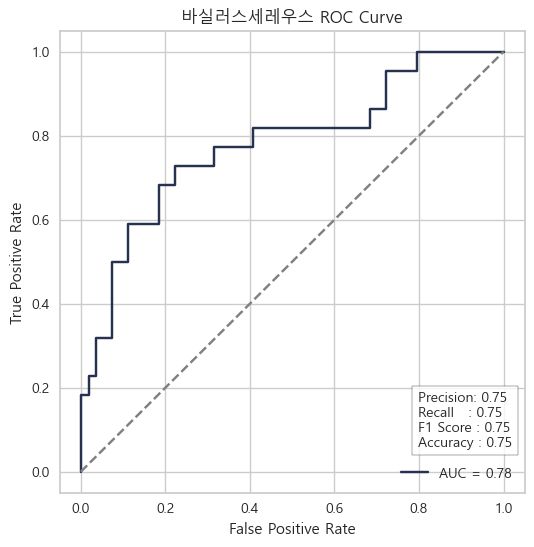

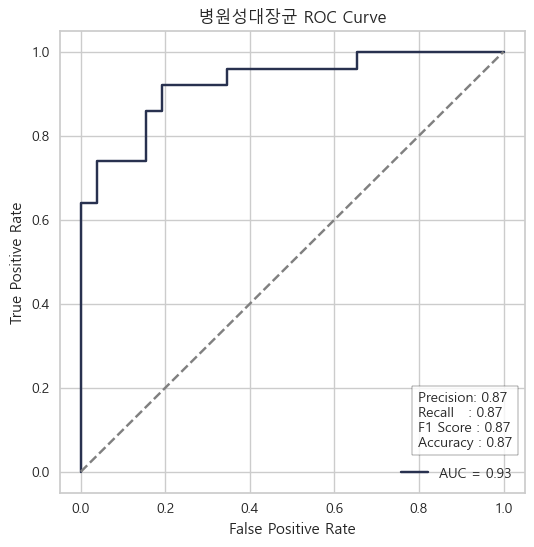

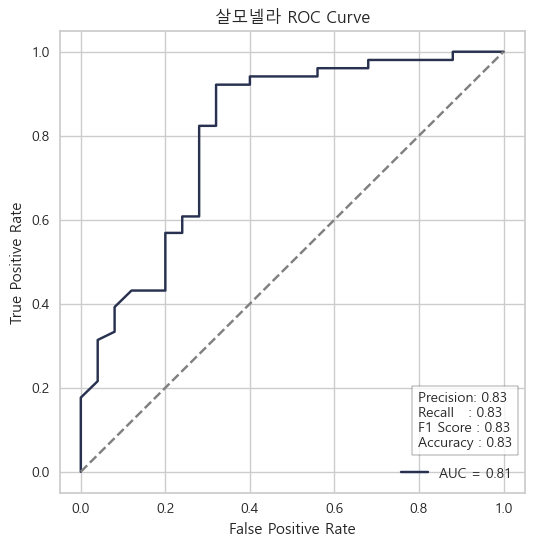

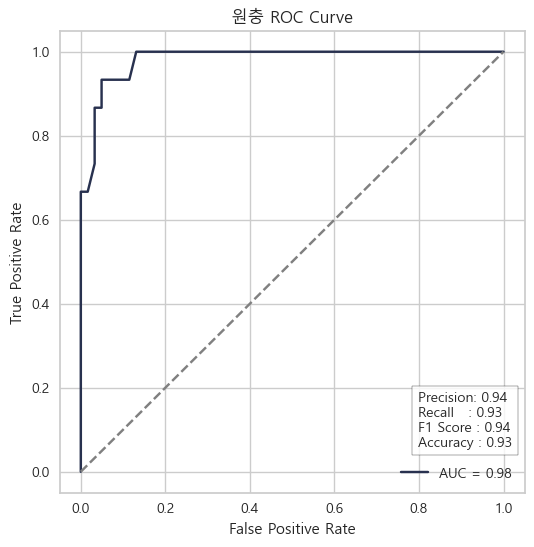

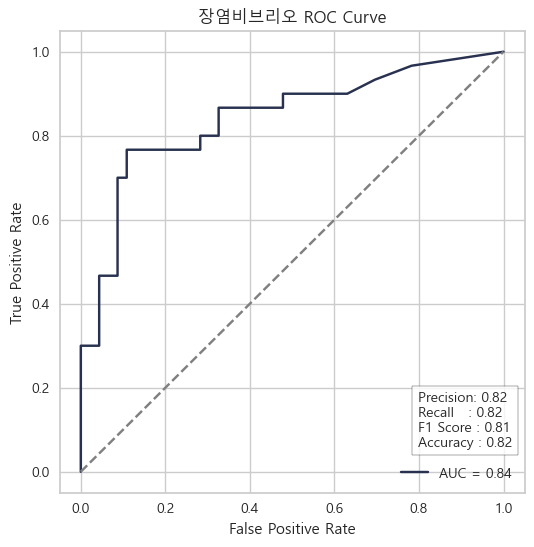

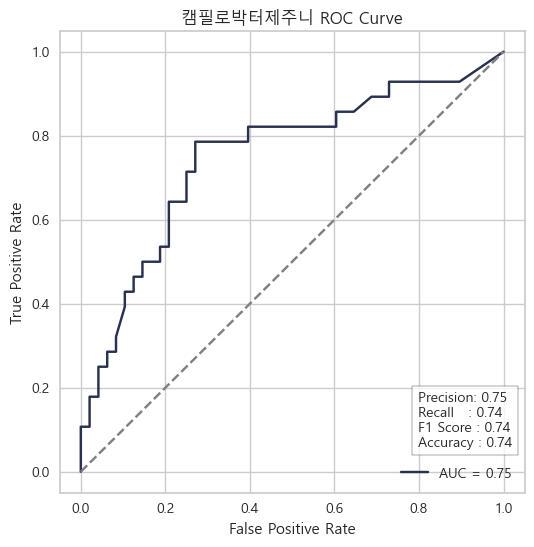

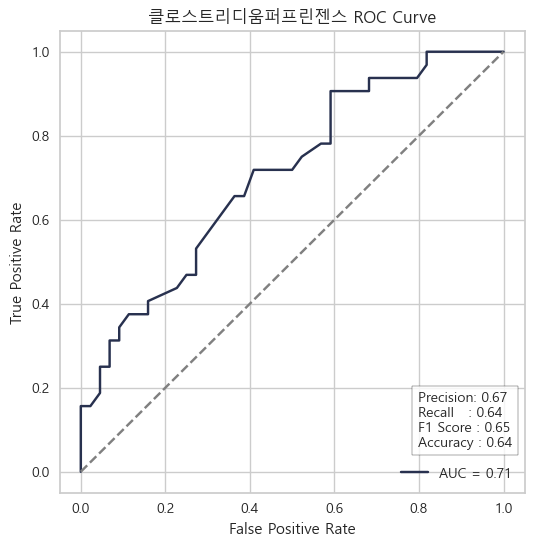

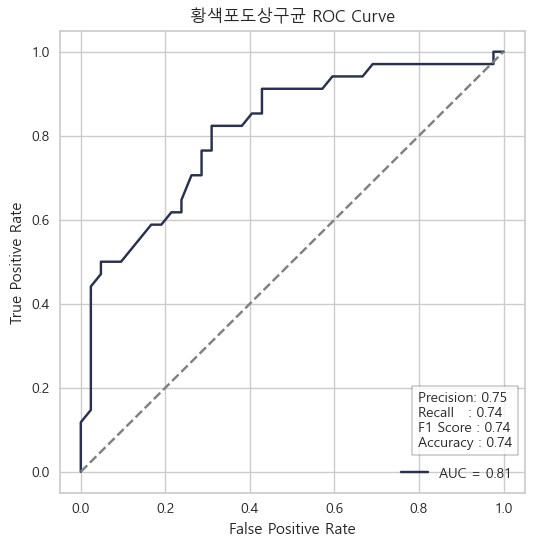

          Virus       AUC  Precision    Recall  F1 Score  Accuracy
0        노로바이러스  0.793750   0.774123  0.789474  0.770175  0.789474
1      바실러스세레우스  0.779461   0.753486  0.750000  0.751610  0.750000
2        병원성대장균  0.926154   0.868421  0.868421  0.868421  0.868421
3          살모넬라  0.807451   0.825824  0.828947  0.825932  0.828947
4            원충  0.982514   0.942302  0.934211  0.936372  0.934211
5        장염비브리오  0.841667   0.817814  0.815789  0.811195  0.815789
6      캠필로박터제주니  0.750744   0.747010  0.736842  0.739893  0.736842
7  클로스트리디움퍼프린젠스  0.706676   0.666275  0.644737  0.646400  0.644737
8       황색포도상구균  0.813375   0.753354  0.736842  0.736842  0.736842


In [84]:
# 초기화
metrics_results = []

# 원인물질별 모델 가져오기
viruses = results_df['Virus'].tolist()
model_files = [f"{virus}_{results_df[results_df['Virus'] == virus]['Model'].values[0]}.pkl" for virus in viruses]

for virus, model_file in zip(viruses, model_files):
    if os.path.exists(model_file):
        model = joblib.load(model_file)
        
        # test 설정
        virus_data = data[data['OCCRNC_VIRS'] == virus]
        X = virus_data.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_VIRS', 'OCCRNC_CNT', 'OCCRNC_IND', 'PATNT_CNT'])
        y = virus_data['OCCRNC_IND']
        _, X_test, _, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # 이진 분류인 경우에만 그림
        if len(np.unique(y_test)) == 2:
            y_pred = model.predict(X_test)
            y_score = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            accuracy = accuracy_score(y_test, y_pred)

            # 저장
            metrics_results.append({
                'Virus': virus,
                'AUC': roc_auc,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'Accuracy': accuracy
            })
            
            # 시각화
            plt.figure(figsize=(6, 6))
            plt.plot(fpr, tpr, color='#28314F',label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1],color='gray', linestyle='--' )
            plt.title(f"{virus} ROC Curve")
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="lower right")
            
            # 텍스트 박스
            text_str = (f"Precision: {precision:.2f}\n"
                        f"Recall   : {recall:.2f}\n"
                        f"F1 Score : {f1:.2f}\n"
                        f"Accuracy : {accuracy:.2f}")

            plt.gca().text(0.77, 0.22, text_str, fontsize=10, ha='left', va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

            plt.show()

# Convert results to DataFrame and display
metrics_df = pd.DataFrame(metrics_results)
print(metrics_df)

## 4. 시계열 모델링

In [85]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import r2_score

class ProphetPredictor:
    def __init__(self, periods):
        self.periods = periods
        self.models = {}
        self.r2_scores = {}

    def fit(self, data):
        self.data_columns = data.columns
        for column in data.columns:
            df = data[[column]].reset_index()
            df.columns = ['ds', 'y']
            model = Prophet()
            model.fit(df)
            self.models[column] = model

    def predict(self):
        future_predictions = pd.DataFrame()
        
        for column, model in self.models.items():
            future = model.make_future_dataframe(periods=self.periods, freq='M')
            forecast = model.predict(future)
            future_values = forecast[['ds', 'yhat']].tail(self.periods).set_index('ds')
            future_predictions[column] = future_values['yhat']
        
        return future_predictions

    def evaluate(self, data):
        for column, model in self.models.items():
            df = data[[column]].reset_index()
            df.columns = ['ds', 'y']
            forecast = model.predict(df)
            
            y_true = df['y']
            y_pred = forecast['yhat']
            
            valid_index = y_true.notna() & y_pred.notna()
            y_true = y_true[valid_index]
            y_pred = y_pred[valid_index]
            
            if len(y_true) > 0:
                self.r2_scores[column] = r2_score(y_true, y_pred)
            else:
                self.r2_scores[column] = None  
        return self.r2_scores
